In [1]:
#import requests
#import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsRegressor

In [2]:
import scipy.stats
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score ,f1_score ,roc_auc_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

In [3]:
from catboost import CatBoostClassifier
from sklearn.model_selection import  StratifiedKFold,train_test_split,cross_val_score
from sklearn.metrics import log_loss,f1_score,roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import  GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [5]:
def Convert_Time(row): 
    tokens = row.split(':')
    if len(tokens) ==2:
        return int(tokens[0]) + int(tokens[1])/60
    
def Rest_days(row):
    if isinstance(row,int) or isinstance(row,float):
        return row
    tokens = row.split(' ')
    return int(tokens[0])

def get_matches_played_in_szn(df):
    df = df.copy()
    gp_arr=[]
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            team_df['Matches_Played'] = 1
            gd_cum = team_df['Matches_Played'].cumsum()
            gp_arr.append(gd_cum)
    cum = pd.concat(gp_arr)
    cum = cum.sort_index()
    #cum.columns = cum_cols
    df_with_cum = pd.concat([df,cum],axis=1)
    return df_with_cum

def get_cum_by_col(df,grouper,grouper_name,cols,agg_func):
    df = df.copy()
    gp_arr=[]
    for team,team_df in df.groupby('Team'):
        for g,gd in team_df.groupby([grouper])[cols]:
            #print(g)
            #display(gd)
            if agg_func == 'sum':
                gd_cum = gd.shift(1).cumsum()
            if agg_func == 'mean':
                gd_cum = gd.shift(1).expanding().mean()
            for col in cols:
                gd_cum[col].fillna(gd_cum[col].mean(), inplace=True)
            gp_arr.append(gd_cum)
    cum = pd.concat(gp_arr)
    cum = cum.sort_index()
    alias = '_this_'+grouper_name+'_'+agg_func
    cum_cols = [col+alias for col in cols]
    cum.columns = cum_cols
    df_with_cum = pd.concat([df,cum],axis=1)
    return df_with_cum 

def rolling_average_or_sum(df,cols,window,agg_func):
    df = df.copy()
    alias = '_last_'+str(window)+'gm_'+agg_func
    new_cols = [col+alias for col in cols]
    gp_arr=[]
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            #for g,gd in team_df.groupby([grouper])[cols]:
                if agg_func == 'sum':
                    rolling = team_df[cols].shift(1).rolling(window).sum()
                if agg_func == 'mean':
                    rolling = team_df[cols].shift(1).rolling(window).mean()
                    
                rolling.columns = new_cols   
                gp_arr.append(rolling)
    #display(rolling)
    rolling_df = pd.concat(gp_arr)
    rolling_df = rolling_df.sort_index()
    #rolling.columns = new_cols
    df_rolling = pd.concat([df,rolling_df],axis=1)
    return df_rolling

def Similar_Category2d(df,column,similar_categories_2d_array,category_array):
    df=df.copy()
    for idx,similar_categories1d in enumerate(similar_categories_2d_array):
        rows_with_matches = df[column].isin(similar_categories1d)
        df.loc[rows_with_matches,column] = category_array[idx]
        return df
    
def Cat_Code(df,columns):
    df=df.copy()
    for col in columns:
        new_feature = col+'_code'
        df[new_feature] = df[col].astype("category").cat.codes
    return df

def get_Cum_Sum_Avg(df,cols,agg_func):
    df = df.copy()
    for col in cols:
        new_feature = col+'_Total_'+agg_func
        if agg_func == 'sum':
            df[new_feature] = df[col].shift(1).cumsum()
        if agg_func == 'mean':
            df[new_feature] = df[col].shift(1).expanding().mean()
    return df

def missing_percentage(df):
    """A function for returning missing ratios."""
    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


In [6]:
def Feature_Engineering(df):
    df=df.copy()
    #First_Match_In_Month
    first_occurence_idx = []
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            for column,column_df in team_df.groupby('Month'):
                first_occurence_idx.append(column_df.index[0])
                
    df.loc[first_occurence_idx,'First_Match_In_Month'] = 1
    df['First_Match_In_Month'].replace(np.nan, 0, inplace=True)
    
    #First_Match_With_Formation
    first_occurence_idx = []
    for year,yr_df in df.groupby('Season'):
        for team,team_df in yr_df.groupby('Team'):
            for column,column_df in team_df.groupby('Formation'):
                first_occurence_idx.append(column_df.index[0])
    
    df.loc[first_occurence_idx,'First_Match_With_Formation'] = 1
    df['First_Match_With_Formation'].replace(np.nan, 0, inplace=True)
    
    #Gameweek
    df = get_matches_played_in_szn(df)
    
    #Opponent
    mask = df['Opponent'].str.contains('eng')
    df.loc[mask,'Opponent'] = df.loc[mask,'Opponent'].replace('eng ',"",regex=True) 
    
    df['Opponent_Count'] =  df['Opponent'].map(df.Opponent.value_counts().to_dict())
    
    arr = ['zeros','ones','twos','threes','fours','fives','sixs','sevens','eights','nines']
    no = [str(x) for x  in list(range(0,10))]
    no_dict = dict(zip(no,arr))
    for key,value in df.Opponent.value_counts().to_dict().items():
        if value <10:
            #print(key,no_dict[str(value)])
            mask = df.Opponent==key
            df.loc[mask,'Opponent'] = no_dict[str(value)]
    
    #top4 and top 7
    top7 = ['Chelsea','Manchester City','Liverpool','Tottenham','Manchester Utd','Arsenal','Leicester City']
    top4 = ['Chelsea','Manchester City','Liverpool','Manchester Utd']
    
    df['Top7_Opp'] = df.apply(lambda x : 1 if x.Opponent in top7  else 0 ,axis=1)
    df['Top7_Team'] = df.apply(lambda x : 1 if x.Team in top7  else 0 ,axis=1)
    df['Top4_Opp'] = df.apply(lambda x : 1 if x.Opponent in top4  else 0 ,axis=1)
    df['Top4_Team'] = df.apply(lambda x : 1 if x.Team in top4  else 0 ,axis=1)
    #------------------------->>>>>>>>>>>>>>>>>.
    
    #Referees
    df['Referee_Count'] =  df['Referee'].map(df.Referee.value_counts().to_dict())
    
    for key,value in df.Referee.value_counts().to_dict().items():
        if value <10:
            #print(key,no_dict[str(value)])
            mask = df.Referee==key
            df.loc[mask,'Referee'] = no_dict[str(value)]

    #ref_ranking
    top_refs = ['Michael Oliver','Anthony Taylor','Darren England','Paul Tierney','Andre Marriner',
            'Andy Madley','Stuart Attwell','Mike Dean','Craig Pawson','Martin Atkinson','Jonathan Moss',
            'David Coote','Kevin Friend','Jarred Gillett','Robert Jones','Peter Bankes','Graham Scott',
            'Chris Kavanagh','Simon Hooper',
           ]
    ref_Ranking = [8,7.5,7,7,6.5,6,5.5,5.5,5,5,5,5,5,5,4.5,4.5,4,4,4,]
    df['top20_Ref'] = df.apply(lambda x : 1 if x.Referee in top_refs  else 0 ,axis=1)
    df['top5_Ref'] = df.apply(lambda x : 1 if x.Referee in top_refs[:5]  else 0 ,axis=1)
    
    lg = ['Post_Season_Cup', 'Premier League', 'Europa', 'EFL Cup', 'FA Cup',
       'Champions Lg']
    df['Ref_rank'] = df['Referee'].map(dict(zip(top_refs,ref_Ranking)))
    rank_na = [7,3,6,5,5,7]
    for comp,rank in zip(lg,rank_na):
            mask = (df.Comp==comp)
            df.loc[mask,'Ref_rank'] = df.loc[mask,'Ref_rank'].fillna(rank)

    #---------------------->>>>>>>>>>>>>>>>> 
    #Time
    df.loc[:,'Time'] = df.Time.apply(Convert_Time)
    #Rest
    df.loc[:,'Rest'] = df.Rest.apply(Rest_days)
    
    #Comp
    df = Similar_Category2d(df,column='Comp',
                   similar_categories_2d_array=[['Europa Lg','Conf Lg'],['Community Shield','Super Cup']],
                   category_array=['Europa','Post_Season_Cup'])
    
    #drop ['Prev_match_date',Prev_comp',Prev_Opp']
    df.drop(['Prev_match_date','Prev_comp','Prev_Opp'],axis=1,inplace=True)
    
    #Prev_comp',Prev_Opp'
    df['Prev_comp'] = df.Comp.shift(1)
    df['Prev_Opp'] = df.Opponent.shift(1)
    
    #captain
    df['Captain_Count'] =  df['Captain'].map(df.Captain.value_counts().to_dict())
    df['Captain_Rank'] = df['Captain_Rank'].astype("category").cat.codes
    
    #get_cum_by_col
    df=get_cum_by_col(df=df,grouper='Comp',grouper_name='Comp',cols=['Win','Lose','Draw','GF','GA','Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss'],agg_func='sum')
    df=get_cum_by_col(df=df,grouper='Top7_Opp',grouper_name='7_Opp',cols=['Win','Lose','Draw','GF','GA','Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss'],agg_func='sum')
    df=get_cum_by_col(df=df,grouper='Top4_Opp',grouper_name='4_Opp',cols=['Win','Lose','Draw','GF','GA','Away_Win','Away_Draw','Away_Loss','Home_Win','Home_Draw','Home_Loss'],agg_func='sum')
    df=get_cum_by_col(df=df,grouper='Ref_rank',grouper_name='Ref',cols=['Win','Lose','Draw','GF','GA'],agg_func='sum')
    
    df = get_cum_by_col(df,grouper='Comp',grouper_name='Comp',cols=['Poss','GF','GA','Win','Lose'],agg_func='mean')
    df = get_cum_by_col(df,grouper='Top7_Opp',grouper_name='7_Opp',cols=['Poss','GF','GA','Win','Lose','Draw'],agg_func='mean')
    df = get_cum_by_col(df,grouper='Ref_rank',grouper_name='Ref_rank',cols=['Poss','GF','GA','Win','Lose','Draw'],agg_func='mean')
    
    #cat_code
    cat_cols = ['Comp','Day','Venue','Opponent','Captain','Formation','Referee','Team','Prev_comp', 'Prev_Opp']
    df = Cat_Code(df=df,columns=cat_cols)
    
    #Month is a cyclic feature
    ##Gabriel Atkin
    df.loc[:,'Cyclic_Month'] = (-np.cos(0.5236 * df['Month']))
    
    #advance_stats_rolling
    #fillna
    
        #Na_Count
    df['Na_count'] = df.apply(lambda x :len(x) - x.count(),axis=1)
    
    #fill_na
    fill_with_zero = 'Total_Points	Total_GF	Total_GA	Total_Win	Total_Draw	Total_Loss	Points_Avg_for_szn	GF_Avg_for_szn	GA_Avg_for_szn	Win_Avg_for_szn	Draw_Avg_for_szn	Loss_Avg_for_szn'.split('	')
    for col in fill_with_zero:
        df[col].replace(np.nan, 0, inplace=True)
    
    return df

In [7]:
def predictions(data,predictors,targets,model):
    data = data.copy()
    train = data[data["Season"] < 2022]
    test = data[data["Season"] == 2022]
    combination = []
    for target in targets:
        model.fit(train[predictors], train[target])
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        error = accuracy_score(test[target], preds)
        print(f"{target} Accuracy Score : ",error)
        print()
        col ="predicted_"+target
        combined = pd.DataFrame(dict(actual=test[target], predicted=preds))
        combined.columns = ['actual',col]
        combination.append(combined) 
        display(pd.crosstab(index=combined["actual"], columns=combined[col]))
        if target == 'Points':
            print(f"{target} Precision _Macro_Micro : ",precision_score(test[target], preds, average = 'macro'),precision_score(test[target], preds, average = 'micro'))# print("Precision : ",precision_score(test[target], preds))
            print(f"{target} F1_score _Macro_Micro : ",f1_score(test[target], preds, average = 'macro'),f1_score(test[target], preds, average = 'micro'))
            #print(f"{target} ROC _Macro_Micro : ",roc_auc_score(test[target], preds, average = 'macro'),roc_auc_score(test[target], preds, average = 'micro'))
        else:
            print(f"{target} Precision : ",precision_score(test[target], preds))
            print(f"{target} F1_score : ",f1_score(test[target], preds))
            print(f"{target} ROC : ",roc_auc_score(test[target], preds))
        print()
        print()
    combinations = pd.concat(combination,axis=1)
    combinations = combinations.merge(test[["Team", "Opponent", "Result"]], left_index=True, right_index=True)
    return combinations

In [8]:
def make_mi_scores_Classif(X_train, y_train):
    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = X_train.dtypes == int
    mi_scores = mutual_info_classif(X_train, y_train, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(20,14))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
def apply_pca(X,alias, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC_{alias}{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    #print( pca.components_)
    return pca, X_pca, loadings

def topk_feat(df,mi_scores,PC,cols,thresh,targets):
    df = df.copy()
    mi_scores = mi_scores.copy()
    topk = mi_scores[mi_scores>thresh].index.to_list()
    base_df = pd.concat([df.loc[:,cols].reset_index(drop=True),PC],axis=1)
    #display(base_df.head(2))
    base_df = base_df[topk]
    out_df = pd.concat([df.loc[:,targets+['Season']].reset_index(drop=True),base_df],axis=1)
    return  out_df

def Ratio(df_def,a,b,ratio_name):
    df_def = df_def.copy()
    new_feature = ratio_name
    df_def[new_feature] = df_def[a]/df_def[b]
    mask = (df_def[b]==0)
    df_def.loc[mask,new_feature]=0 
    return df_def

In [9]:
def Feat_Engr2(df):
    df = df.copy()
    def total_variable(new_df):
        new_df = new_df.copy()
        new_df = Ratio(df_def=new_df,a='Total_Points',b='Total_Win',ratio_name='Tot_Pts/Win')
        new_df = Ratio(df_def=new_df,a='Total_Points',b='Total_Loss',ratio_name='Tot_Pts/Loss')
        new_df = Ratio(df_def=new_df,a='Total_Points',b='Total_Draw',ratio_name='Tot_Pts/Draw')
        new_df = Ratio(df_def=new_df,a='Total_Points',b='Total_GF',ratio_name='Tot_Pts/GF')
        new_df = Ratio(df_def=new_df,a='Total_Points',b='Total_GA',ratio_name='Tot_Pts/GA')
        new_df = Ratio(df_def=new_df,a='Total_Win',b='Total_Loss',ratio_name='Tot_Win/Loss')
        new_df = Ratio(df_def=new_df,a='Total_Win',b='Total_Draw',ratio_name='Tot_Win/Draw')
        new_df = Ratio(df_def=new_df,a='Total_Draw',b='Total_Loss',ratio_name='Tot_Draw/Loss')
        new_df = Ratio(df_def=new_df,a='Total_Win',b='Total_GF',ratio_name='Tot_Win/GF')
        new_df = Ratio(df_def=new_df,a='Total_Loss',b='Total_GA',ratio_name='Tot_Loss/GA')
        new_df = Ratio(df_def=new_df,a='Total_Draw',b='Total_GF',ratio_name='Tot_Draw/GF')
        new_df = Ratio(df_def=new_df,a='Total_GF',b='Total_GA',ratio_name='Tot_GF/GA')
        new_df['Tot_GF_GA_+-'] = new_df['Total_GF'] - new_df['Total_GA']
        return new_df
    df1 = total_variable(new_df=df)
    
    def szn_avg_variable(new_df):
        new_df = new_df.copy()
        new_df = Ratio(df_def=new_df,a='Points_Avg_for_szn',b='Win_Avg_for_szn',ratio_name='Avg_Pts/Win')
        new_df = Ratio(df_def=new_df,a='Points_Avg_for_szn',b='Loss_Avg_for_szn',ratio_name='Avg_Pts/Loss')
        new_df = Ratio(df_def=new_df,a='Points_Avg_for_szn',b='GF_Avg_for_szn',ratio_name='Avg_Pts/GF')
        new_df = Ratio(df_def=new_df,a='Points_Avg_for_szn',b='GA_Avg_for_szn',ratio_name='Avg_Pts/GA')
        new_df = Ratio(df_def=new_df,a='Win_Avg_for_szn',b='GA_Avg_for_szn',ratio_name='Avg_Win/GA')
        new_df = Ratio(df_def=new_df,a='Win_Avg_for_szn',b='GF_Avg_for_szn',ratio_name='Avg_Win/GF')
        new_df = Ratio(df_def=new_df,a='Win_Avg_for_szn',b='Loss_Avg_for_szn',ratio_name='Avg_Win/Loss')
        new_df = Ratio(df_def=new_df,a='Win_Avg_for_szn',b='Draw_Avg_for_szn',ratio_name='Avg_Win/Draw')
        new_df = Ratio(df_def=new_df,a='Loss_Avg_for_szn',b='GA_Avg_for_szn',ratio_name='Avg_Loss/GA')
        new_df = Ratio(df_def=new_df,a='Loss_Avg_for_szn',b='GF_Avg_for_szn',ratio_name='Avg_Loss/GF')
        new_df = Ratio(df_def=new_df,a='Draw_Avg_for_szn',b='GF_Avg_for_szn',ratio_name='Avg_Draw/GF')
        new_df = Ratio(df_def=new_df,a='Draw_Avg_for_szn',b='GA_Avg_for_szn',ratio_name='Avg_Draw/GA')
        new_df = Ratio(df_def=new_df,a='GF_Avg_for_szn',b='GA_Avg_for_szn',ratio_name='Avg_GF/GA')
        new_df['Avg_GF_GA+-'] = new_df.GF_Avg_for_szn - new_df.GA_Avg_for_szn
        return new_df
    df2 =  szn_avg_variable(new_df=df1)
    
    def l2gm_variable(new_df):
        new_df = new_df.copy()
        new_df = Ratio(df_def=new_df,a='Win_last_2gm_sum',b='GA_last_2gm_sum',ratio_name='l2_Win/GA')
        new_df = Ratio(df_def=new_df,a='Win_last_2gm_sum',b='GF_last_2gm_sum',ratio_name='l2_Win/GF')
        new_df = Ratio(df_def=new_df,a='Win_last_2gm_sum',b='Lose_last_2gm_sum',ratio_name='l2_Win/Loss')
        new_df = Ratio(df_def=new_df,a='Win_last_2gm_sum',b='Draw_last_2gm_sum',ratio_name='l2g_Win/Draw')
        new_df = Ratio(df_def=new_df,a='Lose_last_2gm_sum',b='GA_last_2gm_sum',ratio_name='l2g_Loss/GA')
        new_df = Ratio(df_def=new_df,a='Lose_last_2gm_sum',b='GF_last_2gm_sum',ratio_name='l2g_Loss/GF')
        new_df = Ratio(df_def=new_df,a='Draw_last_2gm_sum',b='GF_last_2gm_sum',ratio_name='l2g_Draw/GF')
        new_df = Ratio(df_def=new_df,a='Draw_last_2gm_sum',b='GA_last_2gm_sum',ratio_name='l2g_Draw/GA')
        new_df = Ratio(df_def=new_df,a='GF_last_2gm_sum',b='GA_last_2gm_sum',ratio_name='l2g_GF/GA')
        new_df['l2g_GF_GA+-'] = new_df.GF_last_2gm_sum - new_df.GA_last_2gm_sum
        return new_df
    df3 = l2gm_variable(new_df=df2)
    
    def l3gm_variable(new_df):
        new_df = new_df.copy()
        new_df = Ratio(df_def=new_df,a='Win_last_3gm_mean',b='GA_last_3gm_mean',ratio_name='l3_Win/GA')
        new_df = Ratio(df_def=new_df,a='Win_last_3gm_mean',b='Lose_last_3gm_mean',ratio_name='l3_Win/Loss')
        new_df = Ratio(df_def=new_df,a='Win_last_3gm_mean',b='Draw_last_3gm_mean',ratio_name='l3g_Win/Draw')
        new_df = Ratio(df_def=new_df,a='Lose_last_3gm_mean',b='GA_last_3gm_mean',ratio_name='l3g_Loss/GA')
        new_df = Ratio(df_def=new_df,a='Lose_last_3gm_mean',b='GF_last_3gm_mean',ratio_name='l3g_Loss/GF')
        new_df = Ratio(df_def=new_df,a='Draw_last_3gm_mean',b='GF_last_3gm_mean',ratio_name='l3g_Draw/GF')
        new_df = Ratio(df_def=new_df,a='Draw_last_3gm_mean',b='GA_last_3gm_mean',ratio_name='l3g_Draw/GA')
        new_df = Ratio(df_def=new_df,a='GF_last_3gm_mean',b='GA_last_3gm_mean',ratio_name='l3g_GF/GA')
        new_df['l3g_GF_GA+-'] = new_df.GF_last_3gm_mean - new_df.GA_last_3gm_mean
        return new_df
    df4 = l3gm_variable(new_df=df3)
    
    def this_month_variable(new_df):
        new_df = new_df.copy()
        new_df = Ratio(df_def=new_df,a='Home_Win_this_month_sum',b='GA_this_month_sum',ratio_name='this_month_sum_Win/GA')
        new_df = Ratio(df_def=new_df,a='GF_this_month_sum',b='GA_this_month_sum',ratio_name='this_month_sum_GF/GA')
        new_df['this_month_sum_GF_GA+-'] = new_df.GF_this_month_sum - new_df.GA_this_month_sum
        return new_df
    df5 = this_month_variable(new_df=df4)
    
    return df5

In [28]:
def advanced_ish(df):
    df = df.copy()
    for col in advance_stats_cols:
        df[col].replace(np.nan, 0, inplace=True)
    
    df = rolling_average_or_sum(df=df,cols=advance_stats_cols,window=2,agg_func='sum') #last2gm
    df = rolling_average_or_sum(df=df,cols=advance_stats_cols,window=3,agg_func='mean') #lats3gm
    
    df = get_Cum_Sum_Avg(df=df,cols=advance_stats_cols,agg_func='sum') # cum sum
    df = get_Cum_Sum_Avg(df=df,cols=advance_stats_cols,agg_func='mean') #cum avg"""
    df = df.drop(advance_stats_cols,axis=1)
    return df

def get_explained_variance(df,cols,standardize=True,range_comp=20):
    X = df[cols]
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    for i in range(1,range_comp):
    # Create principal components
        pca = PCA(n_components=i)
        X_pca = pca.fit(X)
        transformed = pca.transform(X)
        print(f" Cummulative explained variance for {i} components: {np.sum(pca.explained_variance_ratio_)}")
        print("")
        print("==============>>>>>>>>>>>>>>>")
        
def apply_pca_ads(X,alias, standardize=True,n_comps =10):
    X=X.copy()
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA(n_components = n_comps)
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC_{alias}{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    #print( pca.components_)
    return pca, X_pca, loadings

In [11]:
def get_PCA_cols(df,target,features_list,name_list,targets):
    df = df.copy()
    new_df_dict = {}
    for columns,col_name in zip(features_list,name_list):
        X_present = 'X_'+col_name
        print(X_present)
        X_present = df.loc[:,columns]
        pca_, X_pca_, loadings_ = apply_pca(X=X_present,alias=col_name)
        display(loadings_)
        #win
        print()
        mi_scores_ = make_mi_scores_Classif(X_train=pd.concat([X_present.reset_index(drop=True),X_pca_],axis=1), y_train=df[target])
        plot_mi_scores(scores=mi_scores_)
        new = topk_feat(df=df,mi_scores=mi_scores_,PC=X_pca_,cols=columns,thresh=0,targets=targets)
        new_df_dict[col_name] = new
        print()
    return new_df_dict

In [12]:
def predictions(data,predictors,targets,model):
    data = data.copy()
    train = data[data["Season"] < 2022]
    test = data[data["Season"] == 2022]
    combination = []
    for target in targets:
        model.fit(train[predictors], train[target])
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0
        error = accuracy_score(test[target], preds)
        print(f"{target} Accuracy Score : ",error)
        print()
        col ="predicted_"+target
        combined = pd.DataFrame(dict(actual=test[target], predicted=preds))
        combined.columns = ['actual',col]
        combination.append(combined) 
        display(pd.crosstab(index=combined["actual"], columns=combined[col]))
        if target == 'Points':
            print(f"{target} Precision _Macro_Micro : ",precision_score(test[target], preds, average = 'macro'),precision_score(test[target], preds, average = 'micro'))# print("Precision : ",precision_score(test[target], preds))
            print(f"{target} F1_score _Macro_Micro : ",f1_score(test[target], preds, average = 'macro'),f1_score(test[target], preds, average = 'micro'))
            #print(f"{target} ROC _Macro_Micro : ",roc_auc_score(test[target], preds, average = 'macro'),roc_auc_score(test[target], preds, average = 'micro'))
        else:
            print(f"{target} Precision : ",precision_score(test[target], preds))
            print(f"{target} F1_score : ",f1_score(test[target], preds))
            print(f"{target} ROC : ",roc_auc_score(test[target], preds))
        print()
        print()
    combinations = pd.concat(combination,axis=1)
    combinations = combinations.merge(test[["Team", "Opponent", "Result"]], left_index=True, right_index=True)
    return combinations

In [13]:
df  = pd.read_csv("C:\\Users\\user\\Solo Dolo\\EPL Analysis\\All_team_data2.csv")
df.shape

(4783, 249)

In [14]:
df['Def_Tkl+Int'].isna().sum()

4783

In [15]:
df2 = Feature_Engineering(df=df)
df2.shape

(4783, 328)

In [16]:
df21 = Feat_Engr2(df=df2)
df21.shape

(4783, 377)

In [17]:
drops =['Unnamed: 0','Date','Round','Poss','Attendance','Notes','Attendance','xG','xGA','Match Report','Def_Tkl+Int']
advance_stats_cols = 'Standard_Gls	Standard_Sh	Standard_SoT	Standard_SoT%	Standard_G/Sh	Standard_G/SoT	Standard_Dist	Standard_FK	Standard_PK	Standard_PKatt	Expected_xG	Expected_npxG	Expected_npxG/Sh	Expected_G-xG	Expected_np:G-xG	SCA_Types_SCA	SCA_Types_PassLive	SCA_Types_PassDead	SCA_Types_Drib	SCA_Types_Sh	SCA_Types_Fld	SCA_Types_Def	GCA_Types_GCA	GCA_Types_PassLive	GCA_Types_PassDead	GCA_Types_Drib	GCA_Types_Sh	GCA_Types_Fld	GCA_Types_Def	Tackles_Tkl	Tackles_TklW	Tackles_Def_3rd	Tackles_Mid_3rd	Tackles_Att_3rd	Vs_Dribbles_Tkl	Vs_Dribbles_Att	Vs_Dribbles_Tkl%	Vs_Dribbles_Past	Pressures_Press	Pressures_Succ	Pressures_%	Pressures_Def_3rd	Pressures_Mid_3rd	Pressures_Att_3rd	Blocks_Blocks	Blocks_Sh	Blocks_ShSv	Blocks_Pass	Def_Int	Def_Tkl+Int	Def_Clr	Def_Err	GK_Perf_SoTA	GK_Perf_GA	GK_Perf_Saves	GK_Perf_Save%	GK_Perf_CS	GK_Perf_PSxG	GK_Perf_PSxG+/-	GK_Penalty_PKatt	GK_Penalty_PKA	GK_Penalty_PKsv	GK_Penalty_PKm	GK_Launch_Cmp	GK_Launch_Att	GK_Launch_Cmp%	GK_Passes_Att	GK_Passes_Thr	GK_Passes_Launch%	GK_Passes_AvgLen	Gk_Goal_Kk_Att	Gk_Goal_Kk_Launch%	Gk_Goal_Kk_AvgLen	GK_Crosses_Opp	GK_Crosses_Stp	GK_Crosses_Stp%	Gk_Sweeper_#OPA	Gk_Sweeper_AvgDist	Passing_Total_Cmp	Passing_Total_Att	Passing_Total_Cmp%	Passing_Total_TotDist	Passing_Total_PrgDist	Passing_Short_Cmp	Passing_Short_Att	Passing_Short_Cmp%	Passing_Medium_Cmp	Passing_Medium_Att	Passing_Medium_Cmp%	Passing_Long_Cmp	Passing_Long_Att	Passing_Long_Cmp%	Passing_Ast	Passing_xA	Passing_KP	Passing_1/3	Passing_PPA	Passing_CrsPA	Passing_Prog	Misc_Stats_CrdY	Misc_Stats_CrdR	Misc_Stats_2CrdY	Misc_Stats_Fls	Misc_Stats_Fld	Misc_Stats_Off	Misc_Stats_Crs	Misc_Stats_Int	Misc_Stats_TklW	Misc_Stats_PKwon	Misc_Stats_PKcon	Misc_Stats_OG	Misc_Stats_Recov	Misc_Stats_Aerial_DuelsWon	Misc_Stats_Aerial_DuelsLost	Misc_Stats_Aerial_DuelsWon%'.split('	')
advance_stats_cols.remove('Def_Tkl+Int')
#drops.extend(advance_stats_cols)
df3 = df21.drop(drops,axis=1)
#df4 = df3.dropna()
#df4.shape

In [18]:
df_ad = advanced_ish(df3)

In [19]:
df_ad.dropna().shape

(3779, 709)

In [20]:
df_ad.head(2)

,Time,Comp,Day,Venue,Result,GF,GA,Opponent,Captain,Formation,Referee,Team,Season,Month,Win,Draw,Lose,Points,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Away_Win,Away_Draw,Away_Loss,Home_Win,Home_Draw,Home_Loss,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Rest,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum,First_Match_In_Month,First_Match_With_Formation,Matches_Played,Opponent_Count,Top7_Opp,Top7_Team,Top4_Opp,Top4_Team,Referee_Count,top20_Ref,top5_Ref,Ref_rank,Prev_comp,Prev_Opp,Captain_Count,Win_this_Comp_sum,Lose_this_Comp_sum,Draw_this_Comp_sum,GF_this_Comp_sum,GA_this_Comp_sum,Away_Win_this_Comp_sum,Away_Draw_this_Comp_sum,Away_Loss_this_Comp_sum,Home_Win_this_Comp_sum,Home_Draw_this_Comp_sum,Home_Loss_this_Comp_sum,Win_this_7_Opp_sum,Lose_this_7_Opp_sum,Draw_this_7_Opp_sum,GF_this_7_Opp_sum,GA_this_7_Opp_sum,Away_Win_this_7_Opp_sum,Away_Draw_this_7_Opp_sum,Away_Loss_this_7_Opp_sum,Home_Win_this_7_Opp_sum,Home_Draw_this_7_Opp_sum,Home_Loss_this_7_Opp_sum,Win_this_4_Opp_sum,Lose_this_4_Opp_sum,Draw_this_4_Opp_sum,GF_this_4_Opp_sum,GA_this_4_Opp_sum,Away_Win_this_4_Opp_sum,Away_Draw_this_4_Opp_sum,Away_Loss_this_4_Opp_sum,Home_Win_this_4_Opp_sum,Home_Draw_this_4_Opp_sum,Home_Loss_this_4_Opp_sum,Win_this_Ref_sum,Lose_this_Ref_sum,Draw_this_Ref_sum,GF_this_Ref_sum,GA_this_Ref_sum,Poss_this_Comp_mean,GF_this_Comp_mean,GA_this_Comp_mean,Win_this_Comp_mean,Lose_this_Comp_mean,Poss_this_7_Opp_mean,GF_this_7_Opp_mean,GA_this_7_Opp_mean,Win_this_7_Opp_mean,Lose_this_7_Opp_mean,Draw_this_7_Opp_mean,Poss_this_Ref_rank_mean,GF_this_Ref_rank_mean,GA_this_Ref_rank_mean,Win_this_Ref_rank_mean,Lose_this_Ref_rank_mean,Draw_this_Ref_rank_mean,Comp_code,Day_code,Venue_code,Opponent_code,Captain_code,Formation_code,Referee_code,Team_code,Prev_comp_code,Prev_Opp_code,Cyclic_Month,Na_count,Tot_Pts/Win,Tot_Pts/Loss,Tot_Pts/Draw,Tot_Pts/GF,Tot_Pts/GA,Tot_Win/Loss,Tot_Win/Draw,Tot_Draw/Loss,Tot_Win/GF,Tot_Loss/GA,Tot_Draw/GF,Tot_GF/GA,Tot_GF_GA_+-,Avg_Pts/Win,Avg_Pts/Loss,Avg_Pts/GF,Avg_Pts/GA,Avg_Win/GA,Avg_Win/GF,Avg_Win/Loss,Avg_Win/Draw,Avg_Loss/GA,Avg_Loss/GF,Avg_Draw/GF,Avg_Draw/GA,Avg_GF/GA,Avg_GF_GA+-,l2_Win/GA,l2_Win/GF,l2_Win/Loss,l2g_Win/Draw,l2g_Loss/GA,l2g_Loss/GF,l2g_Draw/GF,l2g_Dra

In [21]:
df_ad_new_cols = 'Standard_Gls_last_2gm_sum	Standard_Sh_last_2gm_sum	Standard_SoT_last_2gm_sum	Standard_SoT%_last_2gm_sum	Standard_G/Sh_last_2gm_sum	Standard_G/SoT_last_2gm_sum	Standard_Dist_last_2gm_sum	Standard_FK_last_2gm_sum	Standard_PK_last_2gm_sum	Standard_PKatt_last_2gm_sum	Expected_xG_last_2gm_sum	Expected_npxG_last_2gm_sum	Expected_npxG/Sh_last_2gm_sum	Expected_G-xG_last_2gm_sum	Expected_np:G-xG_last_2gm_sum	SCA_Types_SCA_last_2gm_sum	SCA_Types_PassLive_last_2gm_sum	SCA_Types_PassDead_last_2gm_sum	SCA_Types_Drib_last_2gm_sum	SCA_Types_Sh_last_2gm_sum	SCA_Types_Fld_last_2gm_sum	SCA_Types_Def_last_2gm_sum	GCA_Types_GCA_last_2gm_sum	GCA_Types_PassLive_last_2gm_sum	GCA_Types_PassDead_last_2gm_sum	GCA_Types_Drib_last_2gm_sum	GCA_Types_Sh_last_2gm_sum	GCA_Types_Fld_last_2gm_sum	GCA_Types_Def_last_2gm_sum	Tackles_Tkl_last_2gm_sum	Tackles_TklW_last_2gm_sum	Tackles_Def_3rd_last_2gm_sum	Tackles_Mid_3rd_last_2gm_sum	Tackles_Att_3rd_last_2gm_sum	Vs_Dribbles_Tkl_last_2gm_sum	Vs_Dribbles_Att_last_2gm_sum	Vs_Dribbles_Tkl%_last_2gm_sum	Vs_Dribbles_Past_last_2gm_sum	Pressures_Press_last_2gm_sum	Pressures_Succ_last_2gm_sum	Pressures_%_last_2gm_sum	Pressures_Def_3rd_last_2gm_sum	Pressures_Mid_3rd_last_2gm_sum	Pressures_Att_3rd_last_2gm_sum	Blocks_Blocks_last_2gm_sum	Blocks_Sh_last_2gm_sum	Blocks_ShSv_last_2gm_sum	Blocks_Pass_last_2gm_sum	Def_Int_last_2gm_sum	Def_Clr_last_2gm_sum	Def_Err_last_2gm_sum	GK_Perf_SoTA_last_2gm_sum	GK_Perf_GA_last_2gm_sum	GK_Perf_Saves_last_2gm_sum	GK_Perf_Save%_last_2gm_sum	GK_Perf_CS_last_2gm_sum	GK_Perf_PSxG_last_2gm_sum	GK_Perf_PSxG+/-_last_2gm_sum	GK_Penalty_PKatt_last_2gm_sum	GK_Penalty_PKA_last_2gm_sum	GK_Penalty_PKsv_last_2gm_sum	GK_Penalty_PKm_last_2gm_sum	GK_Launch_Cmp_last_2gm_sum	GK_Launch_Att_last_2gm_sum	GK_Launch_Cmp%_last_2gm_sum	GK_Passes_Att_last_2gm_sum	GK_Passes_Thr_last_2gm_sum	GK_Passes_Launch%_last_2gm_sum	GK_Passes_AvgLen_last_2gm_sum	Gk_Goal_Kk_Att_last_2gm_sum	Gk_Goal_Kk_Launch%_last_2gm_sum	Gk_Goal_Kk_AvgLen_last_2gm_sum	GK_Crosses_Opp_last_2gm_sum	GK_Crosses_Stp_last_2gm_sum	GK_Crosses_Stp%_last_2gm_sum	Gk_Sweeper_#OPA_last_2gm_sum	Gk_Sweeper_AvgDist_last_2gm_sum	Passing_Total_Cmp_last_2gm_sum	Passing_Total_Att_last_2gm_sum	Passing_Total_Cmp%_last_2gm_sum	Passing_Total_TotDist_last_2gm_sum	Passing_Total_PrgDist_last_2gm_sum	Passing_Short_Cmp_last_2gm_sum	Passing_Short_Att_last_2gm_sum	Passing_Short_Cmp%_last_2gm_sum	Passing_Medium_Cmp_last_2gm_sum	Passing_Medium_Att_last_2gm_sum	Passing_Medium_Cmp%_last_2gm_sum	Passing_Long_Cmp_last_2gm_sum	Passing_Long_Att_last_2gm_sum	Passing_Long_Cmp%_last_2gm_sum	Passing_Ast_last_2gm_sum	Passing_xA_last_2gm_sum	Passing_KP_last_2gm_sum	Passing_1/3_last_2gm_sum	Passing_PPA_last_2gm_sum	Passing_CrsPA_last_2gm_sum	Passing_Prog_last_2gm_sum	Misc_Stats_CrdY_last_2gm_sum	Misc_Stats_CrdR_last_2gm_sum	Misc_Stats_2CrdY_last_2gm_sum	Misc_Stats_Fls_last_2gm_sum	Misc_Stats_Fld_last_2gm_sum	Misc_Stats_Off_last_2gm_sum	Misc_Stats_Crs_last_2gm_sum	Misc_Stats_Int_last_2gm_sum	Misc_Stats_TklW_last_2gm_sum	Misc_Stats_PKwon_last_2gm_sum	Misc_Stats_PKcon_last_2gm_sum	Misc_Stats_OG_last_2gm_sum	Misc_Stats_Recov_last_2gm_sum	Misc_Stats_Aerial_DuelsWon_last_2gm_sum	Misc_Stats_Aerial_DuelsLost_last_2gm_sum	Misc_Stats_Aerial_DuelsWon%_last_2gm_sum	Standard_Gls_last_3gm_mean	Standard_Sh_last_3gm_mean	Standard_SoT_last_3gm_mean	Standard_SoT%_last_3gm_mean	Standard_G/Sh_last_3gm_mean	Standard_G/SoT_last_3gm_mean	Standard_Dist_last_3gm_mean	Standard_FK_last_3gm_mean	Standard_PK_last_3gm_mean	Standard_PKatt_last_3gm_mean	Expected_xG_last_3gm_mean	Expected_npxG_last_3gm_mean	Expected_npxG/Sh_last_3gm_mean	Expected_G-xG_last_3gm_mean	Expected_np:G-xG_last_3gm_mean	SCA_Types_SCA_last_3gm_mean	SCA_Types_PassLive_last_3gm_mean	SCA_Types_PassDead_last_3gm_mean	SCA_Types_Drib_last_3gm_mean	SCA_Types_Sh_last_3gm_mean	SCA_Types_Fld_last_3gm_mean	SCA_Types_Def_last_3gm_mean	GCA_Types_GCA_last_3gm_mean	GCA_Types_PassLive_last_3gm_mean	GCA_Types_PassDead_last_3gm_mean	GCA_Types_Drib_last_3gm_mean	GCA_Types_Sh_last_3gm_mean	GCA_Types_Fld_last_3gm_mean	GCA_Types_Def_last_3gm_mean	Tackles_Tkl_last_3gm_mean	Tackles_TklW_last_3gm_mean	Tackles_Def_3rd_last_3gm_mean	Tackles_Mid_3rd_last_3gm_mean	Tackles_Att_3rd_last_3gm_mean	Vs_Dribbles_Tkl_last_3gm_mean	Vs_Dribbles_Att_last_3gm_mean	Vs_Dribbles_Tkl%_last_3gm_mean	Vs_Dribbles_Past_last_3gm_mean	Pressures_Press_last_3gm_mean	Pressures_Succ_last_3gm_mean	Pressures_%_last_3gm_mean	Pressures_Def_3rd_last_3gm_mean	Pressures_Mid_3rd_last_3gm_mean	Pressures_Att_3rd_last_3gm_mean	Blocks_Blocks_last_3gm_mean	Blocks_Sh_last_3gm_mean	Blocks_ShSv_last_3gm_mean	Blocks_Pass_last_3gm_mean	Def_Int_last_3gm_mean	Def_Clr_last_3gm_mean	Def_Err_last_3gm_mean	GK_Perf_SoTA_last_3gm_mean	GK_Perf_GA_last_3gm_mean	GK_Perf_Saves_last_3gm_mean	GK_Perf_Save%_last_3gm_mean	GK_Perf_CS_last_3gm_mean	GK_Perf_PSxG_last_3gm_mean	GK_Perf_PSxG+/-_last_3gm_mean	GK_Penalty_PKatt_last_3gm_mean	GK_Penalty_PKA_last_3gm_mean	GK_Penalty_PKsv_last_3gm_mean	GK_Penalty_PKm_last_3gm_mean	GK_Launch_Cmp_last_3gm_mean	GK_Launch_Att_last_3gm_mean	GK_Launch_Cmp%_last_3gm_mean	GK_Passes_Att_last_3gm_mean	GK_Passes_Thr_last_3gm_mean	GK_Passes_Launch%_last_3gm_mean	GK_Passes_AvgLen_last_3gm_mean	Gk_Goal_Kk_Att_last_3gm_mean	Gk_Goal_Kk_Launch%_last_3gm_mean	Gk_Goal_Kk_AvgLen_last_3gm_mean	GK_Crosses_Opp_last_3gm_mean	GK_Crosses_Stp_last_3gm_mean	GK_Crosses_Stp%_last_3gm_mean	Gk_Sweeper_#OPA_last_3gm_mean	Gk_Sweeper_AvgDist_last_3gm_mean	Passing_Total_Cmp_last_3gm_mean	Passing_Total_Att_last_3gm_mean	Passing_Total_Cmp%_last_3gm_mean	Passing_Total_TotDist_last_3gm_mean	Passing_Total_PrgDist_last_3gm_mean	Passing_Short_Cmp_last_3gm_mean	Passing_Short_Att_last_3gm_mean	Passing_Short_Cmp%_last_3gm_mean	Passing_Medium_Cmp_last_3gm_mean	Passing_Medium_Att_last_3gm_mean	Passing_Medium_Cmp%_last_3gm_mean	Passing_Long_Cmp_last_3gm_mean	Passing_Long_Att_last_3gm_mean	Passing_Long_Cmp%_last_3gm_mean	Passing_Ast_last_3gm_mean	Passing_xA_last_3gm_mean	Passing_KP_last_3gm_mean	Passing_1/3_last_3gm_mean	Passing_PPA_last_3gm_mean	Passing_CrsPA_last_3gm_mean	Passing_Prog_last_3gm_mean	Misc_Stats_CrdY_last_3gm_mean	Misc_Stats_CrdR_last_3gm_mean	Misc_Stats_2CrdY_last_3gm_mean	Misc_Stats_Fls_last_3gm_mean	Misc_Stats_Fld_last_3gm_mean	Misc_Stats_Off_last_3gm_mean	Misc_Stats_Crs_last_3gm_mean	Misc_Stats_Int_last_3gm_mean	Misc_Stats_TklW_last_3gm_mean	Misc_Stats_PKwon_last_3gm_mean	Misc_Stats_PKcon_last_3gm_mean	Misc_Stats_OG_last_3gm_mean	Misc_Stats_Recov_last_3gm_mean	Misc_Stats_Aerial_DuelsWon_last_3gm_mean	Misc_Stats_Aerial_DuelsLost_last_3gm_mean	Misc_Stats_Aerial_DuelsWon%_last_3gm_mean	Standard_Gls_Total_sum	Standard_Sh_Total_sum	Standard_SoT_Total_sum	Standard_SoT%_Total_sum	Standard_G/Sh_Total_sum	Standard_G/SoT_Total_sum	Standard_Dist_Total_sum	Standard_FK_Total_sum	Standard_PK_Total_sum	Standard_PKatt_Total_sum	Expected_xG_Total_sum	Expected_npxG_Total_sum	Expected_npxG/Sh_Total_sum	Expected_G-xG_Total_sum	Expected_np:G-xG_Total_sum	SCA_Types_SCA_Total_sum	SCA_Types_PassLive_Total_sum	SCA_Types_PassDead_Total_sum	SCA_Types_Drib_Total_sum	SCA_Types_Sh_Total_sum	SCA_Types_Fld_Total_sum	SCA_Types_Def_Total_sum	GCA_Types_GCA_Total_sum	GCA_Types_PassLive_Total_sum	GCA_Types_PassDead_Total_sum	GCA_Types_Drib_Total_sum	GCA_Types_Sh_Total_sum	GCA_Types_Fld_Total_sum	GCA_Types_Def_Total_sum	Tackles_Tkl_Total_sum	Tackles_TklW_Total_sum	Tackles_Def_3rd_Total_sum	Tackles_Mid_3rd_Total_sum	Tackles_Att_3rd_Total_sum	Vs_Dribbles_Tkl_Total_sum	Vs_Dribbles_Att_Total_sum	Vs_Dribbles_Tkl%_Total_sum	Vs_Dribbles_Past_Total_sum	Pressures_Press_Total_sum	Pressures_Succ_Total_sum	Pressures_%_Total_sum	Pressures_Def_3rd_Total_sum	Pressures_Mid_3rd_Total_sum	Pressures_Att_3rd_Total_sum	Blocks_Blocks_Total_sum	Blocks_Sh_Total_sum	Blocks_ShSv_Total_sum	Blocks_Pass_Total_sum	Def_Int_Total_sum	Def_Clr_Total_sum	Def_Err_Total_sum	GK_Perf_SoTA_Total_sum	GK_Perf_GA_Total_sum	GK_Perf_Saves_Total_sum	GK_Perf_Save%_Total_sum	GK_Perf_CS_Total_sum	GK_Perf_PSxG_Total_sum	GK_Perf_PSxG+/-_Total_sum	GK_Penalty_PKatt_Total_sum	GK_Penalty_PKA_Total_sum	GK_Penalty_PKsv_Total_sum	GK_Penalty_PKm_Total_sum	GK_Launch_Cmp_Total_sum	GK_Launch_Att_Total_sum	GK_Launch_Cmp%_Total_sum	GK_Passes_Att_Total_sum	GK_Passes_Thr_Total_sum	GK_Passes_Launch%_Total_sum	GK_Passes_AvgLen_Total_sum	Gk_Goal_Kk_Att_Total_sum	Gk_Goal_Kk_Launch%_Total_sum	Gk_Goal_Kk_AvgLen_Total_sum	GK_Crosses_Opp_Total_sum	GK_Crosses_Stp_Total_sum	GK_Crosses_Stp%_Total_sum	Gk_Sweeper_#OPA_Total_sum	Gk_Sweeper_AvgDist_Total_sum	Passing_Total_Cmp_Total_sum	Passing_Total_Att_Total_sum	Passing_Total_Cmp%_Total_sum	Passing_Total_TotDist_Total_sum	Passing_Total_PrgDist_Total_sum	Passing_Short_Cmp_Total_sum	Passing_Short_Att_Total_sum	Passing_Short_Cmp%_Total_sum	Passing_Medium_Cmp_Total_sum	Passing_Medium_Att_Total_sum	Passing_Medium_Cmp%_Total_sum	Passing_Long_Cmp_Total_sum	Passing_Long_Att_Total_sum	Passing_Long_Cmp%_Total_sum	Passing_Ast_Total_sum	Passing_xA_Total_sum	Passing_KP_Total_sum	Passing_1/3_Total_sum	Passing_PPA_Total_sum	Passing_CrsPA_Total_sum	Passing_Prog_Total_sum	Misc_Stats_CrdY_Total_sum	Misc_Stats_CrdR_Total_sum	Misc_Stats_2CrdY_Total_sum	Misc_Stats_Fls_Total_sum	Misc_Stats_Fld_Total_sum	Misc_Stats_Off_Total_sum	Misc_Stats_Crs_Total_sum	Misc_Stats_Int_Total_sum	Misc_Stats_TklW_Total_sum	Misc_Stats_PKwon_Total_sum	Misc_Stats_PKcon_Total_sum	Misc_Stats_OG_Total_sum	Misc_Stats_Recov_Total_sum	Misc_Stats_Aerial_DuelsWon_Total_sum	Misc_Stats_Aerial_DuelsLost_Total_sum	Misc_Stats_Aerial_DuelsWon%_Total_sum	Standard_Gls_Total_mean	Standard_Sh_Total_mean	Standard_SoT_Total_mean	Standard_SoT%_Total_mean	Standard_G/Sh_Total_mean	Standard_G/SoT_Total_mean	Standard_Dist_Total_mean	Standard_FK_Total_mean	Standard_PK_Total_mean	Standard_PKatt_Total_mean	Expected_xG_Total_mean	Expected_npxG_Total_mean	Expected_npxG/Sh_Total_mean	Expected_G-xG_Total_mean	Expected_np:G-xG_Total_mean	SCA_Types_SCA_Total_mean	SCA_Types_PassLive_Total_mean	SCA_Types_PassDead_Total_mean	SCA_Types_Drib_Total_mean	SCA_Types_Sh_Total_mean	SCA_Types_Fld_Total_mean	SCA_Types_Def_Total_mean	GCA_Types_GCA_Total_mean	GCA_Types_PassLive_Total_mean	GCA_Types_PassDead_Total_mean	GCA_Types_Drib_Total_mean	GCA_Types_Sh_Total_mean	GCA_Types_Fld_Total_mean	GCA_Types_Def_Total_mean	Tackles_Tkl_Total_mean	Tackles_TklW_Total_mean	Tackles_Def_3rd_Total_mean	Tackles_Mid_3rd_Total_mean	Tackles_Att_3rd_Total_mean	Vs_Dribbles_Tkl_Total_mean	Vs_Dribbles_Att_Total_mean	Vs_Dribbles_Tkl%_Total_mean	Vs_Dribbles_Past_Total_mean	Pressures_Press_Total_mean	Pressures_Succ_Total_mean	Pressures_%_Total_mean	Pressures_Def_3rd_Total_mean	Pressures_Mid_3rd_Total_mean	Pressures_Att_3rd_Total_mean	Blocks_Blocks_Total_mean	Blocks_Sh_Total_mean	Blocks_ShSv_Total_mean	Blocks_Pass_Total_mean	Def_Int_Total_mean	Def_Clr_Total_mean	Def_Err_Total_mean	GK_Perf_SoTA_Total_mean	GK_Perf_GA_Total_mean	GK_Perf_Saves_Total_mean	GK_Perf_Save%_Total_mean	GK_Perf_CS_Total_mean	GK_Perf_PSxG_Total_mean	GK_Perf_PSxG+/-_Total_mean	GK_Penalty_PKatt_Total_mean	GK_Penalty_PKA_Total_mean	GK_Penalty_PKsv_Total_mean	GK_Penalty_PKm_Total_mean	GK_Launch_Cmp_Total_mean	GK_Launch_Att_Total_mean	GK_Launch_Cmp%_Total_mean	GK_Passes_Att_Total_mean	GK_Passes_Thr_Total_mean	GK_Passes_Launch%_Total_mean	GK_Passes_AvgLen_Total_mean	Gk_Goal_Kk_Att_Total_mean	Gk_Goal_Kk_Launch%_Total_mean	Gk_Goal_Kk_AvgLen_Total_mean	GK_Crosses_Opp_Total_mean	GK_Crosses_Stp_Total_mean	GK_Crosses_Stp%_Total_mean	Gk_Sweeper_#OPA_Total_mean	Gk_Sweeper_AvgDist_Total_mean	Passing_Total_Cmp_Total_mean	Passing_Total_Att_Total_mean	Passing_Total_Cmp%_Total_mean	Passing_Total_TotDist_Total_mean	Passing_Total_PrgDist_Total_mean	Passing_Short_Cmp_Total_mean	Passing_Short_Att_Total_mean	Passing_Short_Cmp%_Total_mean	Passing_Medium_Cmp_Total_mean	Passing_Medium_Att_Total_mean	Passing_Medium_Cmp%_Total_mean	Passing_Long_Cmp_Total_mean	Passing_Long_Att_Total_mean	Passing_Long_Cmp%_Total_mean	Passing_Ast_Total_mean	Passing_xA_Total_mean	Passing_KP_Total_mean	Passing_1/3_Total_mean	Passing_PPA_Total_mean	Passing_CrsPA_Total_mean	Passing_Prog_Total_mean	Misc_Stats_CrdY_Total_mean	Misc_Stats_CrdR_Total_mean	Misc_Stats_2CrdY_Total_mean	Misc_Stats_Fls_Total_mean	Misc_Stats_Fld_Total_mean	Misc_Stats_Off_Total_mean	Misc_Stats_Crs_Total_mean	Misc_Stats_Int_Total_mean	Misc_Stats_TklW_Total_mean	Misc_Stats_PKwon_Total_mean	Misc_Stats_PKcon_Total_mean	Misc_Stats_OG_Total_mean	Misc_Stats_Recov_Total_mean	Misc_Stats_Aerial_DuelsWon_Total_mean	Misc_Stats_Aerial_DuelsLost_Total_mean	Misc_Stats_Aerial_DuelsWon%_Total_mean'.split('	')

In [22]:
df_ad[df_ad_new_cols].isna().sum().sort_values(ascending = False)

GK_Perf_PSxG_last_3gm_mean                300
Tackles_Tkl_last_3gm_mean                 300
Tackles_Def_3rd_last_3gm_mean             300
Tackles_Mid_3rd_last_3gm_mean             300
Tackles_Att_3rd_last_3gm_mean             300
                                         ... 
Passing_Total_Cmp%_Total_sum                1
Passing_Total_TotDist_Total_sum             1
Passing_Total_PrgDist_Total_sum             1
Passing_Short_Cmp_Total_sum                 1
Misc_Stats_Aerial_DuelsWon%_Total_mean      1
Length: 456, dtype: int64

In [23]:
df_ad2 = df_ad.dropna()
df_ad2.shape

(3779, 709)

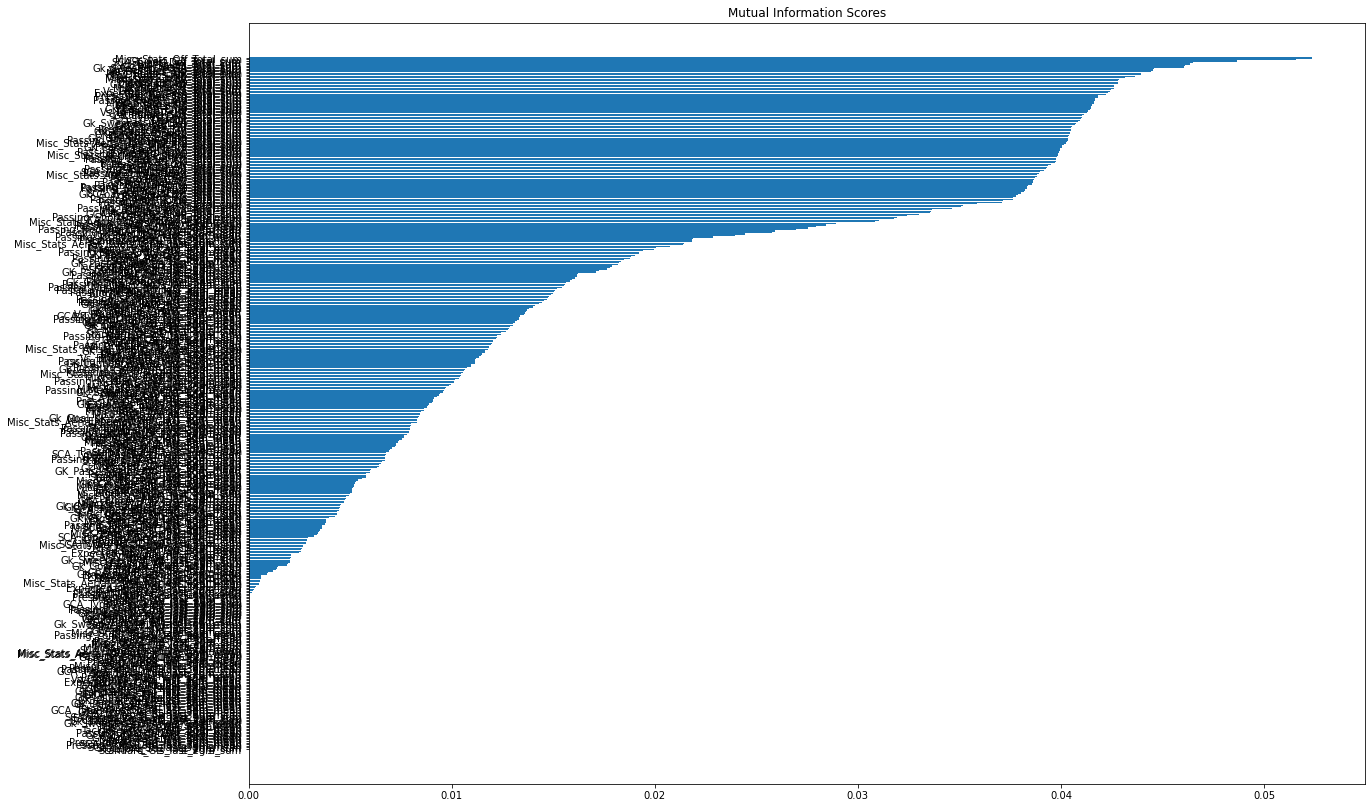

In [24]:
mi_scores_1 = make_mi_scores_Classif(X_train=df_ad2.loc[:,df_ad_new_cols].reset_index(drop=True), y_train=df_ad2['Lose'])
plot_mi_scores(scores=mi_scores_1)

In [25]:
topk_ads = mi_scores_1[mi_scores_1>0].index.to_list()

In [26]:
len(topk_ads)

354

In [30]:
get_explained_variance(df=df_ad2,cols=topk_ads,standardize=True,range_comp=20)

 Cummulative explained variance for 1 components: 0.4356737360279468

==============>>>>>>>>>>>>>>>
 Cummulative explained variance for 2 components: 0.5378110086987542

==============>>>>>>>>>>>>>>>
 Cummulative explained variance for 3 components: 0.610900770717501

==============>>>>>>>>>>>>>>>
 Cummulative explained variance for 4 components: 0.6753304836372319

==============>>>>>>>>>>>>>>>
 Cummulative explained variance for 5 components: 0.7006143974657247

==============>>>>>>>>>>>>>>>
 Cummulative explained variance for 6 components: 0.7205140627772703

==============>>>>>>>>>>>>>>>
 Cummulative explained variance for 7 components: 0.736283355968216

==============>>>>>>>>>>>>>>>
 Cummulative explained variance for 8 components: 0.7502708740530624

==============>>>>>>>>>>>>>>>
 Cummulative explained variance for 9 components: 0.7628499146832891

==============>>>>>>>>>>>>>>>
 Cummulative explained variance for 10 components: 0.7741865617220649

==============>>>>>>>>>>>>>>>
 

In [31]:
pca_ads, X_pca_ads, loadings_ads = apply_pca_ads(X=df_ad2[topk_ads],alias='advs', standardize=True,n_comps=20)

In [32]:
X_pca_ads.head()

,PC_advs1,PC_advs2,PC_advs3,PC_advs4,PC_advs5,PC_advs6,PC_advs7,PC_advs8,PC_advs9,PC_advs10,PC_advs11,PC_advs12,PC_advs13,PC_advs14,PC_advs15,PC_advs16,PC_advs17,PC_advs18,PC_advs19,PC_advs20
0,13.368159,-3.041397,25.756225,8.177072,12.045408,11.328643,38.716166,25.609959,6.102335,13.249283,39.980479,15.060102,19.668424,9.781806,-2.986597,14.353502,-9.111374,16.576913,-5.302832,7.413567
1,24.213216,11.787420,26.212193,9.381199,6.231454,0.997974,14.911177,9.133981,1.122012,7.922494,28.900493,9.579790,13.048788,5.710158,-1.123926,10.787345,-4.935311,7.660364,-5.133676,5.188388
2,29.293118,17.728090,25.528107,9.427566,-9.656375,4.385837,13.108967,3.713843,3.620517,8.067155,25.985389,4.366472,8.763787,7.856775,-2.597830,5.272010,-1.388310,2.416320,-5.167297,8.745038
3,28.664809,18.480854,33.400886,9.681482,-14.915604,1.491339,7.448605,3.355368,4.710173,-0.101117,20.091933,-1.386256,1.583739,6.578708,-5.951464,3.287601,3.196197,-3.458424,-3.839525,4.996714
4,24.179130,13.414128,36.986834,9.936182,-8.045422,0.249561,10.848007,5.017928,-0.199548,-2.461418,25.058070,1.014517,4.608409,7.567772,-5.429365,2.488532,4.672563,-5.635213,-1.879175,1.844312


In [33]:
X_pca_ads.shape

(3779, 20)

In [34]:
loadings_ads

,PC_advs1,PC_advs2,PC_advs3,PC_advs4,PC_advs5,PC_advs6,PC_advs7,PC_advs8,PC_advs9,PC_advs10,PC_advs11,PC_advs12,PC_advs13,PC_advs14,PC_advs15,PC_advs16,PC_advs17,PC_advs18,PC_advs19,PC_advs20
Misc_Stats_Off_Total_sum,-0.080235,0.006756,-0.001223,0.005071,-0.017657,-0.001104,-0.012643,-0.005424,-0.001882,-0.001430,-0.000310,0.001494,0.002868,0.001469,-0.002237,0.005358,-0.001740,0.003188,-0.001334,0.008228
GK_Perf_GA_Total_sum,-0.080014,0.007877,0.001967,0.007175,-0.026839,-0.000539,-0.013506,-0.004344,-0.002236,-0.000794,-0.002011,0.002284,0.003169,0.001899,-0.002039,0.006771,-0.002880,0.004995,0.000008,0.011418
SCA_Types_Def_Total_sum,-0.079708,0.009518,0.005390,0.009221,-0.033869,-0.001703,-0.018274,-0.005324,-0.003247,-0.000905,-0.000786,0.001774,0.003650,0.002708,-0.001708,0.008360,-0.002395,0.004003,-0.001705,0.009273
Blocks_Sh_Total_sum,-0.079874,0.008450,0.003071,0.008003,-0.032084,-0.000222,-0.013208,-0.003772,-0.002552,-0.000070,-0.002451,0.001868,0.002619,0.001888,-0.001836,0.005817,-0.002901,0.004067,-0.000310,0.010550
GK_Perf_Saves_Total_sum,-0.079942,0.008229,0.002395,0.007634,-0.029157,-0.000637,-0.015266,-0.005017,-0.002809,-0.000816,-0.001444,0.001661,0.003337,0.002019,-0.002224,0.006903,-0.002784,0.004062,-0.001074,0.010453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_Types_Sh_last_2gm_sum,-0.003225,-0.028567,0.020779,-0.008067,-0.018760,-0.088106,-0.000772,0.011878,0.054396,-0.020170,-0.005911,-0.006647,0.023801,0.000694,-0.020691,-0.017786,-0.014667,-0.039414,0.050681,0.000471
GK_Perf_Save%_last_2gm_sum,-0.002620,0.009294,-0.004176,0.010862,-0.016651,-0.091354,0.095518,-0.121533,-0.106126,0.078662,0.066889,-0.311071,0.127357,-0.069690,0.077004,0.008949,0.036409,0.044951,-0.041489,0.015091
GK_Perf_PSxG+/-_last_2gm_sum,-0.002859,0.002379,0.002108,0.006093,0.002958,-0.072915,0.102520,-0.113658,-0.083945,0.077233,0.021947,-0.249312,0.093068,-0.043696,0.071762,0.011809,0.069633,0.063494,0.010313,0.004594
Passing_Total_Att_last_3gm_mean,-0.011835,-0.123934,0.070137,-0.068965,0.004026,0.056999,-0.006992,0.043388,-0.150806,0.001936,-0.008218,-0.011606,-0.019687,0.024117,-0.015217,0.059177,0.008737,-0.012791,0.008019,-0.029431


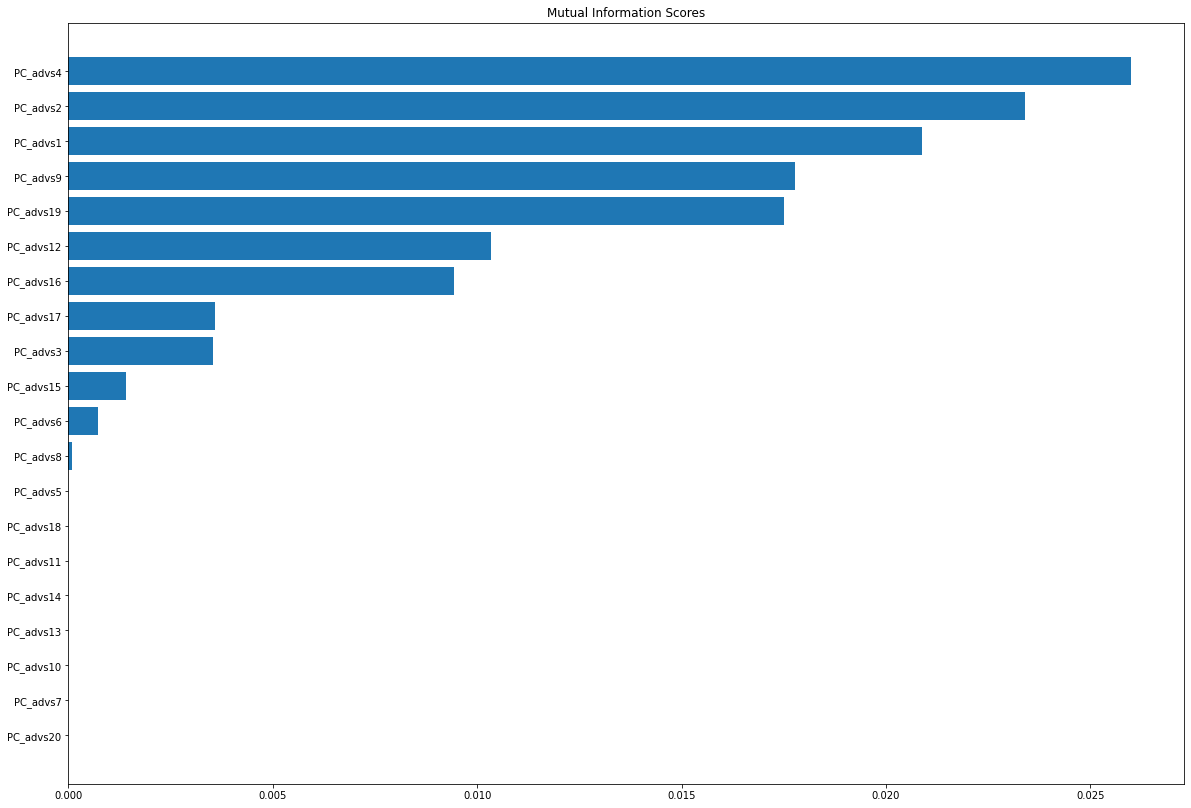

In [35]:
mi_scores_pca_ads = make_mi_scores_Classif(X_train=X_pca_ads.reset_index(drop=True), y_train=df_ad2['Lose'])
plot_mi_scores(scores=mi_scores_pca_ads)

In [36]:
topk_ads_pca = mi_scores_pca_ads[mi_scores_pca_ads>0].index.to_list()

In [37]:
topk_ads_pca

['PC_advs4',
 'PC_advs2',
 'PC_advs1',
 'PC_advs9',
 'PC_advs19',
 'PC_advs12',
 'PC_advs16',
 'PC_advs17',
 'PC_advs3',
 'PC_advs15',
 'PC_advs6',
 'PC_advs8']

In [38]:
pca_adv_df =X_pca_ads.loc[:,topk_ads_pca].reset_index(drop=True)
pca_adv_df

,PC_advs4,PC_advs2,PC_advs1,PC_advs9,PC_advs19,PC_advs12,PC_advs16,PC_advs17,PC_advs3,PC_advs15,PC_advs6,PC_advs8
0,8.177072,-3.041397,13.368159,6.102335,-5.302832,15.060102,14.353502,-9.111374,25.756225,-2.986597,11.328643,25.609959
1,9.381199,11.787420,24.213216,1.122012,-5.133676,9.579790,10.787345,-4.935311,26.212193,-1.123926,0.997974,9.133981
2,9.427566,17.728090,29.293118,3.620517,-5.167297,4.366472,5.272010,-1.388310,25.528107,-2.597830,4.385837,3.713843
3,9.681482,18.480854,28.664809,4.710173,-3.839525,-1.386256,3.287601,3.196197,33.400886,-5.951464,1.491339,3.355368
4,9.936182,13.414128,24.179130,-0.199548,-1.879175,1.014517,2.488532,4.672563,36.986834,-5.429365,0.249561,5.017928
...,...,...,...,...,...,...,...,...,...,...,...,...
3774,4.447633,-1.251635,-19.113851,-3.363499,1.271252,-1.606542,-2.892087,-0.621829,1.577935,-2.265419,4.147752,-0.984723
3775,4.779718,-0.925525,-19.139722,-2.379524,1.283182,-2.446902,-1.741126,0.930770,1.326768,-1.842207,5.613004,1.483190
3776,5.016903,-0.298356,-19.136191,-1.234709,0.080718,-1.798516,-1.558264,1.927377,0.950633,0.386753,1.690312,4.113361
3777,4.367905,1.006480,-19.006357,0.472332,0.159983,1.468591,1.270548,1.261227,0.738185,-0.364958,0.792448,5.164816


In [39]:
df4 = df_ad2.copy()

In [40]:
df4.head()

,Time,Comp,Day,Venue,Result,GF,GA,Opponent,Captain,Formation,Referee,Team,Season,Month,Win,Draw,Lose,Points,Total_Points,Total_GF,Total_GA,Total_Win,Total_Draw,Total_Loss,Points_Avg_for_szn,GF_Avg_for_szn,GA_Avg_for_szn,Win_Avg_for_szn,Draw_Avg_for_szn,Loss_Avg_for_szn,Away_Win,Away_Draw,Away_Loss,Home_Win,Home_Draw,Home_Loss,Points_last_1gm_sum,Win_last_1gm_sum,Draw_last_1gm_sum,Lose_last_1gm_sum,GF_last_1gm_sum,GA_last_1gm_sum,Away_Win_last_1gm_sum,Away_Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Home_Win_last_1gm_sum,Home_Draw_last_1gm_sum,Home_Loss_last_1gm_sum,Points_last_2gm_sum,Win_last_2gm_sum,Draw_last_2gm_sum,Lose_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Away_Win_last_2gm_sum,Away_Draw_last_2gm_sum,Away_Loss_last_2gm_sum,Home_Win_last_2gm_sum,Home_Draw_last_2gm_sum,Home_Loss_last_2gm_sum,Points_last_3gm_mean,Win_last_3gm_mean,Draw_last_3gm_mean,Lose_last_3gm_mean,GF_last_3gm_mean,GA_last_3gm_mean,Away_Win_last_3gm_mean,Away_Draw_last_3gm_mean,Away_Loss_last_3gm_mean,Home_Win_last_3gm_mean,Home_Draw_last_3gm_mean,Home_Loss_last_3gm_mean,Poss_last_3gm_mean,Rest,Played_Opp_X_times,GF_this_month_sum,GA_this_month_sum,Away_Win_this_month_sum,Away_Draw_this_month_sum,Away_Loss_this_month_sum,Home_Win_this_month_sum,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GF_sum_prev_month_,GA_sum_prev_month_,Away_Win_sum_prev_month_,Away_Draw_sum_prev_month_,Away_Loss_sum_prev_month_,Home_Win_sum_prev_month_,Home_Draw_sum_prev_month_,Home_Loss_sum_prev_month_,GF_this_month_mean,GA_this_month_mean,GF_mean_prev_month_,GA_mean_prev_month_,Poss_this_month_mean,Poss_mean_prev_month_,Captain_Rank,Poss_this_Venue_mean,GF_this_Venue_mean,GA_this_Venue_mean,Win_this_Venue_sum,Lose_this_Venue_sum,Draw_this_Venue_sum,GF_this_Venue_sum,GA_this_Venue_sum,Poss_this_Formation_mean,GF_this_Formation_mean,GA_this_Formation_mean,Win_this_Formation_sum,Lose_this_Formation_sum,Draw_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_sum,Poss_this_Opp_mean,GA_this_Opp_mean,GF_this_Opp_mean,Win_this_Opp_sum,Lose_this_Opp_sum,Draw_this_Opp_sum,GA_this_Opp_sum,GF_this_Opp_sum,First_Match_In_Month,First_Match_With_Formation,Matches_Played,Opponent_Count,Top7_Opp,Top7_Team,Top4_Opp,Top4_Team,Referee_Count,top20_Ref,top5_Ref,Ref_rank,Prev_comp,Prev_Opp,Captain_Count,Win_this_Comp_sum,Lose_this_Comp_sum,Draw_this_Comp_sum,GF_this_Comp_sum,GA_this_Comp_sum,Away_Win_this_Comp_sum,Away_Draw_this_Comp_sum,Away_Loss_this_Comp_sum,Home_Win_this_Comp_sum,Home_Draw_this_Comp_sum,Home_Loss_this_Comp_sum,Win_this_7_Opp_sum,Lose_this_7_Opp_sum,Draw_this_7_Opp_sum,GF_this_7_Opp_sum,GA_this_7_Opp_sum,Away_Win_this_7_Opp_sum,Away_Draw_this_7_Opp_sum,Away_Loss_this_7_Opp_sum,Home_Win_this_7_Opp_sum,Home_Draw_this_7_Opp_sum,Home_Loss_this_7_Opp_sum,Win_this_4_Opp_sum,Lose_this_4_Opp_sum,Draw_this_4_Opp_sum,GF_this_4_Opp_sum,GA_this_4_Opp_sum,Away_Win_this_4_Opp_sum,Away_Draw_this_4_Opp_sum,Away_Loss_this_4_Opp_sum,Home_Win_this_4_Opp_sum,Home_Draw_this_4_Opp_sum,Home_Loss_this_4_Opp_sum,Win_this_Ref_sum,Lose_this_Ref_sum,Draw_this_Ref_sum,GF_this_Ref_sum,GA_this_Ref_sum,Poss_this_Comp_mean,GF_this_Comp_mean,GA_this_Comp_mean,Win_this_Comp_mean,Lose_this_Comp_mean,Poss_this_7_Opp_mean,GF_this_7_Opp_mean,GA_this_7_Opp_mean,Win_this_7_Opp_mean,Lose_this_7_Opp_mean,Draw_this_7_Opp_mean,Poss_this_Ref_rank_mean,GF_this_Ref_rank_mean,GA_this_Ref_rank_mean,Win_this_Ref_rank_mean,Lose_this_Ref_rank_mean,Draw_this_Ref_rank_mean,Comp_code,Day_code,Venue_code,Opponent_code,Captain_code,Formation_code,Referee_code,Team_code,Prev_comp_code,Prev_Opp_code,Cyclic_Month,Na_count,Tot_Pts/Win,Tot_Pts/Loss,Tot_Pts/Draw,Tot_Pts/GF,Tot_Pts/GA,Tot_Win/Loss,Tot_Win/Draw,Tot_Draw/Loss,Tot_Win/GF,Tot_Loss/GA,Tot_Draw/GF,Tot_GF/GA,Tot_GF_GA_+-,Avg_Pts/Win,Avg_Pts/Loss,Avg_Pts/GF,Avg_Pts/GA,Avg_Win/GA,Avg_Win/GF,Avg_Win/Loss,Avg_Win/Draw,Avg_Loss/GA,Avg_Loss/GF,Avg_Draw/GF,Avg_Draw/GA,Avg_GF/GA,Avg_GF_GA+-,l2_Win/GA,l2_Win/GF,l2_Win/Loss,l2g_Win/Draw,l2g_Loss/GA,l2g_Loss/GF,l2g_Draw/GF,l2g_Dra

In [41]:
df4.shape, df_ad2.shape

((3779, 709), (3779, 709))

In [42]:
df4.isna().sum().sum(),df_ad2.isna().sum().sum()

(0, 0)

In [43]:
pca_adv_df = pd.concat([pca_adv_df,df4.loc[:,'Win	Draw	Lose	Points	Season'.split('	')].reset_index(drop=True)],axis=1)
pca_adv_df

,PC_advs4,PC_advs2,PC_advs1,PC_advs9,PC_advs19,PC_advs12,PC_advs16,PC_advs17,PC_advs3,PC_advs15,PC_advs6,PC_advs8,Win,Draw,Lose,Points,Season
0,8.177072,-3.041397,13.368159,6.102335,-5.302832,15.060102,14.353502,-9.111374,25.756225,-2.986597,11.328643,25.609959,1,0,0,3,2018
1,9.381199,11.787420,24.213216,1.122012,-5.133676,9.579790,10.787345,-4.935311,26.212193,-1.123926,0.997974,9.133981,0,1,0,1,2018
2,9.427566,17.728090,29.293118,3.620517,-5.167297,4.366472,5.272010,-1.388310,25.528107,-2.597830,4.385837,3.713843,1,0,0,3,2018
3,9.681482,18.480854,28.664809,4.710173,-3.839525,-1.386256,3.287601,3.196197,33.400886,-5.951464,1.491339,3.355368,1,0,0,3,2018
4,9.936182,13.414128,24.179130,-0.199548,-1.879175,1.014517,2.488532,4.672563,36.986834,-5.429365,0.249561,5.017928,0,0,1,0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3774,4.447633,-1.251635,-19.113851,-3.363499,1.271252,-1.606542,-2.892087,-0.621829,1.577935,-2.265419,4.147752,-0.984723,0,0,1,0,2022
3775,4.779718,-0.925525,-19.139722,-2.379524,1.283182,-2.446902,-1.741126,0.930770,1.326768,-1.842207,5.613004,1.483190,0,1,0,1,2022
3776,5.016903,-0.298356,-19.136191,-1.234709,0.080718,-1.798516,-1.558264,1.927377,0.950633,0.386753,1.690312,4.113361,0,0,1,0,2022
3777,4.367905,1.006480,-19.006357,0.472332,0.159983,1.468591,1.270548,1.261227,0.738185,-0.364958,0.792448,5.164816,0,1,0,1,2022


In [44]:
pca_idea = 'Tot_Pts/Win	Tot_Pts/Loss	Tot_Pts/Draw	Tot_Pts/GF	Tot_Pts/GA	Tot_Win/Loss	Tot_Win/Draw	Tot_Draw/Loss	Tot_Win/GF	Tot_Loss/GA	Tot_Draw/GF	Tot_GF/GA	Tot_GF_GA_+-	Avg_Pts/Win	Avg_Pts/Loss	Avg_Pts/GF	Avg_Pts/GA	Avg_Win/GA	Avg_Win/GF	Avg_Win/Loss	Avg_Win/Draw	Avg_Loss/GA	Avg_Loss/GF	Avg_Draw/GF	Avg_Draw/GA	Avg_GF/GA	Avg_GF_GA+-	l2_Win/GA	l2_Win/GF	l2_Win/Loss	l2g_Win/Draw	l2g_Loss/GA	l2g_Loss/GF	l2g_Draw/GF	l2g_Draw/GA	l2g_GF/GA	l2g_GF_GA+-	l3_Win/GA	l3_Win/Loss	l3g_Win/Draw	l3g_Loss/GA	l3g_Loss/GF	l3g_Draw/GF	l3g_Draw/GA	l3g_GF/GA	l3g_GF_GA+-	this_month_sum_Win/GA	this_month_sum_GF/GA	this_month_sum_GF_GA+-'.split('	')

In [45]:
pca_idea

['Tot_Pts/Win',
 'Tot_Pts/Loss',
 'Tot_Pts/Draw',
 'Tot_Pts/GF',
 'Tot_Pts/GA',
 'Tot_Win/Loss',
 'Tot_Win/Draw',
 'Tot_Draw/Loss',
 'Tot_Win/GF',
 'Tot_Loss/GA',
 'Tot_Draw/GF',
 'Tot_GF/GA',
 'Tot_GF_GA_+-',
 'Avg_Pts/Win',
 'Avg_Pts/Loss',
 'Avg_Pts/GF',
 'Avg_Pts/GA',
 'Avg_Win/GA',
 'Avg_Win/GF',
 'Avg_Win/Loss',
 'Avg_Win/Draw',
 'Avg_Loss/GA',
 'Avg_Loss/GF',
 'Avg_Draw/GF',
 'Avg_Draw/GA',
 'Avg_GF/GA',
 'Avg_GF_GA+-',
 'l2_Win/GA',
 'l2_Win/GF',
 'l2_Win/Loss',
 'l2g_Win/Draw',
 'l2g_Loss/GA',
 'l2g_Loss/GF',
 'l2g_Draw/GF',
 'l2g_Draw/GA',
 'l2g_GF/GA',
 'l2g_GF_GA+-',
 'l3_Win/GA',
 'l3_Win/Loss',
 'l3g_Win/Draw',
 'l3g_Loss/GA',
 'l3g_Loss/GF',
 'l3g_Draw/GF',
 'l3g_Draw/GA',
 'l3g_GF/GA',
 'l3g_GF_GA+-',
 'this_month_sum_Win/GA',
 'this_month_sum_GF/GA',
 'this_month_sum_GF_GA+-']

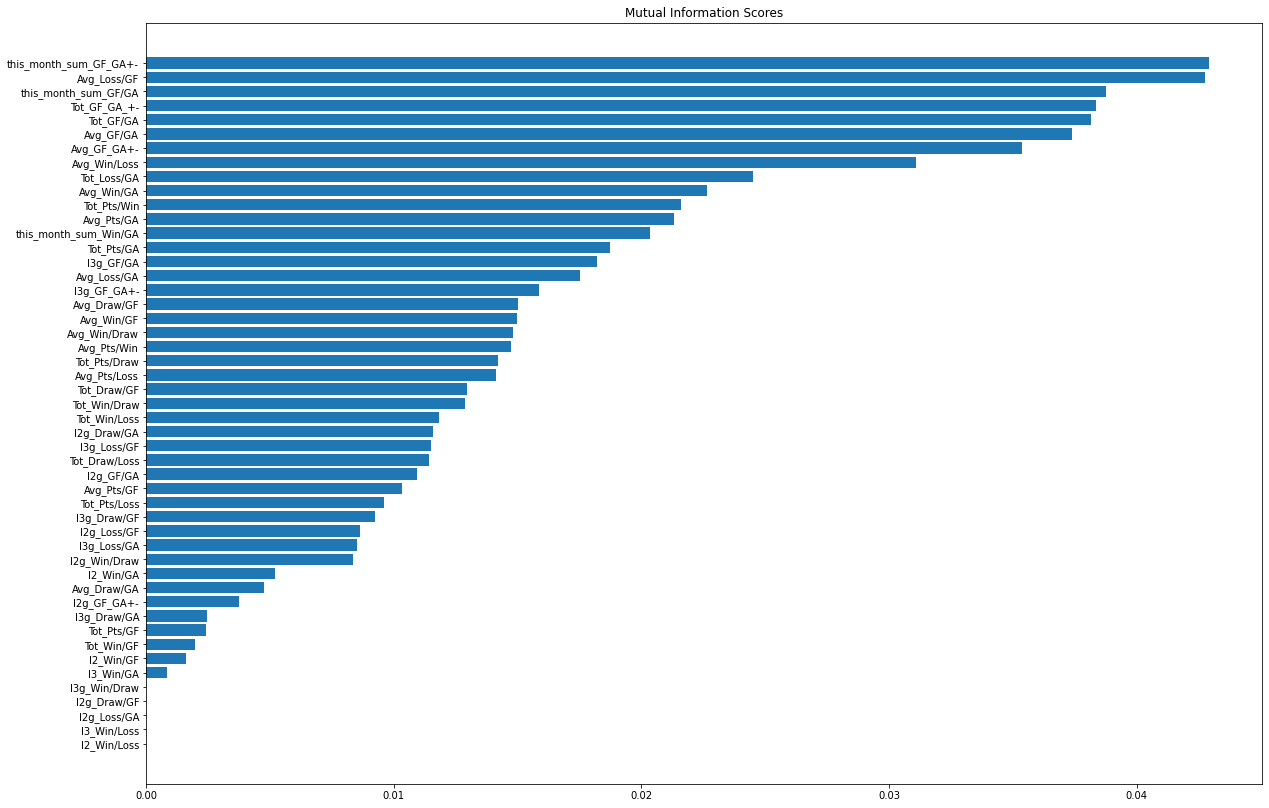

In [46]:
mi_scores_1 = make_mi_scores_Classif(X_train=df4.loc[:,pca_idea].reset_index(drop=True), y_train=df4['Lose'])
plot_mi_scores(scores=mi_scores_1)

In [47]:
pca_idea_df =df4.loc[:,pca_idea+'Win	Draw	Lose	Points	Season'.split('	')].reset_index(drop=True)
pca_idea_df

,Tot_Pts/Win,Tot_Pts/Loss,Tot_Pts/Draw,Tot_Pts/GF,Tot_Pts/GA,Tot_Win/Loss,Tot_Win/Draw,Tot_Draw/Loss,Tot_Win/GF,Tot_Loss/GA,Tot_Draw/GF,Tot_GF/GA,Tot_GF_GA_+-,Avg_Pts/Win,Avg_Pts/Loss,Avg_Pts/GF,Avg_Pts/GA,Avg_Win/GA,Avg_Win/GF,Avg_Win/Loss,Avg_Win/Draw,Avg_Loss/GA,Avg_Loss/GF,Avg_Draw/GF,Avg_Draw/GA,Avg_GF/GA,Avg_GF_GA+-,l2_Win/GA,l2_Win/GF,l2_Win/Loss,l2g_Win/Draw,l2g_Loss/GA,l2g_Loss/GF,l2g_Draw/GF,l2g_Draw/GA,l2g_GF/GA,l2g_GF_GA+-,l3_Win/GA,l3_Win/Loss,l3g_Win/Draw,l3g_Loss/GA,l3g_Loss/GF,l3g_Draw/GF,l3g_Draw/GA,l3g_GF/GA,l3g_GF_GA+-,this_month_sum_Win/GA,this_month_sum_GF/GA,this_month_sum_GF_GA+-,Win,Draw,Lose,Points,Season
0,4.000000,2.000000,4.000000,0.800000,0.444444,0.500000,1.000000,0.500000,0.200000,0.222222,0.200000,0.555556,-4.0,4.000000,2.000000,0.800000,0.444444,0.111111,0.200000,0.500000,1.000000,0.222222,0.400000,0.200000,0.111111,0.555556,-1.000000,0.0,0.000000,0.0,0.0,0.400000,0.000000,0.000000,0.000000,0.000000,-5.0,0.125000,0.5,0.0,0.250000,0.500000,0.000000,0.000000,0.500000,-1.333333,3.000000,7.750000,5.400000,1,0,0,3,2018
1,3.333333,5.000000,10.000000,0.909091,1.000000,1.500000,3.000000,0.500000,0.272727,0.200000,0.090909,1.100000,1.0,3.333333,5.000000,0.909091,1.000000,0.300000,0.272727,1.500000,3.000000,0.200000,0.181818,0.090909,0.100000,1.100000,0.166667,2.0,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,6.000000,5.0,0.400000,2.0,0.0,0.200000,0.166667,0.000000,0.000000,1.200000,0.333333,2.000000,6.000000,5.000000,0,1,0,1,2018
2,3.500000,7.000000,7.000000,1.166667,1.400000,2.000000,2.000000,1.000000,0.333333,0.200000,0.166667,1.200000,2.0,3.500000,7.000000,1.166667,1.400000,0.400000,0.333333,2.000000,2.000000,0.200000,0.166667,0.166667,0.200000,1.200000,0.250000,0.0,1.000000,0.0,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.0,2.000000,0.0,2.0,0.000000,0.000000,0.250000,1.000000,4.000000,1.000000,3.000000,7.000000,6.000000,1,0,0,3,2018
3,3.333333,10.000000,10.000000,1.111111,1.666667,3.000000,3.000000,1.000000,0.333333,0.166667,0.111111,1.500000,6.0,3.333333,10.000000,1.111111,1.666667,0.500000,0.333333,3.000000,3.000000,0.166667,0.111111,0.111111,0.166667,1.500000,0.600000,1.0,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3.000000,4.0,1.500000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3.500000,1.666667,0.461538,2.230769,3.200000,1,0,0,3,2018
4,3.285714,11.500000,11.500000,1.150000,1.916667,3.500000,3.500000,1.000000,0.350000,0.166667,0.100000,1.666667,8.0,3.285714,11.500000,1.150000,1.916667,0.583333,0.350000,3.500000,3.500000,0.166667,0.100000,0.100000,0.166667,1.666667,0.727273,1.0,0.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3.000000,4.0,1.500000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,0.000000,0.000000,2.000000,0,0,1,0,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3774,3.294118,3.733333,11.200000,1.333333,1.750000,1.133333,3.400000,0.333333,0.404762,0.468750,0.119048,1.312500,10.0,3.294118,3.733333,1.333333,1.750000,0.531250,0.404762,1.133333,3.400000,0.468750,0.357143,0.119048,0.156250,1.312500,0.270270,0.0,0.000000,0.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,-2.0,0.333333,0.5,0.0,0.666667,1.000000,0.000000,0.000000,0.666667,-0.333333,0.333333,0.666667,-1.000000,0,0,1,0,2022
3775,3.294118,3.500000,11.200000,1.333333,1.600000,1.062500,3.400000,0.312500,0.404762,0.457143,0.119048,1.200000,7.0,3.294118,3.500000,1.333333,1.600000,0.485714,0.404762,1.062500,3.400000,0.457143,0.380952,0.119048,0.142857,1.200000,0.184211,0.0,0.000000,0.0,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,-4.0,0.000000,0.0,0.0,0.600000,0.000000,0.000000,0.000000,0.000000,-1.666667,0.000000,0.529412,-2.666667,0,1,0,1,2022
3776,3.352941,3.562500,9.500000,1.295455,1.540541,1.062500,2.833333,0.375000,0.386364,0.432432,0.136364,1.189189,7.0,3.352941,3.562500,1.295455,1.540541,0.459459,0.38636

In [48]:
cluster_list = []

total_cols = 'Total_Points	Total_GF	Total_GA	Total_Win	Total_Draw	Total_Loss'.split('	')
cluster_list.append(total_cols)
total_cols

szn_avg = 'Points_Avg_for_szn	GF_Avg_for_szn	GA_Avg_for_szn	Win_Avg_for_szn	Draw_Avg_for_szn	Loss_Avg_for_szn'.split('	')
cluster_list.append(szn_avg)
szn_avg

roll_1game = 'Points_last_1gm_sum	Win_last_1gm_sum	Draw_last_1gm_sum	Lose_last_1gm_sum	GF_last_1gm_sum	GA_last_1gm_sum	Away_Win_last_1gm_sum	Away_Draw_last_1gm_sum	Away_Loss_last_1gm_sum	Home_Win_last_1gm_sum	Home_Draw_last_1gm_sum	Home_Loss_last_1gm_sum'.split('	')
cluster_list.append(roll_1game)
roll_1game

roll_2game = 'Points_last_2gm_sum	Win_last_2gm_sum	Draw_last_2gm_sum	Lose_last_2gm_sum	GF_last_2gm_sum	GA_last_2gm_sum	Away_Win_last_2gm_sum	Away_Draw_last_2gm_sum	Away_Loss_last_2gm_sum	Home_Win_last_2gm_sum	Home_Draw_last_2gm_sum	Home_Loss_last_2gm_sum'.split('	')
cluster_list.append(roll_2game)
roll_2game  

roll_3game = 'Points_last_3gm_mean	Win_last_3gm_mean	Draw_last_3gm_mean	Lose_last_3gm_mean	GF_last_3gm_mean	GA_last_3gm_mean	Away_Win_last_3gm_mean	Away_Draw_last_3gm_mean	Away_Loss_last_3gm_mean	Home_Win_last_3gm_mean	Home_Draw_last_3gm_mean	Home_Loss_last_3gm_mean	Poss_last_3gm_mean'.split('	')
cluster_list.append(roll_3game)
roll_3game

this_month = 'GF_this_month_sum	GA_this_month_sum	Away_Win_this_month_sum	Away_Draw_this_month_sum	Away_Loss_this_month_sum	Home_Win_this_month_sum	Home_Draw_this_month_sum	Home_Loss_this_month_sum'.split('	')
cluster_list.append(this_month)
this_month

prev_month = 'GF_sum_prev_month_	GA_sum_prev_month_	Away_Win_sum_prev_month_	Away_Draw_sum_prev_month_	Away_Loss_sum_prev_month_	Home_Win_sum_prev_month_	Home_Draw_sum_prev_month_	Home_Loss_sum_prev_month_'.split('	')
cluster_list.append(prev_month)
prev_month

this_prev_month_avg = 'GF_this_month_mean	GA_this_month_mean	GF_mean_prev_month_	GA_mean_prev_month_	Poss_this_month_mean	Poss_mean_prev_month_'.split('	')
cluster_list.append(this_prev_month_avg)
this_prev_month_avg

this_venue = 'Poss_this_Venue_mean	GF_this_Venue_mean	GA_this_Venue_mean	Win_this_Venue_sum	Lose_this_Venue_sum	Draw_this_Venue_sum	GF_this_Venue_sum	GA_this_Venue_sum'.split('	')
cluster_list.append(this_venue)
this_venue

this_formation = 'Poss_this_Formation_mean	GF_this_Formation_mean	GA_this_Formation_mean	Win_this_Formation_sum	Lose_this_Formation_sum	Draw_this_Formation_sum	GF_this_Formation_sum	GA_this_Formation_sum'.split('	')
cluster_list.append(this_formation)
this_formation

this_formation = 'Poss_this_Formation_mean	GF_this_Formation_mean	GA_this_Formation_mean	Win_this_Formation_sum	Lose_this_Formation_sum	Draw_this_Formation_sum	GF_this_Formation_sum	GA_this_Formation_sum'.split('	')
cluster_list.append(this_formation)
this_formation

this_opp = 'Poss_this_Opp_mean	GA_this_Opp_mean	GF_this_Opp_mean	Win_this_Opp_sum	Lose_this_Opp_sum	Draw_this_Opp_sum	GA_this_Opp_sum	GF_this_Opp_sum'.split('	')
cluster_list.append(this_opp)
this_opp

counts = [col for col in df4.columns if 'Count' in col]
cluster_list.append(counts)
counts

this_comp ='Win_this_Comp_sum	Lose_this_Comp_sum	Draw_this_Comp_sum	GF_this_Comp_sum	GA_this_Comp_sum	Away_Win_this_Comp_sum	Away_Draw_this_Comp_sum	Away_Loss_this_Comp_sum	Home_Win_this_Comp_sum	Home_Draw_this_Comp_sum	Home_Loss_this_Comp_sum'.split('	')
cluster_list.append(this_comp)
this_comp

top7_opp = 'Win_this_7_Opp_sum	Lose_this_7_Opp_sum	Draw_this_7_Opp_sum	GF_this_7_Opp_sum	GA_this_7_Opp_sum	Away_Win_this_7_Opp_sum	Away_Draw_this_7_Opp_sum	Away_Loss_this_7_Opp_sum	Home_Win_this_7_Opp_sum	Home_Draw_this_7_Opp_sum	Home_Loss_this_7_Opp_sum'.split('	')
cluster_list.append(top7_opp)
top7_opp

top4_opp = 'Win_this_4_Opp_sum	Lose_this_4_Opp_sum	Draw_this_4_Opp_sum	GF_this_4_Opp_sum	GA_this_4_Opp_sum	Away_Win_this_4_Opp_sum	Away_Draw_this_4_Opp_sum	Away_Loss_this_4_Opp_sum	Home_Win_this_4_Opp_sum	Home_Draw_this_4_Opp_sum	Home_Loss_this_4_Opp_sum'.split('	')
cluster_list.append(top4_opp)
top4_opp

this_ref = 'Win_this_Ref_sum	Lose_this_Ref_sum	Draw_this_Ref_sum	GF_this_Ref_sum	GA_this_Ref_sum'.split('	')
cluster_list.append(this_ref)
this_ref

this_comp_avg = 'Poss_this_Comp_mean	GF_this_Comp_mean	GA_this_Comp_mean	Win_this_Comp_mean	Lose_this_Comp_mean'.split('	')
cluster_list.append(this_comp_avg)
this_comp_avg

top7_opp_avg = 'Poss_this_7_Opp_mean	GF_this_7_Opp_mean	GA_this_7_Opp_mean	Win_this_7_Opp_mean	Lose_this_7_Opp_mean	Draw_this_7_Opp_mean'.split('	')
cluster_list.append(top7_opp_avg)
top7_opp_avg

this_Ref_rank = 'Poss_this_Ref_rank_mean	GF_this_Ref_rank_mean	GA_this_Ref_rank_mean	Win_this_Ref_rank_mean	Lose_this_Ref_rank_mean	Draw_this_Ref_rank_mean'.split('	')
cluster_list.append(this_Ref_rank)
this_Ref_rank

codes = 'Comp_code	Day_code	Venue_code	Opponent_code	Captain_code	Formation_code	Referee_code	Team_code	Prev_comp_code	Prev_Opp_code'.split('	')
cluster_list.append(codes)
codes

others1 = ['Time','Month','Rest','Played_Opp_X_times','Captain_Rank','First_Match_In_Month','Matches_Played','Opponent_Count',]
cluster_list.append(others1)

others2 = 'Top7_Opp	Top7_Team	Top4_Opp	Top4_Team	Referee_Count	top20_Ref	top5_Ref	Ref_rank'.split('	')
cluster_list.append(others2)

cluster_list_name = ['total','szn_avg','last1g','last2g','last3g','this_month_sum','prev_month_sum','this_month_avg',
                     'this_venue_avg','this_formation','this_Opp','counts','this_comp_sum','top7_opp','top4_opp',
                    'this_ref','others','this_comp_avg','top7_opp_avg','ref_rank_avg','codes','others1','others2']

len(cluster_list),len(cluster_list_name)

(23, 23)

In [49]:
targets = ['Win','Draw','Lose','Points']

X_total


,PC_total1,PC_total2,PC_total3,PC_total4,PC_total5,PC_total6
Total_Points,0.471714,-0.299215,0.067714,0.259911,0.297820,-7.260311e-01
Total_GF,0.469415,-0.289964,0.107216,-0.361011,-0.744141,5.551115e-17
Total_GA,0.387941,0.482794,0.179603,-0.652015,0.398787,-2.081668e-16
Total_Win,0.451062,-0.351615,0.192171,0.258896,0.323636,6.813319e-01
Total_Draw,0.377655,0.239848,-0.878400,0.132237,-0.045943,9.308954e-02
Total_Loss,0.246084,0.641982,0.378347,0.540814,-0.302780,2.428613e-17




X_szn_avg


,PC_szn_avg1,PC_szn_avg2,PC_szn_avg3,PC_szn_avg4,PC_szn_avg5,PC_szn_avg6
Points_Avg_for_szn,0.477284,-0.016018,0.040056,-0.341406,3.864624e-01,7.102305e-01
GF_Avg_for_szn,0.428951,-0.070706,0.598196,0.673174,1.387779e-16,2.220446e-16
GA_Avg_for_szn,-0.396505,-0.202669,0.771584,-0.454276,-1.804112e-16,-1.110223e-16
Win_Avg_for_szn,0.469035,-0.177706,0.004858,-0.321854,4.039521e-01,-6.939995e-01
Draw_Avg_for_szn,-0.122825,0.897442,0.180009,0.012567,3.694247e-01,-1.023486e-01
Loss_Avg_for_szn,-0.442611,-0.341595,-0.113086,0.346646,7.422903e-01,5.883857e-02




X_last1g


,PC_last1g1,PC_last1g2,PC_last1g3,PC_last1g4,PC_last1g5,PC_last1g6,PC_last1g7,PC_last1g8,PC_last1g9,PC_last1g10,PC_last1g11,PC_last1g12
Points_last_1gm_sum,-0.452241,-0.043626,0.015350,-0.011839,-0.000193,-0.013249,0.222756,0.037944,-0.345776,-0.031179,6.841056e-01,3.917013e-01
Win_last_1gm_sum,-0.426275,-0.211097,0.016535,-0.006908,-0.001034,-0.046735,0.199959,0.059602,-0.317647,-0.187197,-9.723562e-02,-7.630782e-01
Draw_last_1gm_sum,0.053590,0.613236,-0.009211,-0.013805,0.003071,0.124083,0.009403,-0.089769,0.011366,0.568231,3.389972e-01,-3.991327e-01
Lose_last_1gm_sum,0.391201,-0.311011,-0.009038,0.018963,-0.001581,-0.058805,-0.213223,0.016085,0.316088,-0.296812,6.384557e-01,-3.239983e-01
GF_last_1gm_sum,-0.324247,-0.105013,-0.013557,-0.004197,0.020008,0.697261,-0.630111,-0.002286,0.003856,0.001210,-4.163336e-17,1.387779e-16
GA_last_1gm_sum,0.310131,-0.176805,0.004841,-0.015242,0.020230,0.687764,0.631556,0.002510,-0.001890,0.000958,-2.359224e-16,0.000000e+00
Away_Win_last_1gm_sum,-0.230636,-0.113193,0.749461,-0.005569,0.000015,-0.021399,0.101843,-0.478065,0.356484,0.076256,-2.498002e-16,3.885781e-16
Away_Draw_last_1gm_sum,0.035845,0.409602,-0.006596,-0.010644,0.703231,0.064029,0.006191,-0.266979,-0.081177,-0.504228,-6.002143e-16,8.534840e-16
Away_Loss_last_1gm_sum,0.271653,-0.219651,-0.007716,-0.648610,-0.002705,-0.050338,-0.155459,-0.437703,-0.465429,0.149287,-8.049117e-16,8.604228e-16
Home_Win_last_1gm_sum,-0.284641,-0.142105,-0.661271,-0.002972,-0.001249,-0.036740,0.148180,-0.526391,0.392490,0.083981,-3.330669e-16,5.551115e-16




X_last2g


,PC_last2g1,PC_last2g2,PC_last2g3,PC_last2g4,PC_last2g5,PC_last2g6,PC_last2g7,PC_last2g8,PC_last2g9,PC_last2g10,PC_last2g11,PC_last2g12
Points_last_2gm_sum,0.438909,-0.044939,0.001825,0.009956,-0.004962,-0.010342,-0.217193,0.020814,-0.360604,-0.043832,7.288296e-01,-3.071641e-01
Win_last_2gm_sum,0.415113,-0.204717,0.005202,0.008099,-0.003496,-0.041973,-0.198258,0.061318,-0.327022,-0.193146,-6.639395e-01,-3.946834e-01
Draw_last_2gm_sum,-0.050545,0.610499,-0.013182,0.003769,-0.003894,0.121318,-0.001705,-0.157753,-0.010835,0.571096,-1.068209e-01,-4.972399e-01
Lose_last_2gm_sum,-0.385807,-0.294744,0.005559,-0.011466,0.006827,-0.057240,0.205668,0.067489,0.345889,-0.274030,1.287673e-01,-7.089624e-01
GF_last_2gm_sum,0.325601,-0.108214,0.002934,-0.001905,-0.003395,0.686201,0.641376,-0.000998,0.003700,0.000494,1.942890e-16,-1.249001e-16
GA_last_2gm_sum,-0.310012,-0.166988,-0.000077,0.010382,-0.036089,0.700133,-0.620003,0.001369,-0.002371,0.000508,5.551115e-17,3.747003e-16
Away_Win_last_2gm_sum,0.252159,-0.116091,0.609738,0.251091,-0.328322,-0.036508,-0.115246,-0.473375,0.374152,0.040346,-1.387779e-16,-2.706169e-16
Away_Draw_last_2gm_sum,-0.025936,0.418525,-0.021506,-0.547502,-0.441647,0.074660,0.000362,-0.213407,-0.043707,-0.525228,-6.938894e-17,-3.295975e-17
Away_Loss_last_2gm_sum,-0.278536,-0.220129,-0.369571,0.341035,-0.422638,-0.056003,0.166355,-0.468358,-0.432578,0.071814,-5.828671e-16,-3.885781e-16
Home_Win_last_2gm_sum,0.281226,-0.145477,-0.560766,-0.224211,0.303378,-0.018891,-0.146736,-0.507884,0.401734,0.041913,-1.942890e-16,-5.204170e-16




X_last3g


,PC_last3g1,PC_last3g2,PC_last3g3,PC_last3g4,PC_last3g5,PC_last3g6,PC_last3g7,PC_last3g8,PC_last3g9,PC_last3g10,PC_last3g11,PC_last3g12,PC_last3g13
Points_last_3gm_mean,0.418073,-0.038733,0.004211,0.003050,0.128925,-0.007851,0.024145,-0.194870,0.050076,0.367345,-0.032689,-2.530025e-01,7.522753e-01
Win_last_3gm_mean,0.398169,-0.192497,0.003750,0.003001,0.130685,-0.008780,-0.004243,-0.178639,0.056982,0.340199,-0.183807,-4.532151e-01,-6.301793e-01
Draw_last_3gm_mean,-0.053276,0.614513,0.000486,-0.000767,-0.047368,0.006104,0.103629,-0.002410,-0.042773,-0.008982,0.602251,-4.875012e-01,-6.507166e-02
Lose_last_3gm_mean,-0.370691,-0.288473,-0.004275,-0.002504,-0.097929,0.004259,-0.077917,0.187211,-0.025129,-0.345746,-0.287747,-7.020886e-01,1.808913e-01
GF_last_3gm_mean,0.322880,-0.096165,0.009126,-0.004932,-0.200840,0.028163,0.650663,0.649521,-0.000814,-0.004580,0.001104,-6.938894e-17,5.551115e-17
GA_last_3gm_mean,-0.307694,-0.157297,0.014130,-0.010277,-0.112415,-0.017787,0.703930,-0.609747,0.002434,0.002646,0.001243,2.081668e-16,-5.551115e-17
Away_Win_last_3gm_mean,0.257493,-0.123132,0.221850,0.587973,0.070649,-0.375725,-0.000792,-0.109073,-0.495273,-0.326077,0.118013,-2.775558e-17,1.110223e-16
Away_Draw_last_3gm_mean,-0.026960,0.421196,-0.573770,-0.045073,-0.058135,-0.405760,0.079281,0.004733,-0.301651,0.090738,-0.465905,6.245005e-17,1.179612e-16
Away_Loss_last_3gm_mean,-0.275561,-0.206808,0.330601,-0.398659,-0.049979,-0.423468,-0.058004,0.162148,-0.399403,0.459697,0.175348,1.804112e-16,2.775558e-16
Home_Win_last_3gm_mean,0.278722,-0.134163,-0.205049,-0.549366,0.107160,0.345422,-0.004707,-0.140143,-0.524216,-0.346229,0.123799,-1.387779e-17,2.498002e-16




X_this_month_sum


,PC_this_month_sum1,PC_this_month_sum2,PC_this_month_sum3,PC_this_month_sum4,PC_this_month_sum5,PC_this_month_sum6,PC_this_month_sum7,PC_this_month_sum8
GF_this_month_sum,0.648964,0.139812,-0.002334,-0.037025,0.002912,0.041925,0.276618,0.692559
GA_this_month_sum,0.081028,0.690365,0.071496,0.022951,0.001010,-0.065842,0.563615,-0.434964
Away_Win_this_month_sum,0.489924,-0.046445,-0.118388,-0.030589,0.561617,-0.497291,-0.293216,-0.306885
Away_Draw_this_month_sum,0.132658,0.029044,0.583970,0.612462,-0.347128,-0.329824,-0.190109,0.001898
Away_Loss_this_month_sum,-0.146379,0.531816,-0.110148,-0.416558,-0.324596,-0.365464,-0.472307,0.219297
Home_Win_this_month_sum,0.526897,-0.006085,-0.190506,-0.046656,-0.474296,0.456301,-0.298381,-0.402088
Home_Draw_this_month_sum,0.055714,0.083497,0.750669,-0.445781,0.278498,0.341085,-0.179314,-0.040564
Home_Loss_this_month_sum,-0.111829,0.459359,-0.167082,0.497633,0.395219,0.423923,-0.373422,0.159922




X_prev_month_sum


,PC_prev_month_sum1,PC_prev_month_sum2,PC_prev_month_sum3,PC_prev_month_sum4,PC_prev_month_sum5,PC_prev_month_sum6,PC_prev_month_sum7,PC_prev_month_sum8
GF_sum_prev_month_,0.487759,0.466660,-0.011622,0.127098,0.053274,-0.046711,0.179361,0.700600
GA_sum_prev_month_,-0.323613,0.625580,-0.007808,0.271595,0.093506,0.080288,0.522737,-0.376374
Away_Win_sum_prev_month_,0.431600,0.199670,-0.167952,-0.177213,0.518613,0.497001,-0.292825,-0.335448
Away_Draw_sum_prev_month_,0.072687,-0.102761,0.568509,0.687980,-0.080598,0.359127,-0.228227,-0.009034
Away_Loss_sum_prev_month_,-0.390459,0.369921,-0.338891,-0.018747,-0.417389,0.345786,-0.508325,0.208148
Home_Win_sum_prev_month_,0.437633,0.326213,0.120748,-0.017703,-0.471410,-0.442997,-0.273250,-0.440487
Home_Draw_sum_prev_month_,0.015844,-0.120196,-0.595350,0.624137,0.257311,-0.363115,-0.202838,-0.045920
Home_Loss_sum_prev_month_,-0.348672,0.287658,0.405616,-0.123082,0.500312,-0.409540,-0.427245,0.124229




X_this_month_avg


,PC_this_month_avg1,PC_this_month_avg2,PC_this_month_avg3,PC_this_month_avg4,PC_this_month_avg5,PC_this_month_avg6
GF_this_month_mean,0.364852,-0.240421,0.707583,0.511010,0.207319,0.065525
GA_this_month_mean,-0.280519,0.780574,0.530225,-0.140793,-0.083813,0.063467
GF_mean_prev_month_,0.430095,0.208019,-0.091007,-0.410603,0.749535,0.181840
GA_mean_prev_month_,-0.353725,-0.525105,0.440961,-0.626702,0.077598,-0.076940
Poss_this_month_mean,0.475135,-0.047717,0.077959,-0.315628,-0.565613,0.588517
Poss_mean_prev_month_,0.502329,0.107788,0.096857,-0.240985,-0.249503,-0.778679




X_this_venue_avg


,PC_this_venue_avg1,PC_this_venue_avg2,PC_this_venue_avg3,PC_this_venue_avg4,PC_this_venue_avg5,PC_this_venue_avg6,PC_this_venue_avg7,PC_this_venue_avg8
Poss_this_Venue_mean,0.441043,-0.060161,0.196883,0.298348,-0.817961,0.070664,-0.005262,-0.002584
GF_this_Venue_mean,0.452568,-0.087237,0.351631,0.252714,0.371122,-0.650713,0.076412,-0.181840
GA_this_Venue_mean,-0.391383,0.128464,0.568292,0.545250,0.146388,0.370504,0.187489,-0.127313
Win_this_Venue_sum,0.433860,0.314120,0.055529,-0.291786,0.157976,0.438310,-0.051044,-0.636548
Lose_this_Venue_sum,-0.272640,0.464531,0.173445,-0.368545,-0.309049,-0.372993,0.535841,-0.149026
Draw_this_Venue_sum,0.038044,0.426561,-0.657831,0.569670,0.030499,-0.086263,0.170797,-0.147613
GF_this_Venue_sum,0.413481,0.375226,0.111227,-0.061898,0.215822,0.235416,0.288867,0.697562
GA_this_Venue_sum,-0.111808,0.578842,0.190676,0.022516,-0.061660,-0.200510,-0.746080,0.122208




X_this_formation


,PC_this_formation1,PC_this_formation2,PC_this_formation3,PC_this_formation4,PC_this_formation5,PC_this_formation6,PC_this_formation7,PC_this_formation8
Poss_this_Formation_mean,0.226792,-0.459228,0.086804,-0.839684,-0.114336,-0.108489,-0.011740,0.009495
GF_this_Formation_mean,0.168765,-0.488097,0.489986,0.304798,0.603720,-0.174196,-0.051167,0.053405
GA_this_Formation_mean,-0.110357,0.428745,0.813195,-0.116406,-0.287821,-0.173967,-0.119372,0.042520
Win_this_Formation_sum,0.462329,-0.141684,0.050689,0.225064,-0.374102,0.334213,-0.160440,0.659972
Lose_this_Formation_sum,0.313688,0.454848,-0.056818,-0.275062,0.517025,0.321336,-0.495037,-0.013930
Draw_this_Formation_sum,0.416718,0.187740,-0.257418,0.101243,-0.064939,-0.818345,-0.190998,0.064798
GF_this_Formation_sum,0.474659,-0.116959,0.111055,0.213592,-0.311700,0.198735,-0.113723,-0.743962
GA_this_Formation_sum,0.443623,0.301932,0.081846,-0.079334,0.175977,0.059007,0.814112,0.042599




X_this_Opp


,PC_this_Opp1,PC_this_Opp2,PC_this_Opp3,PC_this_Opp4,PC_this_Opp5,PC_this_Opp6,PC_this_Opp7,PC_this_Opp8
Poss_this_Formation_mean,0.226792,-0.459228,0.086804,-0.839684,-0.114336,-0.108489,-0.011740,0.009495
GF_this_Formation_mean,0.168765,-0.488097,0.489986,0.304798,0.603720,-0.174196,-0.051167,0.053405
GA_this_Formation_mean,-0.110357,0.428745,0.813195,-0.116406,-0.287821,-0.173967,-0.119372,0.042520
Win_this_Formation_sum,0.462329,-0.141684,0.050689,0.225064,-0.374102,0.334213,-0.160440,0.659972
Lose_this_Formation_sum,0.313688,0.454848,-0.056818,-0.275062,0.517025,0.321336,-0.495037,-0.013930
Draw_this_Formation_sum,0.416718,0.187740,-0.257418,0.101243,-0.064939,-0.818345,-0.190998,0.064798
GF_this_Formation_sum,0.474659,-0.116959,0.111055,0.213592,-0.311700,0.198735,-0.113723,-0.743962
GA_this_Formation_sum,0.443623,0.301932,0.081846,-0.079334,0.175977,0.059007,0.814112,0.042599




X_counts


,PC_counts1,PC_counts2,PC_counts3,PC_counts4,PC_counts5,PC_counts6,PC_counts7,PC_counts8
Poss_this_Opp_mean,-0.205962,0.009900,0.064525,0.972304,0.088626,0.003388,0.008829,-0.000243
GA_this_Opp_mean,0.382124,0.420065,0.253739,0.033254,0.352583,-0.376107,-0.477784,-0.343493
GF_this_Opp_mean,-0.389152,0.406568,0.251056,-0.072547,-0.369604,-0.351209,0.454882,-0.384835
Win_this_Opp_sum,-0.435343,0.216398,-0.283050,-0.127644,0.549886,0.449898,0.023772,-0.402356
Lose_this_Opp_sum,0.428881,0.234058,-0.285329,0.154535,-0.529461,0.464737,-0.065094,-0.394255
Draw_this_Opp_sum,0.019493,-0.428893,0.744746,-0.042165,0.000060,0.375722,-0.017922,-0.343159
GA_this_Opp_sum,0.375296,0.437574,0.276343,0.025693,0.275927,0.294688,0.542383,0.365376
GF_this_Opp_sum,-0.381355,0.425579,0.275467,-0.075131,-0.269042,0.297972,-0.515193,0.406607




X_this_comp_sum


,PC_this_comp_sum1,PC_this_comp_sum2,PC_this_comp_sum3
Opponent_Count,-0.706545,-0.071287,-0.704069
Referee_Count,-0.707496,0.049195,0.705003
Captain_Count,-0.015621,0.996242,-0.085193




X_top7_opp


,PC_top7_opp1,PC_top7_opp2,PC_top7_opp3,PC_top7_opp4,PC_top7_opp5,PC_top7_opp6,PC_top7_opp7,PC_top7_opp8,PC_top7_opp9,PC_top7_opp10,PC_top7_opp11
Win_this_Comp_sum,0.276029,0.414045,-0.087496,0.010974,-0.014490,-0.216217,-0.181113,0.077798,0.053182,0.809911,-0.000000e+00
Lose_this_Comp_sum,0.303641,-0.305518,-0.316075,-0.048689,0.017419,-0.192976,0.123086,-0.060777,0.808163,-0.051694,2.133282e-15
Draw_this_Comp_sum,0.328015,-0.125523,0.460599,0.072855,-0.010982,-0.034529,0.040064,0.006871,0.000245,0.000019,8.100774e-01
GF_this_Comp_sum,0.290437,0.365531,-0.114095,-0.088358,0.035937,0.518648,0.700298,-0.021574,-0.006017,0.001190,7.097918e-16
GA_this_Comp_sum,0.330645,-0.158582,-0.154499,-0.123377,0.081775,0.677422,-0.600398,0.019155,0.000810,-0.000482,-3.592470e-16
Away_Win_this_Comp_sum,0.265212,0.427970,-0.074462,0.024685,-0.540886,-0.153746,-0.215458,-0.491905,-0.018262,-0.368007,-4.041746e-16
Away_Draw_this_Comp_sum,0.325447,-0.083991,0.365238,0.657675,0.297599,0.012614,0.018767,-0.259546,0.002674,0.000212,-4.057672e-01
Away_Loss_this_Comp_sum,0.309273,-0.262869,-0.245019,-0.386142,0.382784,-0.287064,0.096257,-0.423150,-0.456022,0.030071,-1.184725e-15
Home_Win_this_Comp_sum,0.279323,0.394168,-0.096321,-0.000703,0.415290,-0.262346,-0.147327,0.537447,-0.031314,-0.452223,-2.896116e-16
Home_Draw_this_Comp_sum,0.315810,-0.159728,0.531430,-0.491086,-0.306338,-0.078182,0.058691,0.261985,-0.002094,-0.000167,-4.232346e-01




X_top4_opp


,PC_top4_opp1,PC_top4_opp2,PC_top4_opp3,PC_top4_opp4,PC_top4_opp5,PC_top4_opp6,PC_top4_opp7,PC_top4_opp8,PC_top4_opp9,PC_top4_opp10,PC_top4_opp11
Win_this_7_Opp_sum,0.301433,0.348156,-0.163425,0.004477,-0.047617,-0.159086,0.127225,0.208395,0.106888,0.095343,0.808389
Lose_this_7_Opp_sum,0.277042,-0.403237,-0.244866,-0.045611,0.028572,-0.236226,-0.032699,-0.070086,0.603071,-0.521500,-0.018713
Draw_this_7_Opp_sum,0.329461,-0.049065,0.486242,0.033027,0.043108,-0.000950,-0.028215,-0.031751,0.522125,0.598987,-0.128307
GF_this_7_Opp_sum,0.303472,0.334865,-0.201578,0.017737,-0.033219,0.182125,-0.141466,-0.836108,-0.031049,-0.002804,-0.022103
GA_this_7_Opp_sum,0.340409,-0.141429,-0.190637,-0.079914,0.103990,0.835400,-0.124769,0.310185,-0.006324,-0.027562,0.010169
Away_Win_this_7_Opp_sum,0.295318,0.356888,-0.155431,0.093965,-0.303255,-0.263459,-0.579249,0.354003,-0.061749,-0.021510,-0.354870
Away_Draw_this_7_Opp_sum,0.323014,-0.019584,0.406312,0.549283,0.481693,-0.077890,-0.075629,0.009658,-0.283113,-0.316668,0.064328
Away_Loss_this_7_Opp_sum,0.284103,-0.352906,-0.238476,-0.439761,0.413070,-0.323390,-0.148585,-0.039043,-0.376234,0.322619,0.006114
Home_Win_this_7_Opp_sum,0.303090,0.336918,-0.163405,-0.074034,0.145855,-0.074472,0.718133,0.151814,-0.020371,-0.047750,-0.440639
Home_Draw_this_7_Opp_sum,0.309996,-0.075256,0.531462,-0.488860,-0.448184,0.007862,0.090666,-0.043262,-0.255252,-0.309565,0.069260




X_this_ref


,PC_this_ref1,PC_this_ref2,PC_this_ref3,PC_this_ref4,PC_this_ref5,PC_this_ref6,PC_this_ref7,PC_this_ref8,PC_this_ref9,PC_this_ref10,PC_this_ref11
Win_this_4_Opp_sum,0.291154,0.379046,-0.102059,0.006406,-0.066383,-0.178965,-0.111871,-0.203416,0.104344,0.035882,0.811537
Lose_this_4_Opp_sum,0.297979,-0.334107,-0.293608,0.145729,0.001306,-0.210069,0.060409,0.085510,0.048442,0.795306,-0.046779
Draw_this_4_Opp_sum,0.324806,-0.125542,0.456976,-0.122949,0.028079,-0.012856,-0.023390,0.001462,0.800551,-0.039905,-0.104016
GF_this_4_Opp_sum,0.292519,0.372334,-0.121047,-0.015087,-0.012540,0.180984,0.159935,0.836224,0.007556,-0.051100,-0.022133
GA_this_4_Opp_sum,0.335645,-0.069756,-0.145285,0.130203,0.123612,0.862333,-0.110979,-0.265779,-0.033872,0.034911,0.014035
Away_Win_this_4_Opp_sum,0.285741,0.387297,-0.100829,-0.113396,-0.358541,-0.072777,0.570331,-0.396855,-0.032638,0.000887,-0.357270
Away_Draw_this_4_Opp_sum,0.321761,-0.098197,0.245020,-0.613876,0.520873,-0.086025,0.125725,-0.034989,-0.388062,0.038140,0.046493
Away_Loss_this_4_Opp_sum,0.305120,-0.272845,-0.195075,0.516803,0.374313,-0.257094,0.295767,-0.028377,-0.005982,-0.482109,0.019026
Home_Win_this_4_Opp_sum,0.292969,0.366945,-0.094971,0.107947,0.157964,-0.252991,-0.676793,-0.104233,-0.078667,-0.036006,-0.439879
Home_Draw_this_4_Opp_sum,0.307201,-0.154933,0.620372,0.327662,-0.431439,-0.020358,-0.080776,0.076864,-0.431923,0.011895,0.060941




X_others


,PC_others1,PC_others2,PC_others3,PC_others4,PC_others5
Win_this_Ref_sum,0.439762,0.539107,0.201024,0.363960,0.585744
Lose_this_Ref_sum,0.419874,-0.608124,0.403561,0.499300,-0.204273
Draw_this_Ref_sum,0.452297,-0.117917,-0.868097,0.163481,-0.034700
GF_this_Ref_sum,0.450559,0.480822,0.158163,-0.209497,-0.704913
GA_this_Ref_sum,0.471953,-0.307335,0.134607,-0.740011,0.342155




X_this_comp_avg


,PC_this_comp_avg1,PC_this_comp_avg2,PC_this_comp_avg3,PC_this_comp_avg4,PC_this_comp_avg5
Poss_this_Comp_mean,0.415950,0.556126,-0.712806,0.096225,-0.018916
GF_this_Comp_mean,0.451379,0.388223,0.544899,-0.042666,0.588901
GA_this_Comp_mean,-0.415641,0.676287,0.335273,0.289861,-0.416474
Win_this_Comp_mean,0.481061,0.018321,0.237938,-0.548738,-0.640716
Lose_this_Comp_mean,-0.468045,0.286891,-0.161152,-0.777038,0.262431




X_top7_opp_avg


,PC_top7_opp_avg1,PC_top7_opp_avg2,PC_top7_opp_avg3,PC_top7_opp_avg4,PC_top7_opp_avg5,PC_top7_opp_avg6
Poss_this_7_Opp_mean,0.440377,-0.096277,0.147693,0.880190,-0.015867,-9.122768e-17
GF_this_7_Opp_mean,0.432629,-0.217568,0.606644,-0.332387,0.535721,7.085661e-16
GA_this_7_Opp_mean,-0.427888,-0.211314,0.713314,0.062091,-0.509496,-1.647916e-16
Win_this_7_Opp_mean,0.475151,-0.132805,-0.085583,-0.246796,-0.493860,-6.666809e-01
Lose_this_7_Opp_mean,-0.457763,-0.282116,-0.054851,0.215502,0.450920,-6.768193e-01
Draw_this_7_Opp_mean,-0.022266,0.895273,0.301695,0.059833,0.077059,-3.121733e-01




X_ref_rank_avg


,PC_ref_rank_avg1,PC_ref_rank_avg2,PC_ref_rank_avg3,PC_ref_rank_avg4,PC_ref_rank_avg5,PC_ref_rank_avg6
Poss_this_Ref_rank_mean,0.365229,-0.118612,-0.786293,-0.470728,-0.112685,0.000000e+00
GF_this_Ref_rank_mean,0.456983,-0.192267,-0.205688,0.606069,0.587003,-1.326822e-16
GA_this_Ref_rank_mean,-0.414829,-0.294738,-0.414152,0.564183,-0.501221,2.049137e-16
Win_this_Ref_rank_mean,0.507606,-0.221216,0.288016,0.074745,-0.443879,6.386161e-01
Lose_this_Ref_rank_mean,-0.470802,-0.394923,-0.087004,-0.225705,0.439715,6.087031e-01
Draw_this_Ref_rank_mean,-0.079837,0.810675,-0.278192,0.190431,0.033586,4.707972e-01




X_codes


,PC_codes1,PC_codes2,PC_codes3,PC_codes4,PC_codes5,PC_codes6,PC_codes7,PC_codes8,PC_codes9,PC_codes10
Comp_code,-0.571761,-0.268863,-0.084810,-0.016904,-0.066322,-0.054559,-0.042425,-0.012074,-0.051304,-0.762476
Day_code,0.462211,0.157570,0.043982,0.136075,0.342497,0.223139,-0.218766,0.553574,0.095584,-0.458854
Venue_code,0.000078,0.008117,0.143450,0.923101,-0.349402,-0.002540,-0.053155,-0.044650,-0.017819,-0.003905
Opponent_code,0.457627,0.226112,0.146011,-0.051742,-0.042817,-0.026571,0.382444,-0.606313,-0.082091,-0.438517
Captain_code,-0.053130,-0.247472,0.418873,-0.142830,-0.271219,0.765868,0.259784,0.100856,0.033779,0.034144
Formation_code,-0.000549,-0.170850,0.572569,-0.024435,0.055533,-0.552396,0.441524,0.373090,0.003254,0.001515
Referee_code,0.226795,0.125441,0.055419,-0.318541,-0.782708,-0.209292,-0.355408,0.179418,0.015662,-0.114464
Team_code,0.034576,0.119058,-0.620399,0.052968,-0.253034,0.039634,0.637429,0.352401,-0.020149,-0.020596
Prev_comp_code,0.333159,-0.595497,-0.149695,0.015799,0.012279,-0.025792,-0.078647,0.017688,-0.709627,0.029077
Prev_Opp_code,-0.289098,0.613786,0.187915,-0.029718,0.030482,0.093729,-0.002277,0.133200,-0.689784,0.015184




X_others1


,PC_others11,PC_others12,PC_others13,PC_others14,PC_others15,PC_others16,PC_others17,PC_others18
Time,-0.004257,0.341113,-0.079007,0.010044,-0.917418,0.156688,-0.099874,-0.033160
Month,0.552378,-0.366355,-0.215272,0.015264,-0.146946,0.114014,0.206229,0.661033
Rest,-0.006517,-0.197643,0.654102,0.076134,-0.005634,0.725597,0.013340,-0.023397
Played_Opp_X_times,-0.467860,-0.454434,-0.197802,0.065484,-0.211370,0.023431,0.671462,-0.187336
Captain_Rank,0.010528,0.143406,-0.165935,0.966929,0.094326,0.088338,-0.011193,0.003538
First_Match_In_Month,0.032447,-0.186754,0.643455,0.221182,-0.243095,-0.652698,0.043584,0.118764
Matches_Played,-0.562939,0.392665,0.100068,-0.049725,0.106079,0.037736,0.134349,0.696923
Opponent_Count,-0.397318,-0.542425,-0.169877,0.056892,-0.113126,0.012909,-0.690204,0.162709




X_others2


,PC_others21,PC_others22,PC_others23,PC_others24,PC_others25,PC_others26,PC_others27,PC_others28
Top7_Opp,-0.272955,-0.239430,0.592683,0.093174,0.700709,0.074771,0.079654,0.072700
Top7_Team,0.010837,0.615164,0.284985,-0.209873,-0.087492,-0.086829,0.655409,0.226799
Top4_Opp,-0.258161,-0.228599,0.605122,0.138582,-0.696243,0.025234,-0.061524,-0.080880
Top4_Team,0.033112,0.625381,0.283156,-0.136582,0.098784,0.105489,-0.608368,-0.343472
Referee_Count,-0.500460,-0.029448,-0.086631,-0.442089,0.004894,-0.677659,-0.223314,0.191336
top20_Ref,-0.435584,-0.099719,-0.175988,-0.570205,-0.036435,0.604388,0.150956,-0.234131
top5_Ref,-0.459383,0.183748,-0.214970,0.476764,0.056538,-0.210379,0.269097,-0.601514
Ref_rank,-0.454322,0.276248,-0.190976,0.401910,-0.047868,0.326097,-0.212434,0.604580


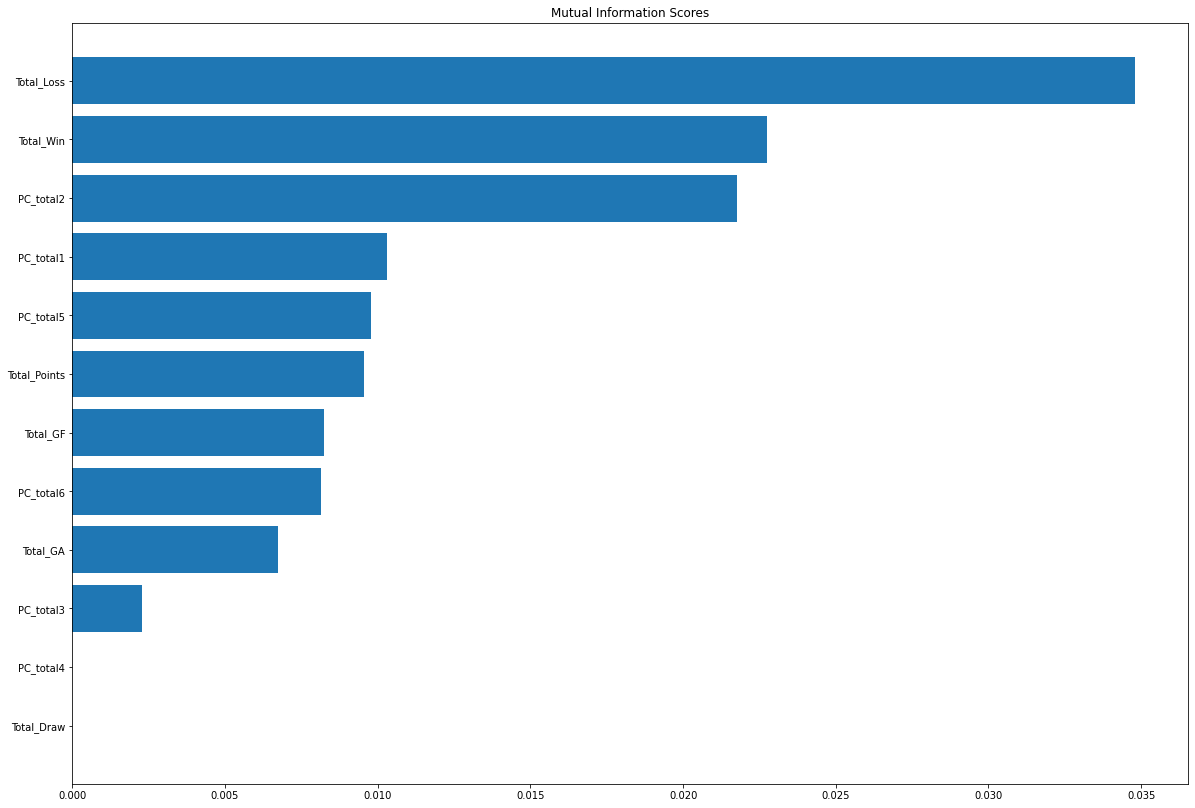

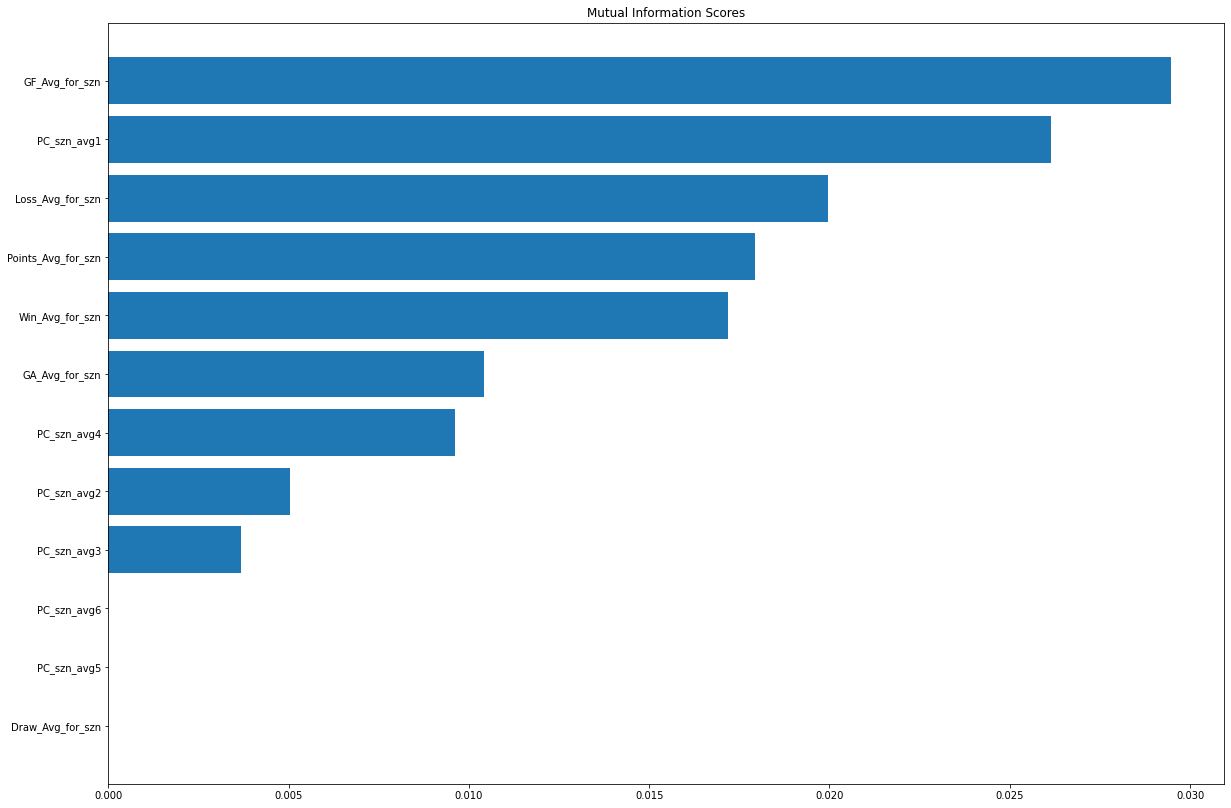

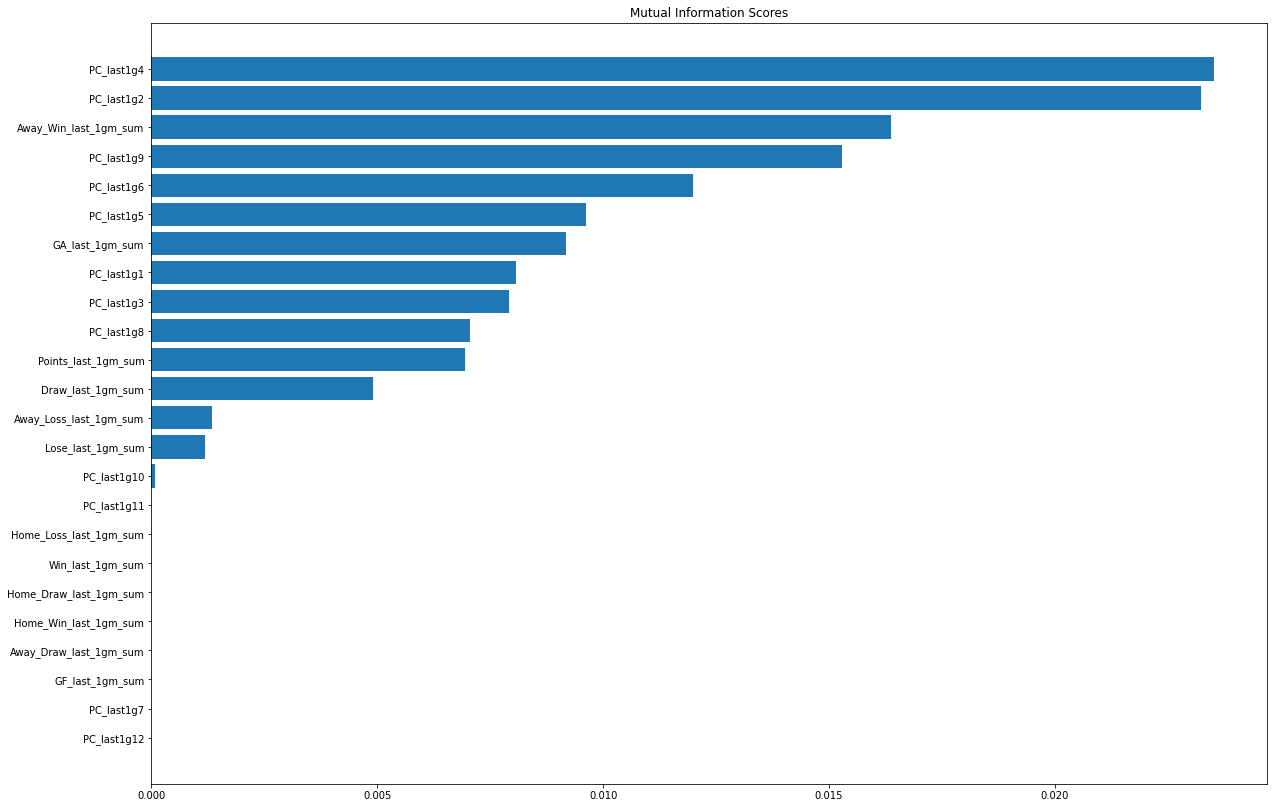

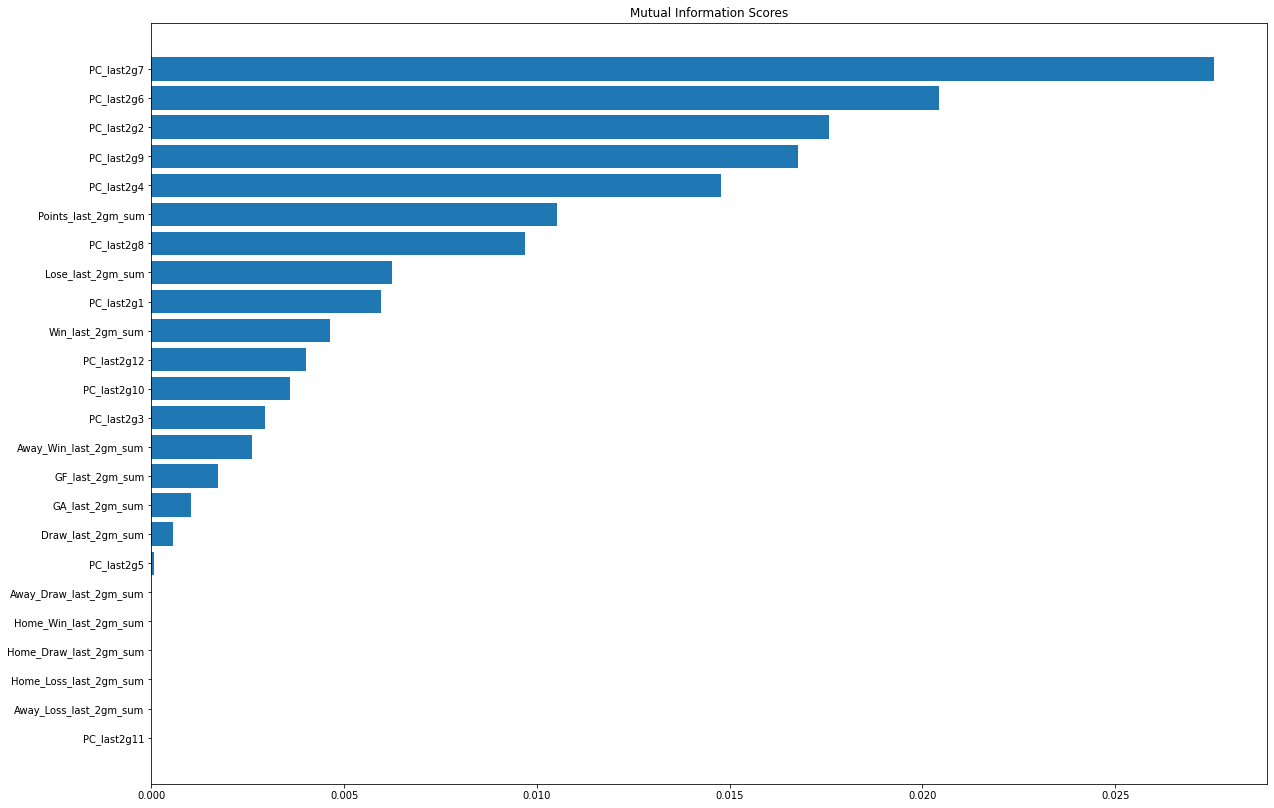

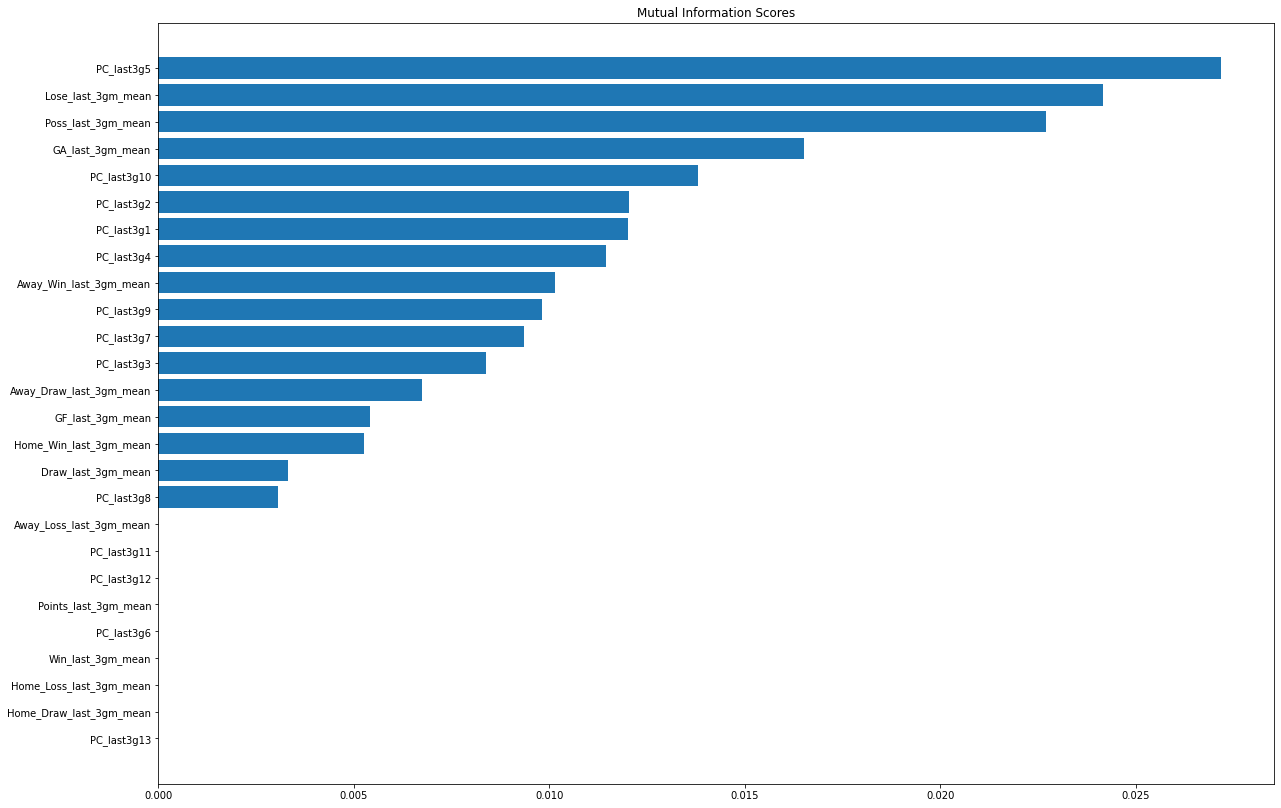

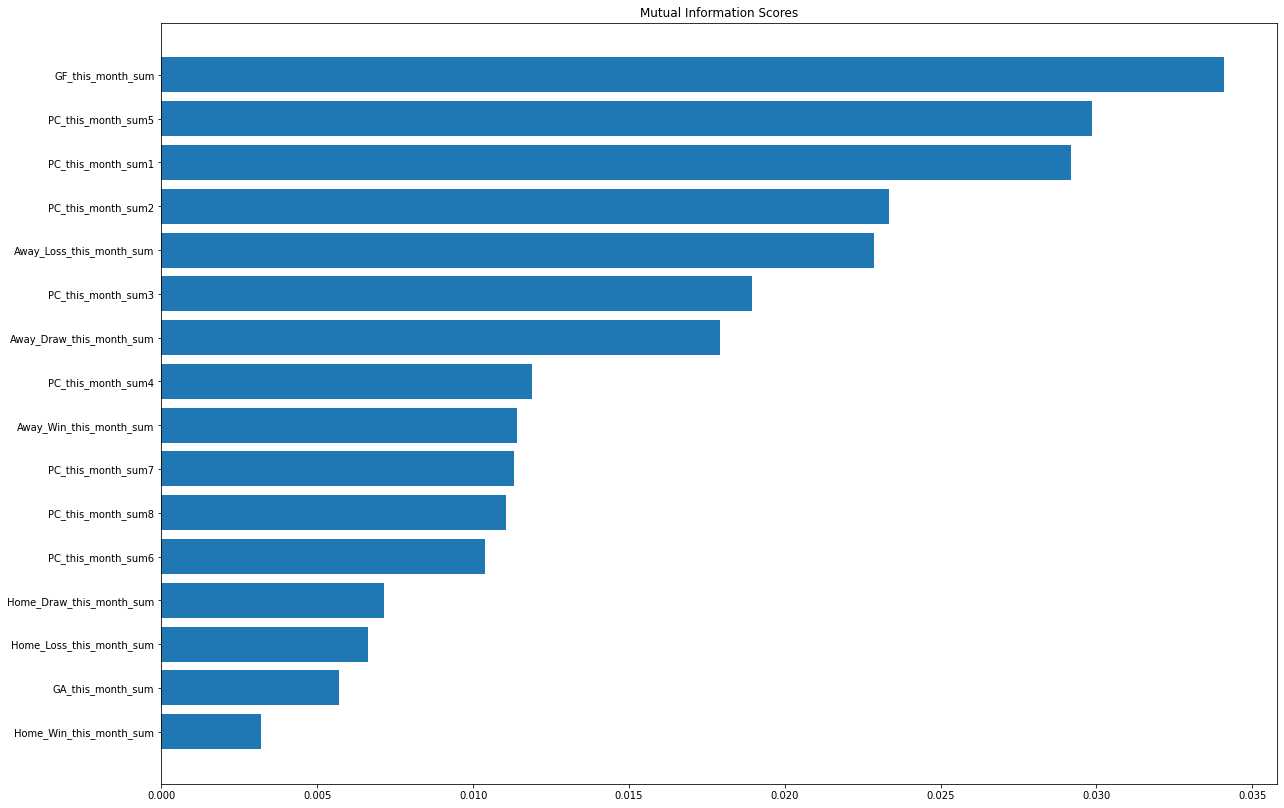

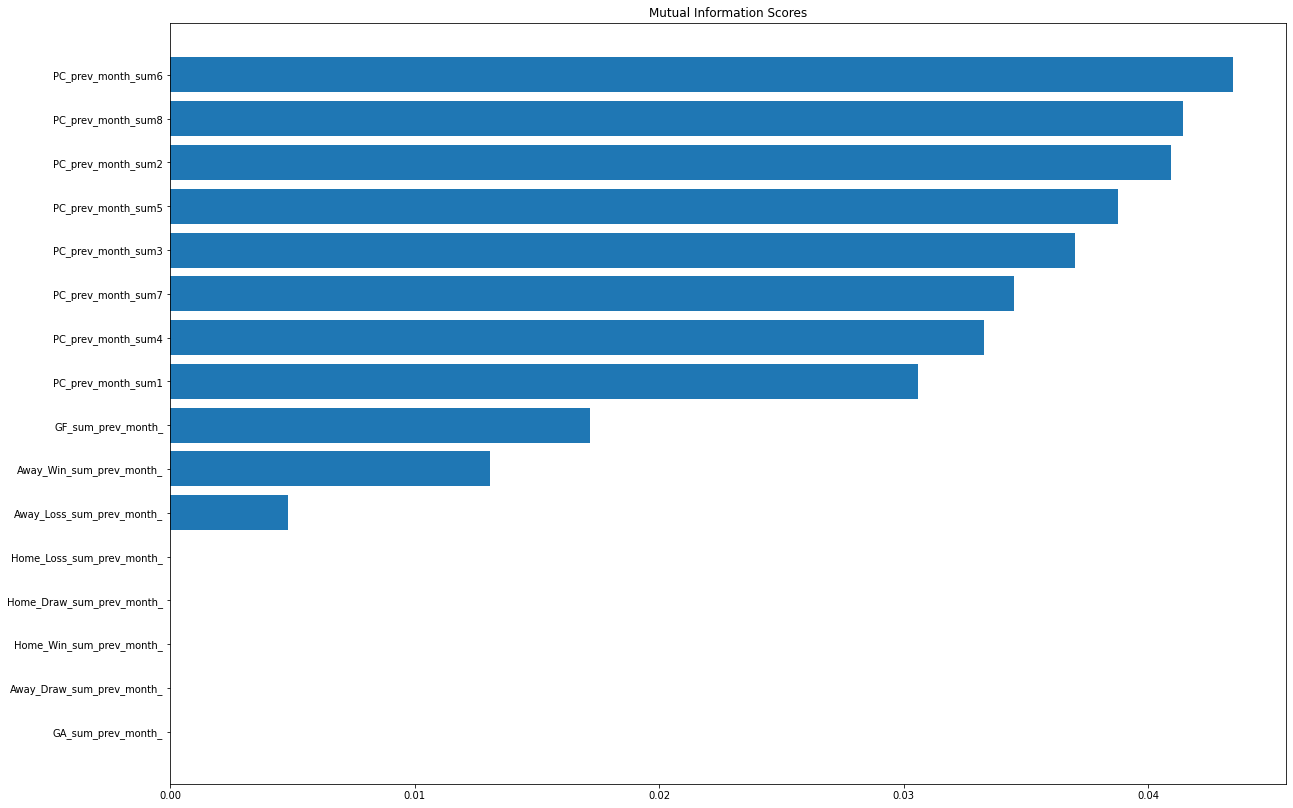

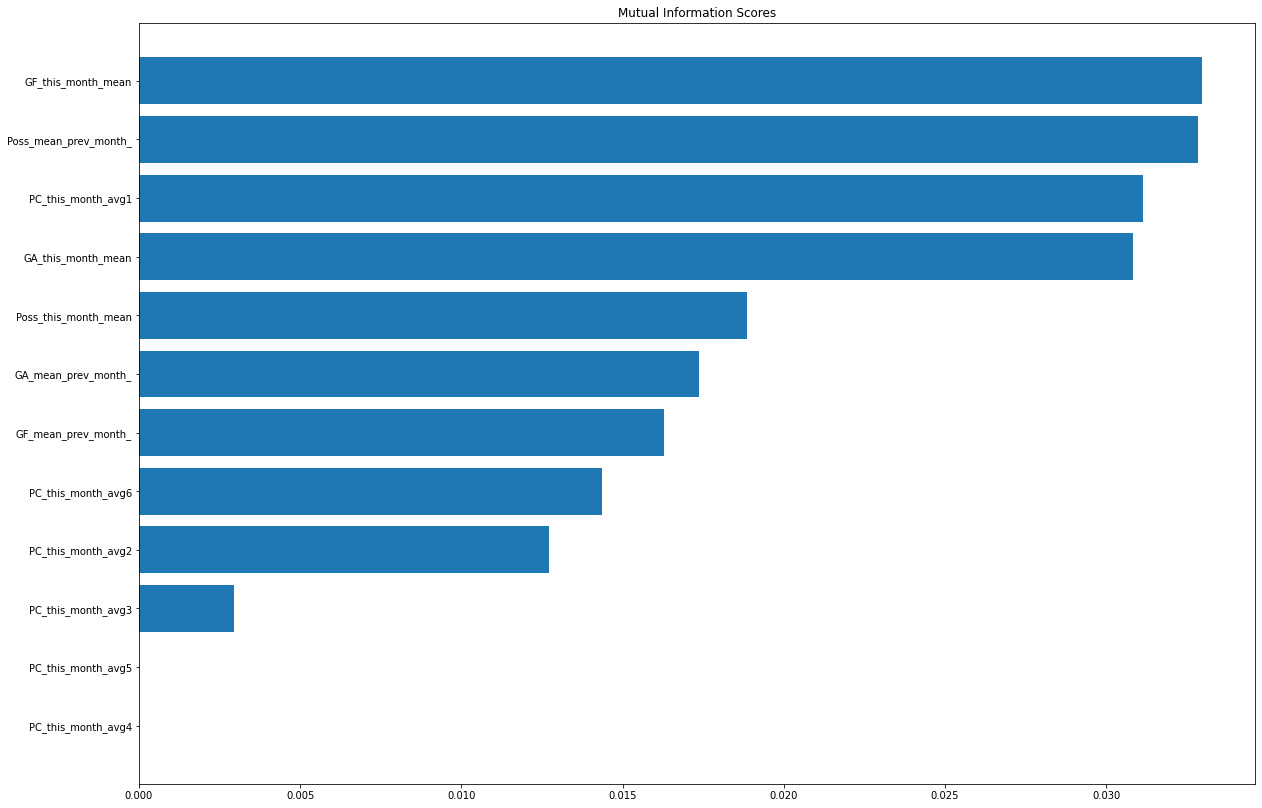

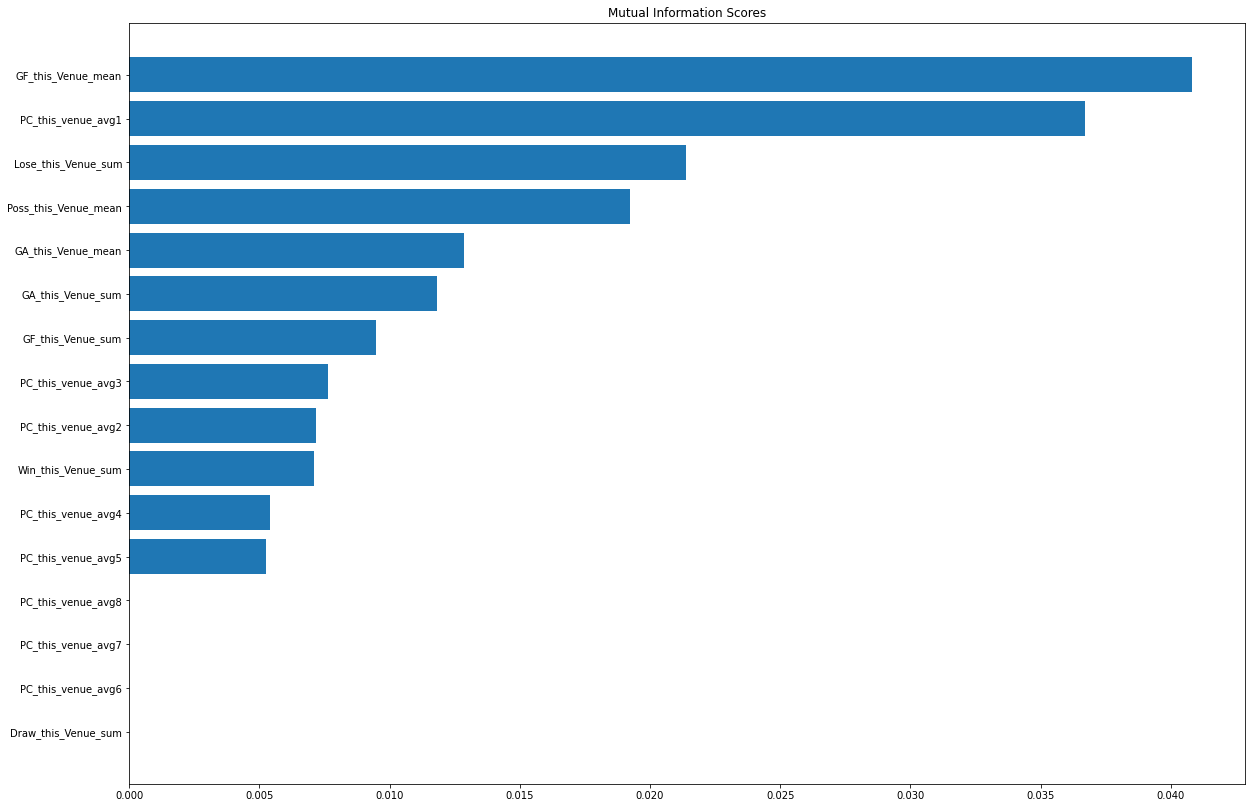

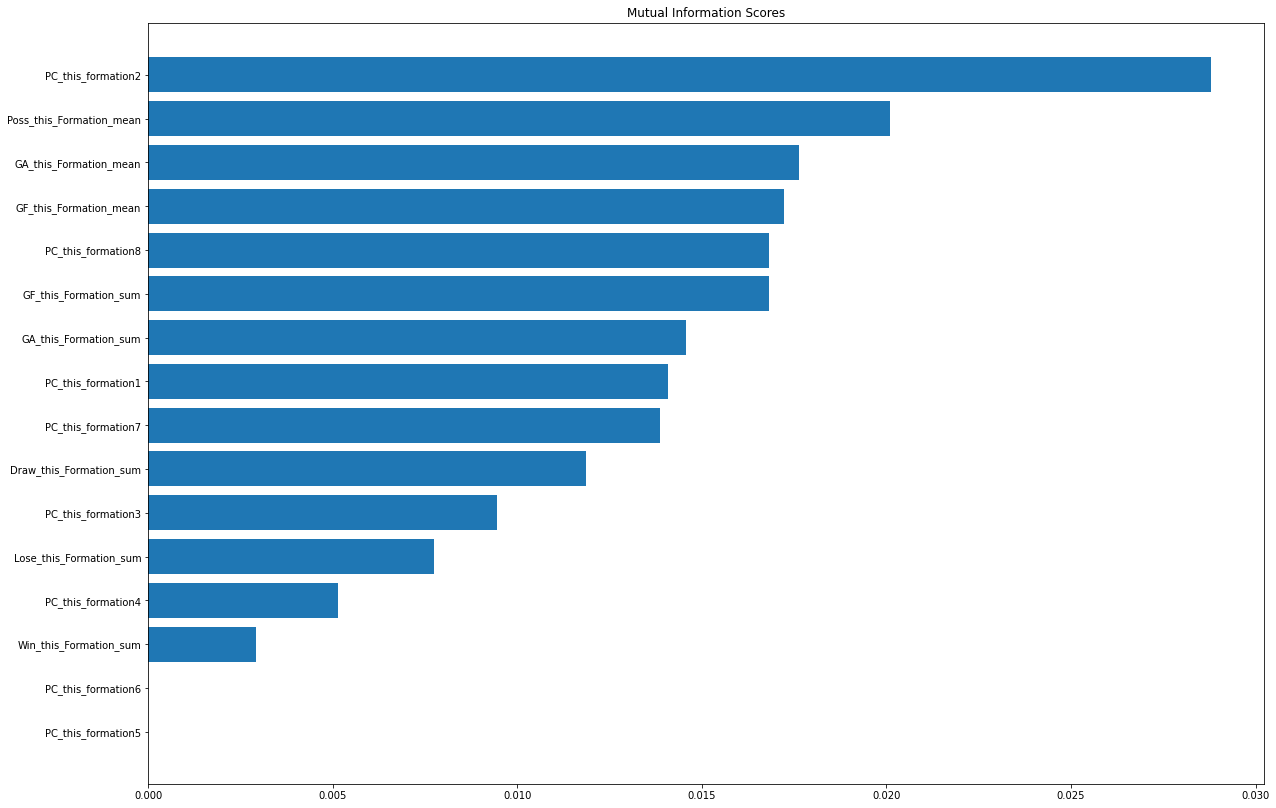

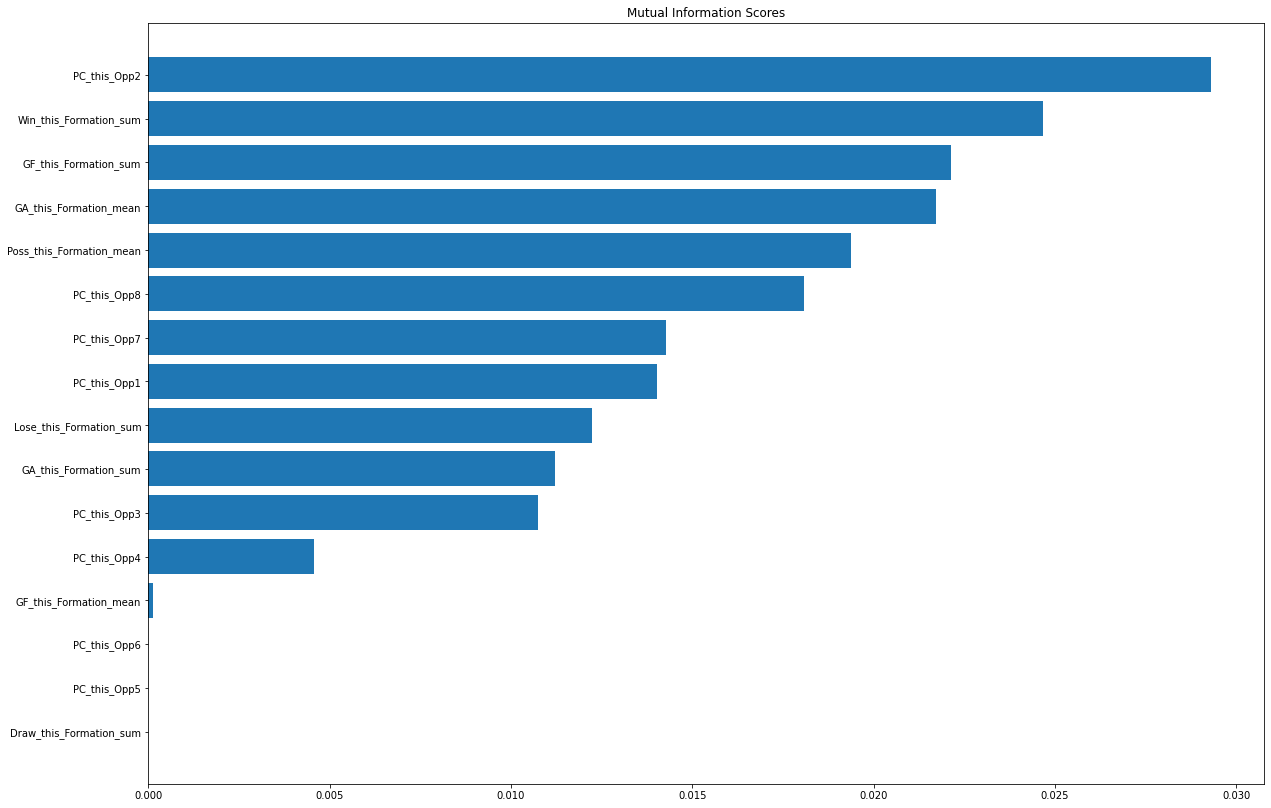

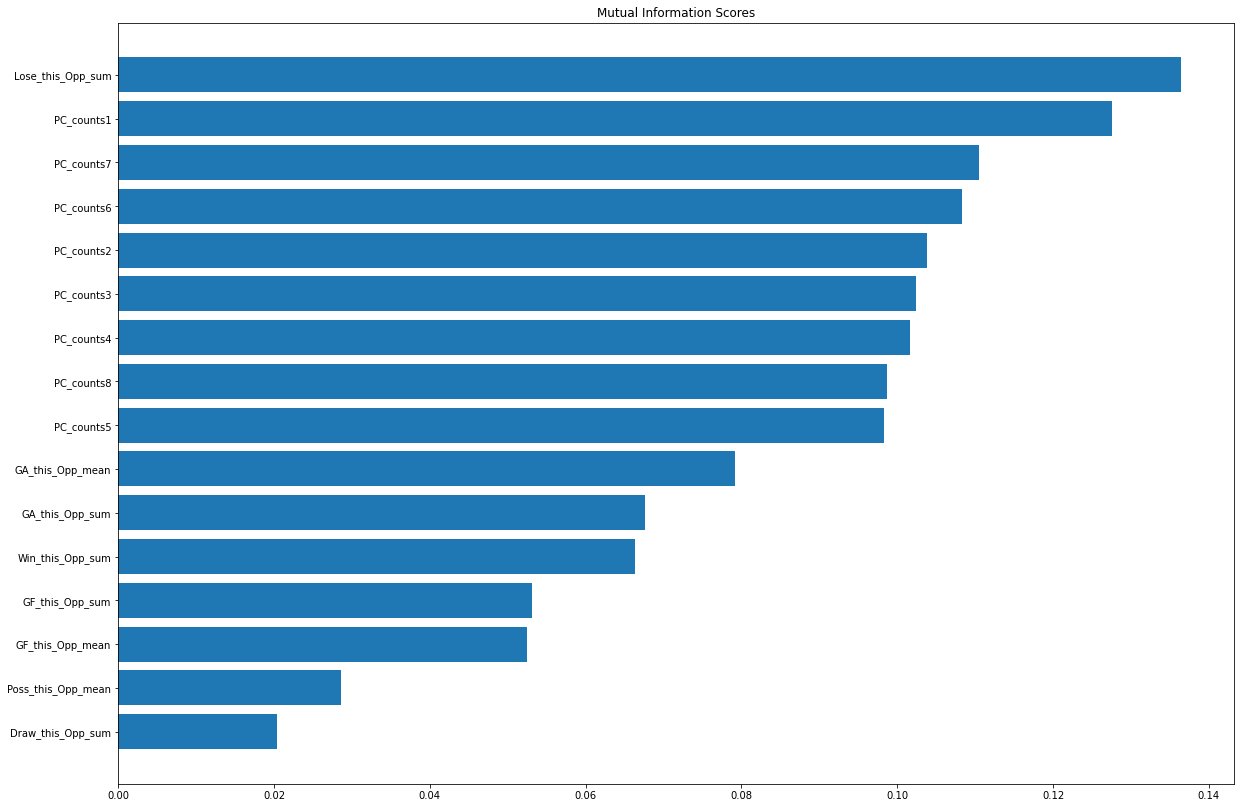

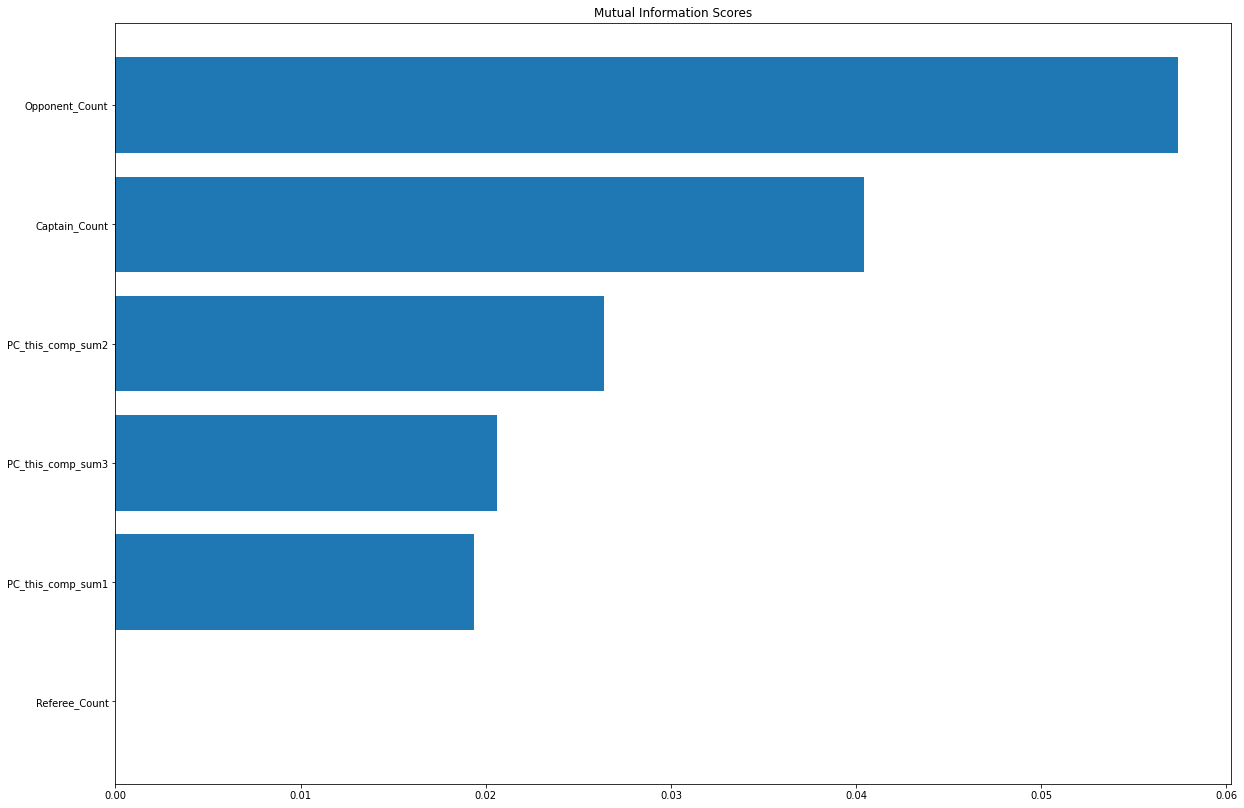

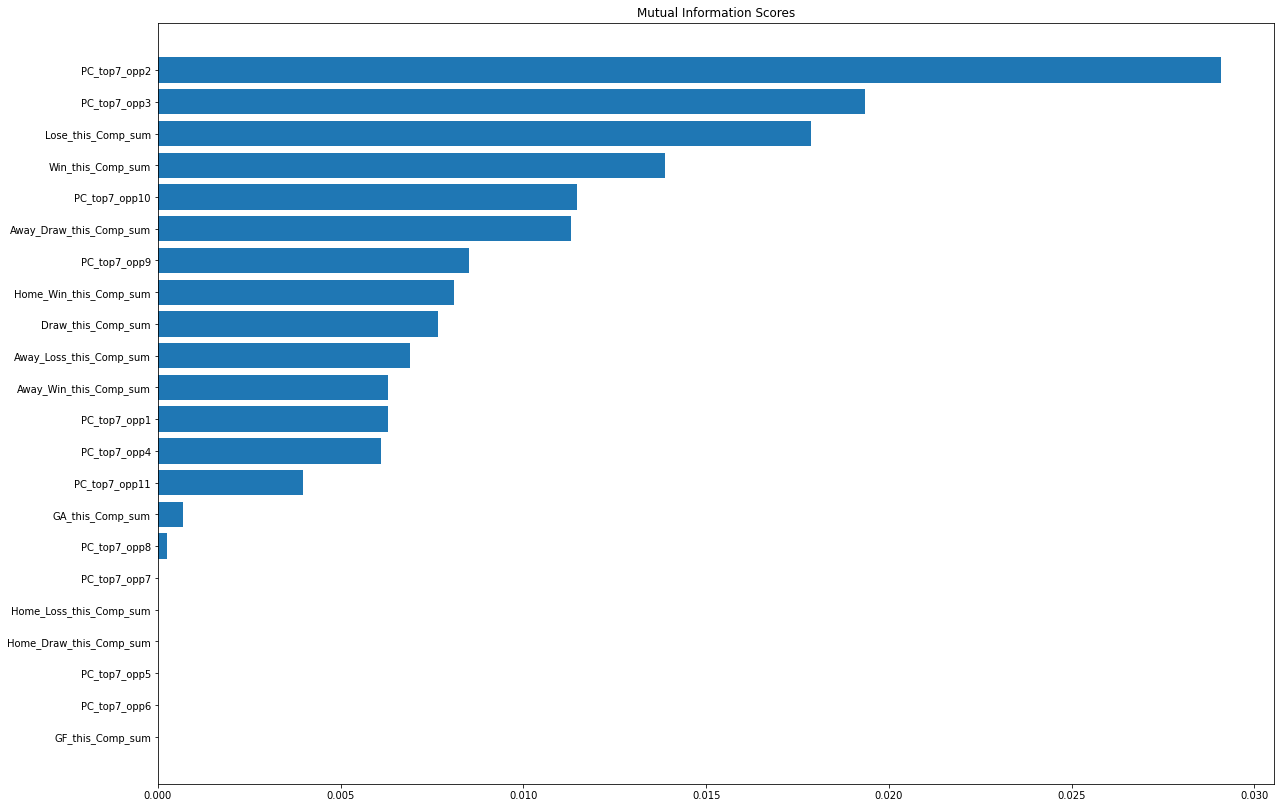

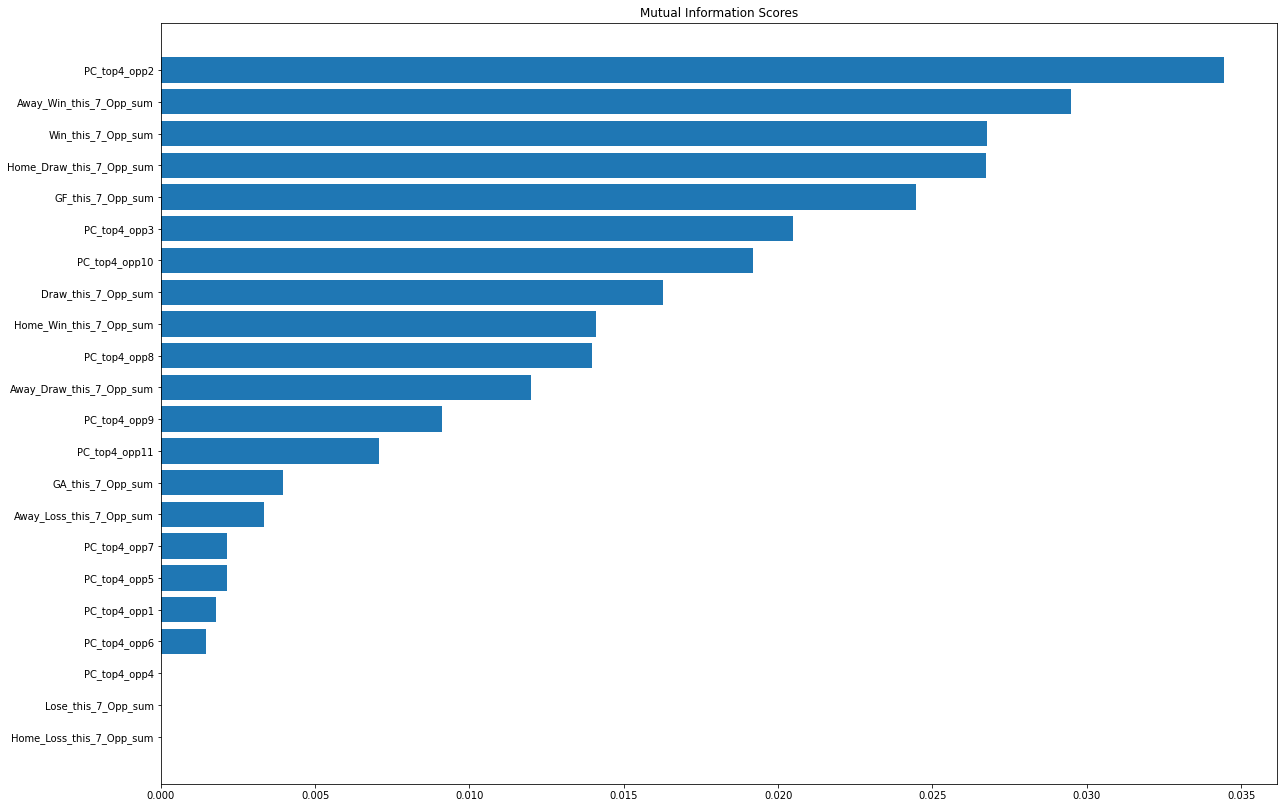

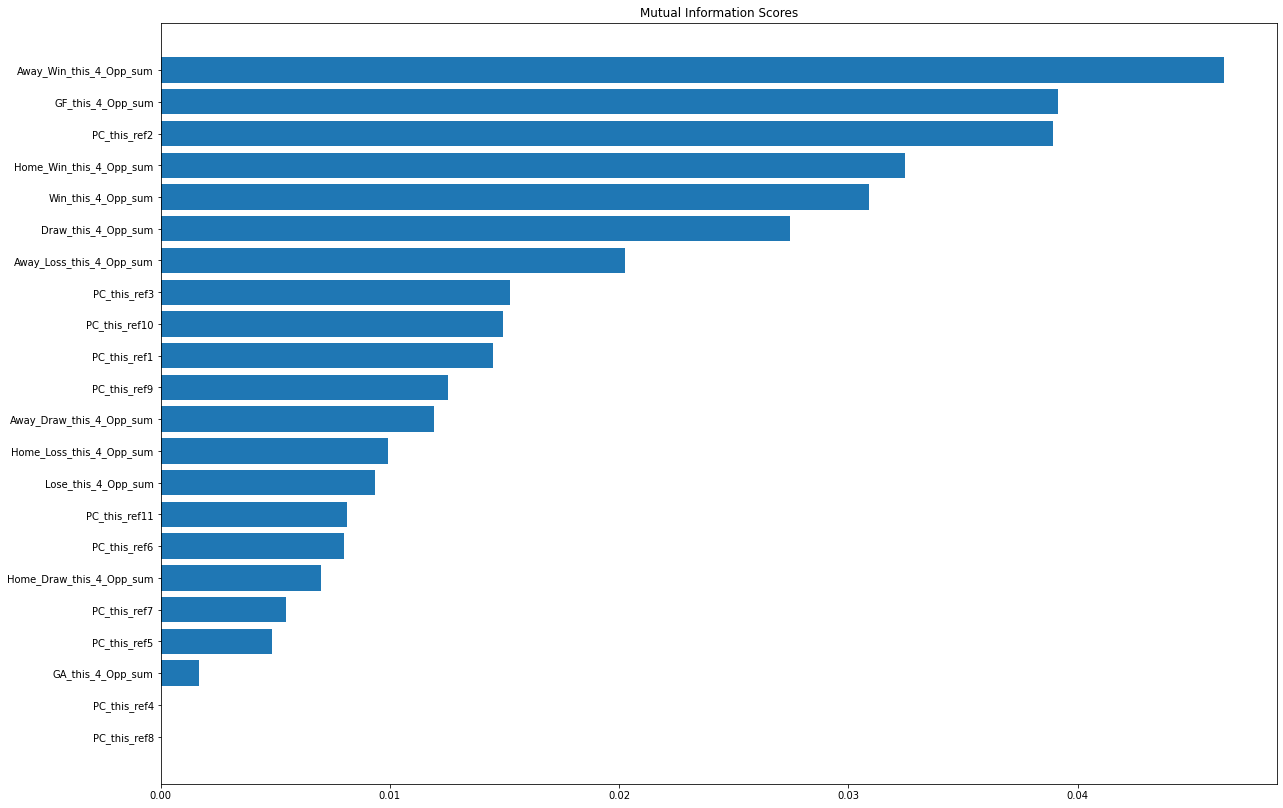

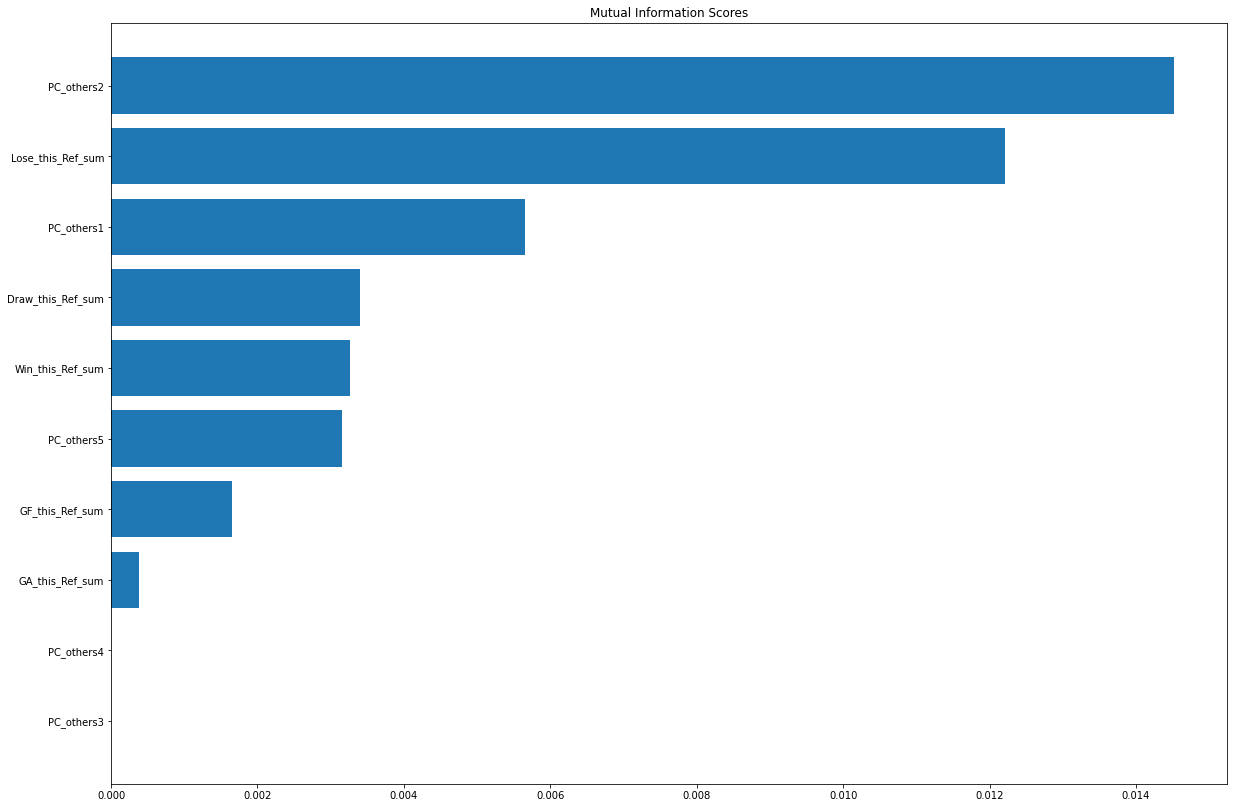

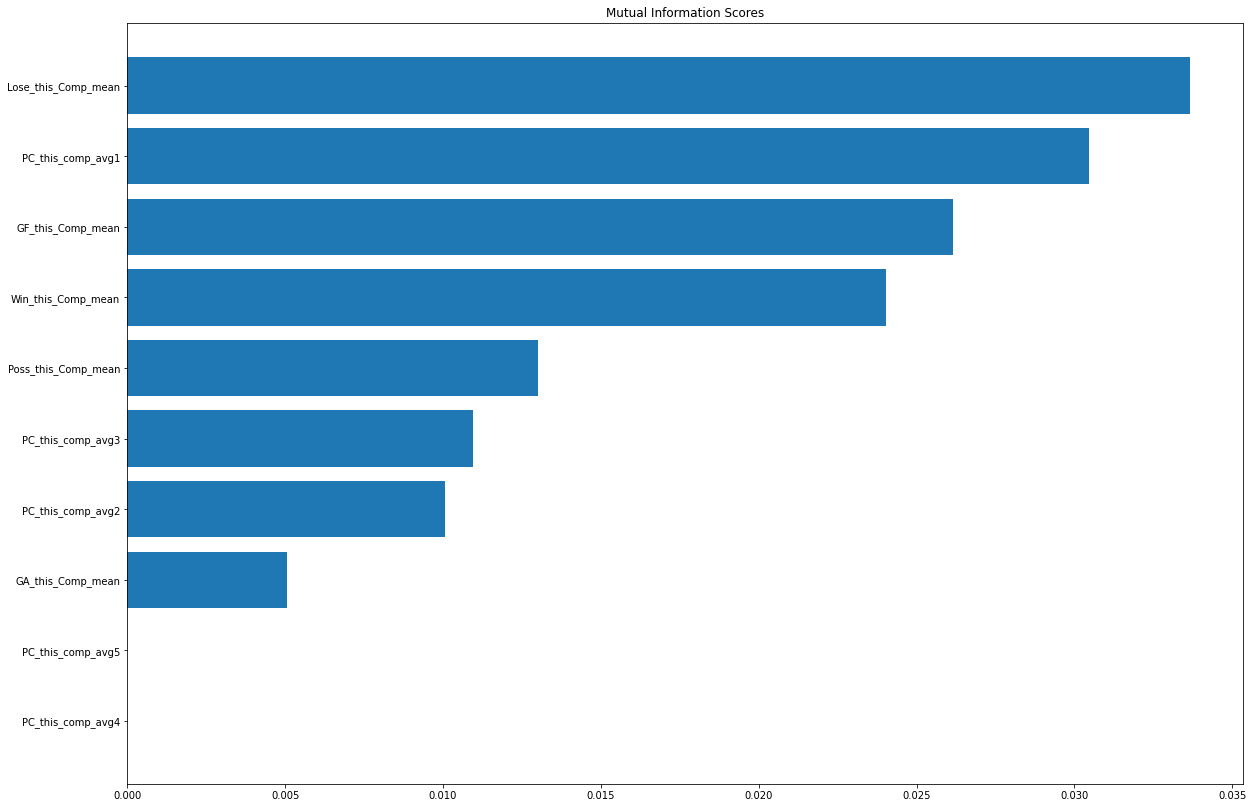

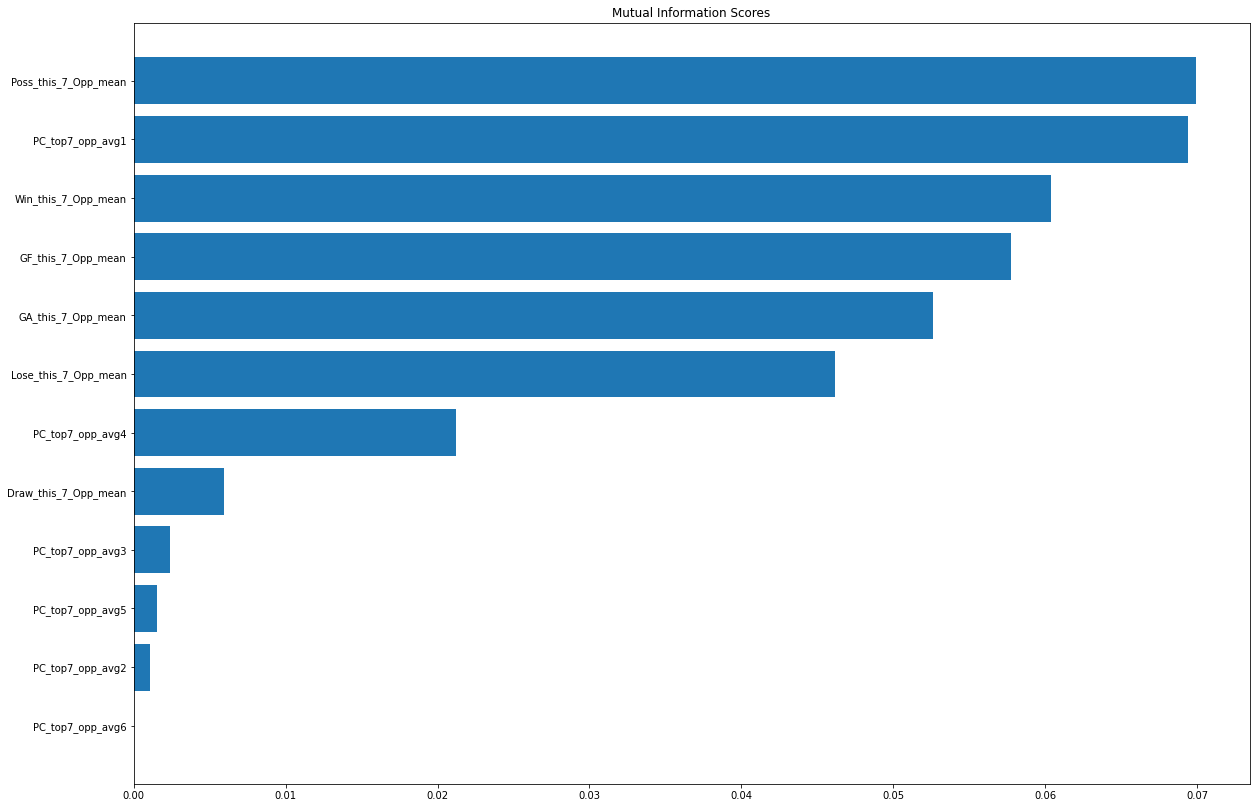

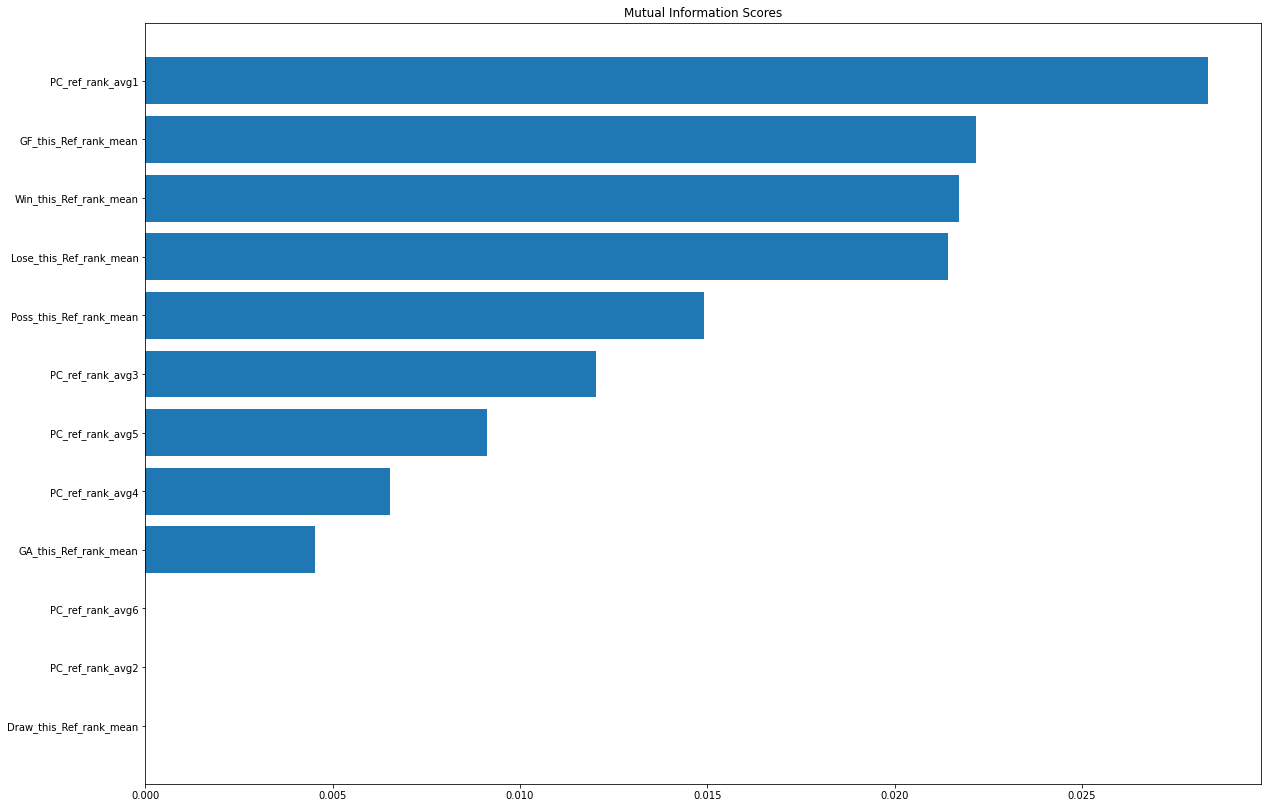

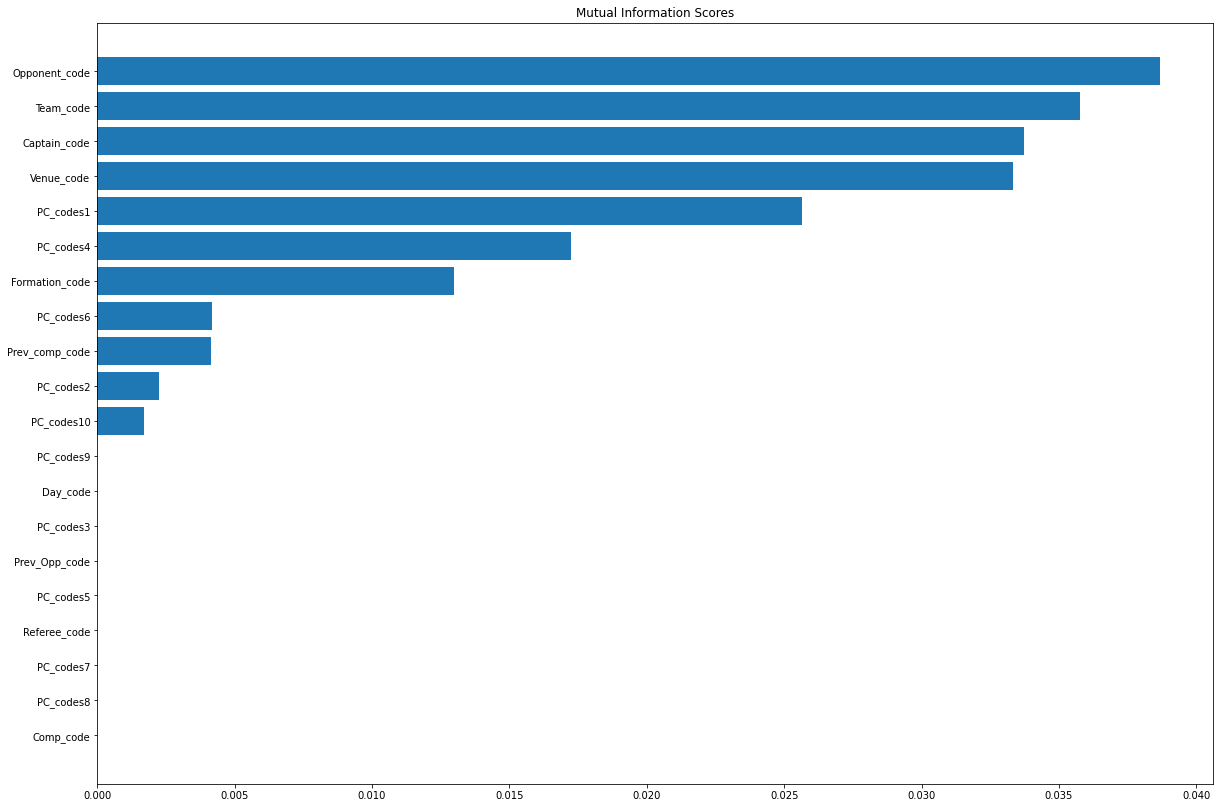

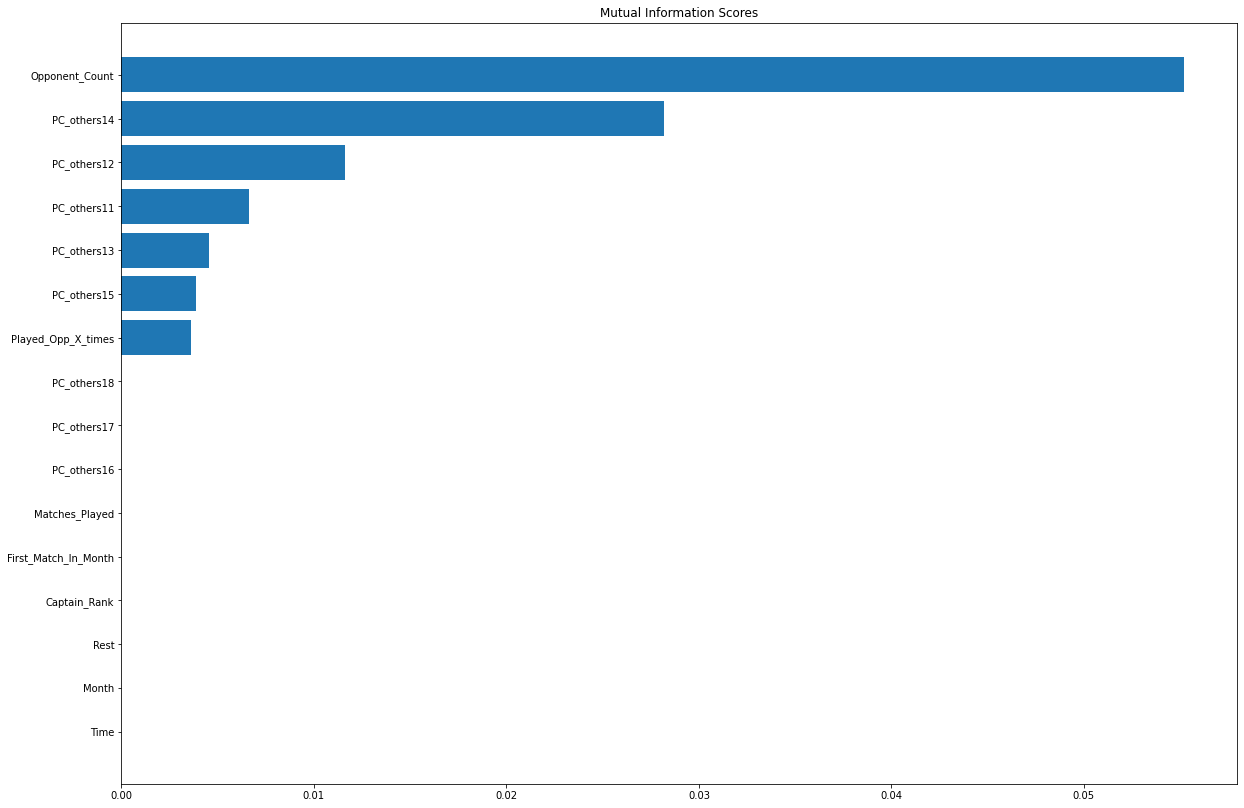

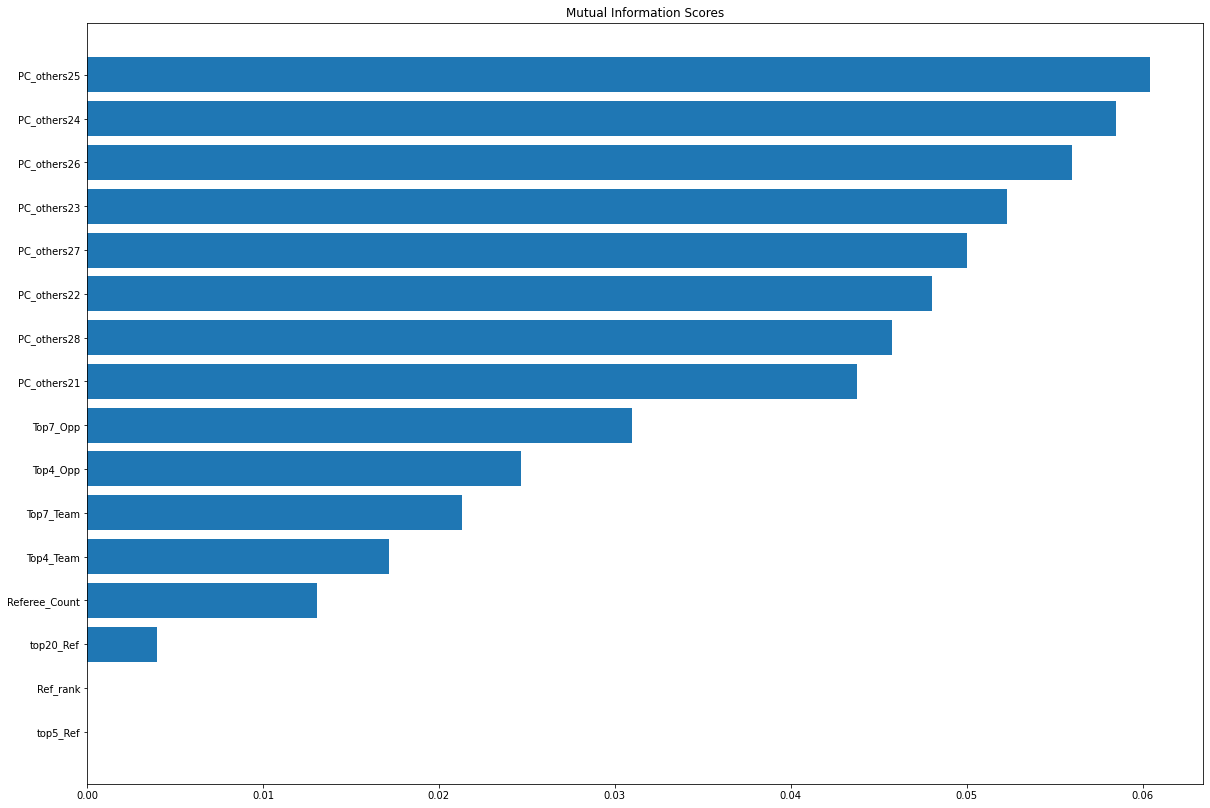

In [50]:
packed_dict = get_PCA_cols(df=df4,target='Lose',features_list= cluster_list,name_list=cluster_list_name,targets=targets)

X_o1


,PC_o11,PC_o12,PC_o13,PC_o14,PC_o15,PC_o16,PC_o17,PC_o18
Time,-0.004257,0.341113,-0.079007,0.010044,-0.917418,0.156688,-0.099874,-0.033160
Month,0.552378,-0.366355,-0.215272,0.015264,-0.146946,0.114014,0.206229,0.661033
Rest,-0.006517,-0.197643,0.654102,0.076134,-0.005634,0.725597,0.013340,-0.023397
Played_Opp_X_times,-0.467860,-0.454434,-0.197802,0.065484,-0.211370,0.023431,0.671462,-0.187336
Captain_Rank,0.010528,0.143406,-0.165935,0.966929,0.094326,0.088338,-0.011193,0.003538
First_Match_In_Month,0.032447,-0.186754,0.643455,0.221182,-0.243095,-0.652698,0.043584,0.118764
Matches_Played,-0.562939,0.392665,0.100068,-0.049725,0.106079,0.037736,0.134349,0.696923
Opponent_Count,-0.397318,-0.542425,-0.169877,0.056892,-0.113126,0.012909,-0.690204,0.162709




X_o2


,PC_o21,PC_o22,PC_o23,PC_o24,PC_o25,PC_o26,PC_o27,PC_o28
Top7_Opp,-0.272955,-0.239430,0.592683,0.093174,0.700709,0.074771,0.079654,0.072700
Top7_Team,0.010837,0.615164,0.284985,-0.209873,-0.087492,-0.086829,0.655409,0.226799
Top4_Opp,-0.258161,-0.228599,0.605122,0.138582,-0.696243,0.025234,-0.061524,-0.080880
Top4_Team,0.033112,0.625381,0.283156,-0.136582,0.098784,0.105489,-0.608368,-0.343472
Referee_Count,-0.500460,-0.029448,-0.086631,-0.442089,0.004894,-0.677659,-0.223314,0.191336
top20_Ref,-0.435584,-0.099719,-0.175988,-0.570205,-0.036435,0.604388,0.150956,-0.234131
top5_Ref,-0.459383,0.183748,-0.214970,0.476764,0.056538,-0.210379,0.269097,-0.601514
Ref_rank,-0.454322,0.276248,-0.190976,0.401910,-0.047868,0.326097,-0.212434,0.604580


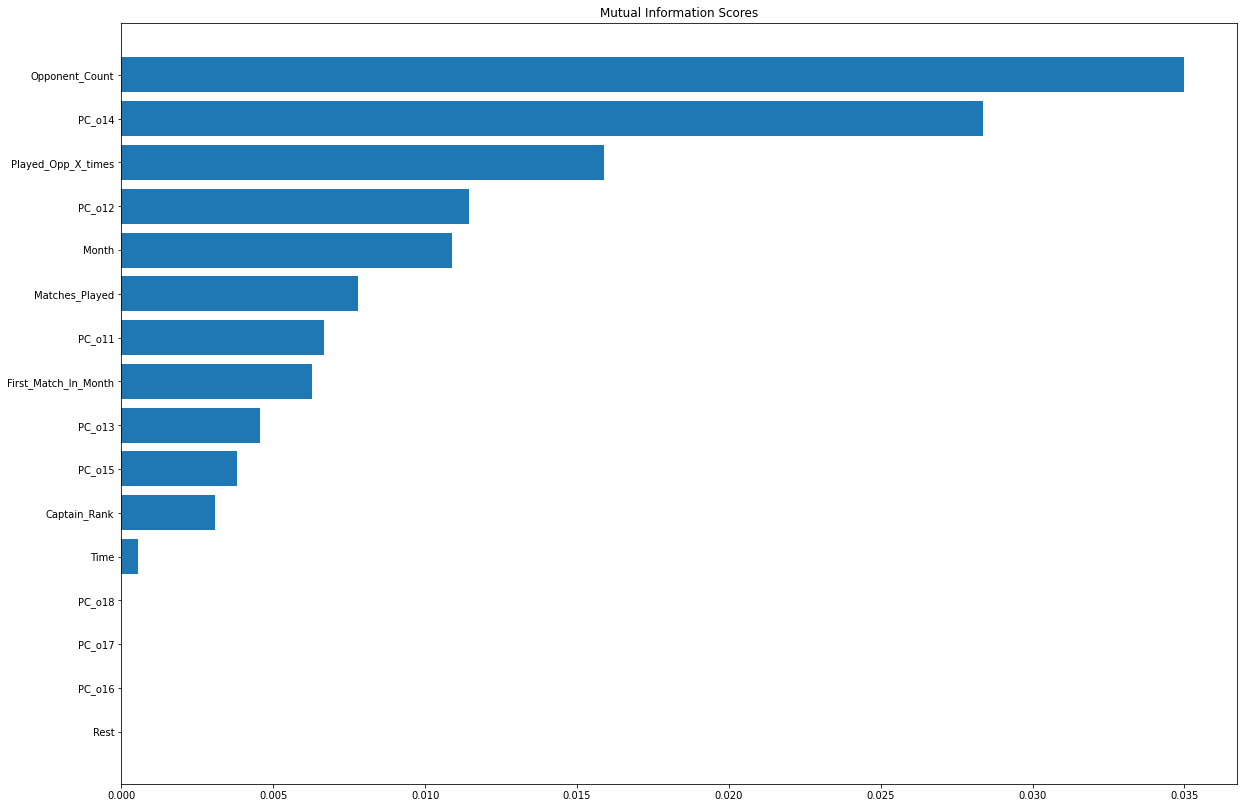

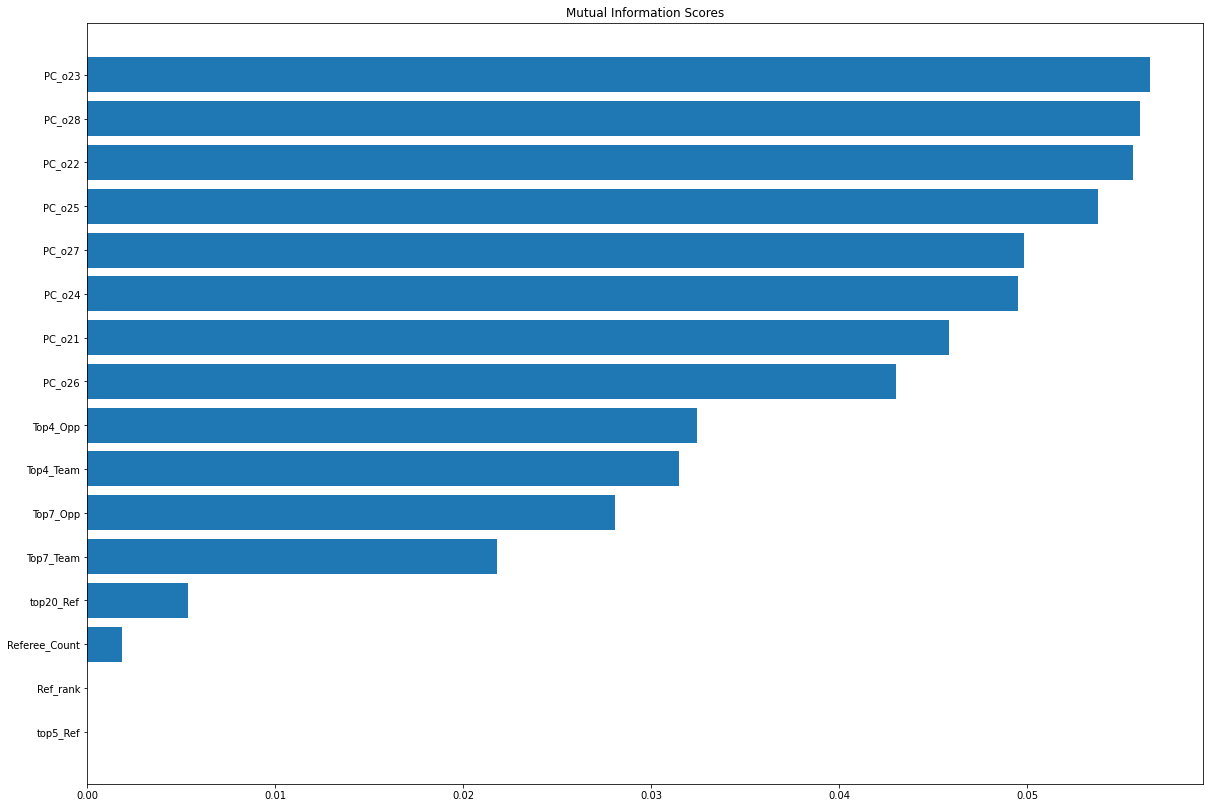

In [51]:
packed_dict2 = get_PCA_cols(df=df4,target='Lose',features_list= [others1,others2],name_list=['o1','o2'],targets=targets)

In [52]:
len(packed_dict),len(packed_dict2)

(23, 2)

In [53]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=10, random_state=1)

In [54]:
def front_test(df,target,the_dict):
    df =df.copy()
    dfs_arr = []
    leaks = 'Win	Draw	Lose	Points	Season'.split('	')
    base_df = df.loc[:,leaks]
    add_with = [target,'Season',"Team", "Opponent", "Result"]
    for col_gp , PC_gp in the_dict.items():
        print(col_gp)
        a = PC_gp.drop(leaks,axis=1)
        dfs_arr.append(a)
        print('df_arrs lenghth',len(dfs_arr))
        All= pd.concat(dfs_arr,axis=1)
        all_df = pd.concat([All,df.loc[:,add_with].reset_index(drop=True)],axis=1)
        print('Shape : ',all_df.shape)
        predictors = all_df.drop(add_with,axis=1).columns
        predictions(data=all_df,predictors=predictors,targets=[target],model=rf)
        print("============================================================>>>>>>>>>>>>>>>>>>")
    return predictors,all_df

In [55]:
p , a = front_test(df=df4,target='Lose',the_dict=packed_dict2)

o1
df_arrs lenghth 1
Shape :  (3779, 17)
Lose Accuracy Score :  0.6689098250336474



predicted_Lose,0.0,1.0
actual,,
0,433,36
1,210,64


Lose Precision :  0.64
Lose F1_score :  0.34224598930481276
Lose ROC :  0.5784087902510389


============================================================>>>>>>>>>>>>>>>>>>
o2
df_arrs lenghth 2
Shape :  (3779, 31)
Lose Accuracy Score :  0.6702557200538358



predicted_Lose,0.0,1.0
actual,,
0,434,35
1,210,64


Lose Precision :  0.6464646464646465
Lose F1_score :  0.3431635388739946
Lose ROC :  0.5794748883320623


============================================================>>>>>>>>>>>>>>>>>>


In [56]:
packed_dict['pca_advs'] = pca_adv_df
packed_dict2['pca_advs'] = pca_adv_df

In [57]:
packed_dict['pca_idea'] = pca_idea_df
packed_dict2['pca_idea'] = pca_idea_df

In [58]:
packed_dict['pca_idea'].head()

,Tot_Pts/Win,Tot_Pts/Loss,Tot_Pts/Draw,Tot_Pts/GF,Tot_Pts/GA,Tot_Win/Loss,Tot_Win/Draw,Tot_Draw/Loss,Tot_Win/GF,Tot_Loss/GA,Tot_Draw/GF,Tot_GF/GA,Tot_GF_GA_+-,Avg_Pts/Win,Avg_Pts/Loss,Avg_Pts/GF,Avg_Pts/GA,Avg_Win/GA,Avg_Win/GF,Avg_Win/Loss,Avg_Win/Draw,Avg_Loss/GA,Avg_Loss/GF,Avg_Draw/GF,Avg_Draw/GA,Avg_GF/GA,Avg_GF_GA+-,l2_Win/GA,l2_Win/GF,l2_Win/Loss,l2g_Win/Draw,l2g_Loss/GA,l2g_Loss/GF,l2g_Draw/GF,l2g_Draw/GA,l2g_GF/GA,l2g_GF_GA+-,l3_Win/GA,l3_Win/Loss,l3g_Win/Draw,l3g_Loss/GA,l3g_Loss/GF,l3g_Draw/GF,l3g_Draw/GA,l3g_GF/GA,l3g_GF_GA+-,this_month_sum_Win/GA,this_month_sum_GF/GA,this_month_sum_GF_GA+-,Win,Draw,Lose,Points,Season
0,4.000000,2.0,4.0,0.800000,0.444444,0.5,1.0,0.5,0.200000,0.222222,0.200000,0.555556,-4.0,4.000000,2.0,0.800000,0.444444,0.111111,0.200000,0.5,1.0,0.222222,0.400000,0.200000,0.111111,0.555556,-1.000000,0.0,0.000000,0.0,0.0,0.4,0.0,0.0,0.0,0.0,-5.0,0.125,0.5,0.0,0.25,0.500000,0.00,0.0,0.5,-1.333333,3.000000,7.750000,5.4,1,0,0,3,2018
1,3.333333,5.0,10.0,0.909091,1.000000,1.5,3.0,0.5,0.272727,0.200000,0.090909,1.100000,1.0,3.333333,5.0,0.909091,1.000000,0.300000,0.272727,1.5,3.0,0.200000,0.181818,0.090909,0.100000,1.100000,0.166667,2.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.400,2.0,0.0,0.20,0.166667,0.00,0.0,1.2,0.333333,2.000000,6.000000,5.0,0,1,0,1,2018
2,3.500000,7.0,7.0,1.166667,1.400000,2.0,2.0,1.0,0.333333,0.200000,0.166667,1.200000,2.0,3.500000,7.0,1.166667,1.400000,0.400000,0.333333,2.0,2.0,0.200000,0.166667,0.166667,0.200000,1.200000,0.250000,0.0,1.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.000,0.0,2.0,0.00,0.000000,0.25,1.0,4.0,1.000000,3.000000,7.000000,6.0,1,0,0,3,2018
3,3.333333,10.0,10.0,1.111111,1.666667,3.0,3.0,1.0,0.333333,0.166667,0.111111,1.500000,6.0,3.333333,10.0,1.111111,1.666667,0.500000,0.333333,3.0,3.0,0.166667,0.111111,0.111111,0.166667,1.500000,0.600000,1.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,1.500,0.0,0.0,0.00,0.000000,0.00,0.0,3.5,1.666667,0.461538,2.230769,3.2,1,0,0,3,2018
4,3.285714,11.5,11.5,1.150000,1.916667,3.5,3.5,1.0,0.350000,0.166667,0.100000,1.666667,8.0,3.285714,11.5,1.150000,1.916667,0.583333,0.350000,3.5,3.5,0.166667,0.100000,0.100000,0.166667,1.666667,0.727273,1.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,1.500,0.0,0.0,0.00,0.000000,0.00,0.0,4.0,2.000000,0.000000,0.000000,2.0,0,0,1,0,2018


In [59]:
packed_dict['pca_advs'].head()

,PC_advs4,PC_advs2,PC_advs1,PC_advs9,PC_advs19,PC_advs12,PC_advs16,PC_advs17,PC_advs3,PC_advs15,PC_advs6,PC_advs8,Win,Draw,Lose,Points,Season
0,8.177072,-3.041397,13.368159,6.102335,-5.302832,15.060102,14.353502,-9.111374,25.756225,-2.986597,11.328643,25.609959,1,0,0,3,2018
1,9.381199,11.787420,24.213216,1.122012,-5.133676,9.579790,10.787345,-4.935311,26.212193,-1.123926,0.997974,9.133981,0,1,0,1,2018
2,9.427566,17.728090,29.293118,3.620517,-5.167297,4.366472,5.272010,-1.388310,25.528107,-2.597830,4.385837,3.713843,1,0,0,3,2018
3,9.681482,18.480854,28.664809,4.710173,-3.839525,-1.386256,3.287601,3.196197,33.400886,-5.951464,1.491339,3.355368,1,0,0,3,2018
4,9.936182,13.414128,24.179130,-0.199548,-1.879175,1.014517,2.488532,4.672563,36.986834,-5.429365,0.249561,5.017928,0,0,1,0,2018


In [60]:
packed_dict['total']

,Win,Draw,Lose,Points,Season,Total_Loss,Total_Win,PC_total2,PC_total1,PC_total5,Total_Points,Total_GF,PC_total6,Total_GA,PC_total3
0,1,0,0,3,2018,2.0,1.0,-0.528511,-3.039429,0.040984,4.0,5.0,6.138391e-14,9.0,0.038824
1,0,1,0,1,2018,2.0,3.0,-0.704516,-2.718043,0.043462,10.0,11.0,-1.419987e-16,10.0,0.128964
2,1,0,0,3,2018,2.0,4.0,-0.730496,-2.480631,0.083289,14.0,12.0,-4.208832e-15,10.0,-0.077458
3,1,0,0,3,2018,2.0,6.0,-0.879360,-2.137435,0.108186,20.0,18.0,4.831850e-15,12.0,0.022779
4,0,0,1,0,2018,2.0,7.0,-0.970816,-2.004026,0.124181,23.0,20.0,-9.111940e-17,12.0,0.059060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3774,0,0,1,0,2022,15.0,17.0,0.272256,0.723236,-0.018632,56.0,42.0,1.781895e-17,32.0,0.780118
3775,0,1,0,1,2022,16.0,17.0,0.466678,0.831977,-0.004668,56.0,42.0,3.397929e-17,35.0,0.877003
3776,0,0,1,0,2022,16.0,17.0,0.556086,1.028735,-0.013891,57.0,44.0,1.859062e-17,37.0,0.665716
3777,0,1,0,1,2022,17.0,17.0,0.794673,1.197474,0.018946,57.0,45.0,2.305403e-17,42.0,0.786536


In [61]:
df4.Lose.value_counts()[1]/df4.shape[0]

0.36808679544853135

### Lose ratio
    37%

In [64]:
p , a = front_test(df=df4,target='Lose',the_dict=packed_dict)

total
df_arrs lenghth 1
Shape :  (3779, 15)
Lose Accuracy Score :  0.629878869448183



predicted_Lose,0.0,1.0
actual,,
0,436,33
1,242,32


Lose Precision :  0.49230769230769234
Lose F1_score :  0.1887905604719764
Lose ROC :  0.5232129239101676


============================================================>>>>>>>>>>>>>>>>>>
szn_avg
df_arrs lenghth 2
Shape :  (3779, 24)
Lose Accuracy Score :  0.6352624495289367



predicted_Lose,0.0,1.0
actual,,
0,438,31
1,240,34


Lose Precision :  0.5230769230769231
Lose F1_score :  0.20058997050147492
Lose ROC :  0.5289947551087109


============================================================>>>>>>>>>>>>>>>>>>
last1g
df_arrs lenghth 3
Shape :  (3779, 39)
Lose Accuracy Score :  0.6339165545087483



predicted_Lose,0.0,1.0
actual,,
0,446,23
1,249,25


Lose Precision :  0.5208333333333334
Lose F1_score :  0.15527950310559008
Lose ROC :  0.521100182092665


============================================================>>>>>>>>>>>>>>>>>>
last2g
df_arrs lenghth 4
Shape :  (3779, 57)
Lose Accuracy Score :  0.6379542395693136



predicted_Lose,0.0,1.0
actual,,
0,450,19
1,250,24


Lose Precision :  0.5581395348837209
Lose F1_score :  0.15141955835962145
Lose ROC :  0.5235397568985105


============================================================>>>>>>>>>>>>>>>>>>
last3g
df_arrs lenghth 5
Shape :  (3779, 74)
Lose Accuracy Score :  0.6379542395693136



predicted_Lose,0.0,1.0
actual,,
0,453,16
1,253,21


Lose Precision :  0.5675675675675675
Lose F1_score :  0.13504823151125403
Lose ROC :  0.5212635985868365


============================================================>>>>>>>>>>>>>>>>>>
this_month_sum
df_arrs lenghth 6
Shape :  (3779, 90)
Lose Accuracy Score :  0.65814266487214



predicted_Lose,0.0,1.0
actual,,
0,455,14
1,240,34


Lose Precision :  0.7083333333333334
Lose F1_score :  0.2111801242236025
Lose ROC :  0.5471184224861096


============================================================>>>>>>>>>>>>>>>>>>
prev_month_sum
df_arrs lenghth 7
Shape :  (3779, 101)
Lose Accuracy Score :  0.6473755047106325



predicted_Lose,0.0,1.0
actual,,
0,462,7
1,255,19


Lose Precision :  0.7307692307692307
Lose F1_score :  0.12666666666666668
Lose ROC :  0.5272088462795511


============================================================>>>>>>>>>>>>>>>>>>
this_month_avg
df_arrs lenghth 8
Shape :  (3779, 111)
Lose Accuracy Score :  0.6567967698519516



predicted_Lose,0.0,1.0
actual,,
0,464,5
1,250,24


Lose Precision :  0.8275862068965517
Lose F1_score :  0.15841584158415845
Lose ROC :  0.5384651300328389


============================================================>>>>>>>>>>>>>>>>>>
this_venue_avg
df_arrs lenghth 9
Shape :  (3779, 123)
Lose Accuracy Score :  0.6608344549125168



predicted_Lose,0.0,1.0
actual,,
0,464,5
1,247,27


Lose Precision :  0.84375
Lose F1_score :  0.1764705882352941
Lose ROC :  0.5439395825875835


============================================================>>>>>>>>>>>>>>>>>>
this_formation
df_arrs lenghth 10
Shape :  (3779, 137)
Lose Accuracy Score :  0.6433378196500673



predicted_Lose,0.0,1.0
actual,,
0,459,10
1,255,19


Lose Precision :  0.6551724137931034
Lose F1_score :  0.12541254125412543
Lose ROC :  0.5240105520364808


============================================================>>>>>>>>>>>>>>>>>>
this_Opp
df_arrs lenghth 11
Shape :  (3779, 150)
Lose Accuracy Score :  0.6500672947510094



predicted_Lose,0.0,1.0
actual,,
0,459,10
1,250,24


Lose Precision :  0.7058823529411765
Lose F1_score :  0.15584415584415584
Lose ROC :  0.5331346396277217


============================================================>>>>>>>>>>>>>>>>>>
counts
df_arrs lenghth 12
Shape :  (3779, 166)
Lose Accuracy Score :  0.7886944818304172



predicted_Lose,0.0,1.0
actual,,
0,449,20
1,137,137


Lose Precision :  0.8726114649681529
Lose F1_score :  0.6357308584686775
Lose ROC :  0.7286780383795309


============================================================>>>>>>>>>>>>>>>>>>
this_comp_sum
df_arrs lenghth 13
Shape :  (3779, 171)
Lose Accuracy Score :  0.7779273216689099



predicted_Lose,0.0,1.0
actual,,
0,449,20
1,145,129


Lose Precision :  0.8657718120805369
Lose F1_score :  0.6099290780141843
Lose ROC :  0.7140794982335456


============================================================>>>>>>>>>>>>>>>>>>
top7_opp
df_arrs lenghth 14
Shape :  (3779, 187)
Lose Accuracy Score :  0.7806191117092867



predicted_Lose,0.0,1.0
actual,,
0,454,15
1,148,126


Lose Precision :  0.8936170212765957
Lose F1_score :  0.6072289156626506
Lose ROC :  0.7139355360839182


============================================================>>>>>>>>>>>>>>>>>>
top4_opp
df_arrs lenghth 15
Shape :  (3779, 206)
Lose Accuracy Score :  0.7725437415881561



predicted_Lose,0.0,1.0
actual,,
0,455,14
1,155,119


Lose Precision :  0.8947368421052632
Lose F1_score :  0.5847665847665848
Lose ROC :  0.7022279115372044


============================================================>>>>>>>>>>>>>>>>>>
this_ref
df_arrs lenghth 16
Shape :  (3779, 226)
Lose Accuracy Score :  0.775235531628533



predicted_Lose,0.0,1.0
actual,,
0,456,13
1,154,120


Lose Precision :  0.9022556390977443
Lose F1_score :  0.5896805896805897
Lose ROC :  0.705118827136476


============================================================>>>>>>>>>>>>>>>>>>
others
df_arrs lenghth 17
Shape :  (3779, 234)
Lose Accuracy Score :  0.7725437415881561



predicted_Lose,0.0,1.0
actual,,
0,455,14
1,155,119


Lose Precision :  0.8947368421052632
Lose F1_score :  0.5847665847665848
Lose ROC :  0.7022279115372044


============================================================>>>>>>>>>>>>>>>>>>
this_comp_avg
df_arrs lenghth 18
Shape :  (3779, 242)
Lose Accuracy Score :  0.775235531628533



predicted_Lose,0.0,1.0
actual,,
0,457,12
1,155,119


Lose Precision :  0.9083969465648855
Lose F1_score :  0.5876543209876544
Lose ROC :  0.7043601076992514


============================================================>>>>>>>>>>>>>>>>>>
top7_opp_avg
df_arrs lenghth 19
Shape :  (3779, 253)
Lose Accuracy Score :  0.7765814266487214



predicted_Lose,0.0,1.0
actual,,
0,456,13
1,153,121


Lose Precision :  0.9029850746268657
Lose F1_score :  0.5931372549019608
Lose ROC :  0.7069436446547244


============================================================>>>>>>>>>>>>>>>>>>
ref_rank_avg
df_arrs lenghth 20
Shape :  (3779, 262)
Lose Accuracy Score :  0.7671601615074024



predicted_Lose,0.0,1.0
actual,,
0,455,14
1,159,115


Lose Precision :  0.8914728682170543
Lose F1_score :  0.5707196029776676
Lose ROC :  0.6949286414642117


============================================================>>>>>>>>>>>>>>>>>>
codes
df_arrs lenghth 21
Shape :  (3779, 273)
Lose Accuracy Score :  0.7779273216689099



predicted_Lose,0.0,1.0
actual,,
0,458,11
1,154,120


Lose Precision :  0.916030534351145
Lose F1_score :  0.5925925925925926
Lose ROC :  0.707251023298523


============================================================>>>>>>>>>>>>>>>>>>
others1
df_arrs lenghth 22
Shape :  (3779, 280)
Lose Accuracy Score :  0.775235531628533



predicted_Lose,0.0,1.0
actual,,
0,457,12
1,155,119


Lose Precision :  0.9083969465648855
Lose F1_score :  0.5876543209876544
Lose ROC :  0.7043601076992514


============================================================>>>>>>>>>>>>>>>>>>
others2
df_arrs lenghth 23
Shape :  (3779, 294)
Lose Accuracy Score :  0.7711978465679677



predicted_Lose,0.0,1.0
actual,,
0,457,12
1,158,116


Lose Precision :  0.90625
Lose F1_score :  0.5771144278606966
Lose ROC :  0.6988856551445068


============================================================>>>>>>>>>>>>>>>>>>
pca_advs
df_arrs lenghth 24
Shape :  (3779, 306)
Lose Accuracy Score :  0.7806191117092867



predicted_Lose,0.0,1.0
actual,,
0,458,11
1,152,122


Lose Precision :  0.9172932330827067
Lose F1_score :  0.5995085995085996
Lose ROC :  0.7109006583350194


============================================================>>>>>>>>>>>>>>>>>>
pca_idea
df_arrs lenghth 25
Shape :  (3779, 355)
Lose Accuracy Score :  0.7725437415881561



predicted_Lose,0.0,1.0
actual,,
0,454,15
1,154,120


Lose Precision :  0.8888888888888888
Lose F1_score :  0.58679706601467
Lose ROC :  0.7029866309744291


============================================================>>>>>>>>>>>>>>>>>>


In [65]:
a.head()

,Total_Loss,Total_Win,PC_total2,PC_total1,PC_total5,Total_Points,Total_GF,PC_total6,Total_GA,PC_total3,GF_Avg_for_szn,PC_szn_avg1,Loss_Avg_for_szn,Points_Avg_for_szn,Win_Avg_for_szn,GA_Avg_for_szn,PC_szn_avg4,PC_szn_avg2,PC_szn_avg3,PC_last1g4,PC_last1g2,Away_Win_last_1gm_sum,PC_last1g9,PC_last1g6,PC_last1g5,GA_last_1gm_sum,PC_last1g1,PC_last1g3,PC_last1g8,Points_last_1gm_sum,Draw_last_1gm_sum,Away_Loss_last_1gm_sum,Lose_last_1gm_sum,PC_last1g10,PC_last2g7,PC_last2g6,PC_last2g2,PC_last2g9,PC_last2g4,Points_last_2gm_sum,PC_last2g8,Lose_last_2gm_sum,PC_last2g1,Win_last_2gm_sum,PC_last2g12,PC_last2g10,PC_last2g3,Away_Win_last_2gm_sum,GF_last_2gm_sum,GA_last_2gm_sum,Draw_last_2gm_sum,PC_last2g5,PC_last3g5,Lose_last_3gm_mean,Poss_last_3gm_mean,GA_last_3gm_mean,PC_last3g10,PC_last3g2,PC_last3g1,PC_last3g4,Away_Win_last_3gm_mean,PC_last3g9,PC_last3g7,PC_last3g3,Away_Draw_last_3gm_mean,GF_last_3gm_mean,Home_Win_last_3gm_mean,Draw_last_3gm_mean,PC_last3g8,GF_this_month_sum,PC_this_month_sum5,PC_this_month_sum1,PC_this_month_sum2,Away_Loss_this_month_sum,PC_this_month_sum3,Away_Draw_this_month_sum,PC_this_month_sum4,Away_Win_this_month_sum,PC_this_month_sum7,PC_this_month_sum8,PC_this_month_sum6,Home_Draw_this_month_sum,Home_Loss_this_month_sum,GA_this_month_sum,Home_Win_this_month_sum,PC_prev_month_sum6,PC_prev_month_sum8,PC_prev_month_sum2,PC_prev_month_sum5,PC_prev_month_sum3,PC_prev_month_sum7,PC_prev_month_sum4,PC_prev_month_sum1,GF_sum_prev_month_,Away_Win_sum_prev_month_,Away_Loss_sum_prev_month_,GF_this_month_mean,Poss_mean_prev_month_,PC_this_month_avg1,GA_this_month_mean,Poss_this_month_mean,GA_mean_prev_month_,GF_mean_prev_month_,PC_this_month_avg6,PC_this_month_avg2,PC_this_month_avg3,GF_this_Venue_mean,PC_this_venue_avg1,Lose_this_Venue_sum,Poss_this_Venue_mean,GA_this_Venue_mean,GA_this_Venue_sum,GF_this_Venue_sum,PC_this_venue_avg3,PC_this_venue_avg2,Win_this_Venue_sum,PC_this_venue_avg4,PC_this_venue_avg5,PC_this_formation2,Poss_this_Formation_mean,GA_this_Formation_mean,GF_this_Formation_mean,PC_this_formation8,GF_this_Formation_sum,GA_this_Formation_sum,PC_this_formation1,PC_this_formation7,Draw_this_Formation_sum,PC_this_formation3,Lose_this_Formation_sum,PC_this_formation4,Win_this_Formation_sum,PC_this_Opp2,Win_this_Formation_sum,GF_this_Formation_sum,GA_this_Formation_mean,Poss_this_Formation_mean,PC_this_Opp8,PC_this_Opp7,PC_this_Opp1,Lose_this_Formation_sum,GA_this_Formation_sum,PC_this_Opp3,PC_this_Opp4,GF_this_Formation_mean,Lose_this_Opp_sum,PC_counts1,PC_counts7,PC_counts6,PC_counts2,PC_counts3,PC_counts4,PC_counts8,PC_counts5,GA_this_Opp_mean,GA_this_Opp_sum,Win_this_Opp_sum,GF_this_Opp_sum,GF_this_Opp_mean,Poss_this_Opp_mean,Draw_this_Opp_sum,Opponent_Count,Captain_Count,PC_this_comp_sum2,PC_this_comp_sum3,PC_this_comp_sum1,PC_top7_opp2,PC_top7_opp3,Lose_this_Comp_sum,Win_this_Comp_sum,PC_top7_opp10,Away_Draw_this_Comp_sum,PC_top7_opp9,Home_Win_this_Comp_sum,Draw_this_Comp_sum,Away_Loss_this_Comp_sum,Away_Win_this_Comp_sum,PC_top7_opp1,PC_top7_opp4,PC_top7_opp11,GA_this_Comp_sum,PC_top7_opp8,PC_top4_opp2,Away_Win_this_7_Opp_sum,Win_this_7_Opp_sum,Home_Draw_this_7_Opp_sum,GF_this_7_Opp_sum,PC_top4_opp3,PC_top4_opp10,Draw_this_7_Opp_sum,Home_Win_this_7_Opp_sum,PC_top4_opp8,Away_Draw_this_7_Opp_sum,PC_top4_opp9,PC_top4_opp11,GA_this_7_Opp_sum,Away_Loss_this_7_Opp_sum,PC_top4_opp7,PC_top4_opp5,PC_top4_opp1,PC_top4_opp6,Away_Win_this_4_Opp_sum,GF_this_4_Opp_sum,PC_this_ref2,Home_Win_this_4_Opp_sum,Win_this_4_Opp_sum,Draw_this_4_Opp_sum,Away_Loss_this_4_Opp_sum,PC_this_ref3,PC_this_ref10,PC_this_ref1,PC_this_ref9,Away_Draw_this_4_Opp_sum,Home_Loss_this_4_Opp_sum,Lose_this_4_Opp_sum,PC_this_ref11,PC_this_ref6,Home_Draw_this_4_Opp_sum,PC_this_ref7,PC_this_ref5,GA_this_4_Opp_sum,PC_others2,Lose_this_Ref_sum,PC_others1,Draw_this_Ref_sum,Win_this_Ref_sum,PC_others5,GF_this_Ref_sum,GA_this_Ref_sum,Lose_this_Comp_mean,PC_this_comp_avg1,GF_this_Comp_mean,Win_this_Comp_mean,Poss_this_Comp_mean,PC_this_comp_avg3,PC_this_co

In [66]:
list(p)

['Total_Loss',
 'Total_Win',
 'PC_total2',
 'PC_total1',
 'PC_total5',
 'Total_Points',
 'Total_GF',
 'PC_total6',
 'Total_GA',
 'PC_total3',
 'GF_Avg_for_szn',
 'PC_szn_avg1',
 'Loss_Avg_for_szn',
 'Points_Avg_for_szn',
 'Win_Avg_for_szn',
 'GA_Avg_for_szn',
 'PC_szn_avg4',
 'PC_szn_avg2',
 'PC_szn_avg3',
 'PC_last1g4',
 'PC_last1g2',
 'Away_Win_last_1gm_sum',
 'PC_last1g9',
 'PC_last1g6',
 'PC_last1g5',
 'GA_last_1gm_sum',
 'PC_last1g1',
 'PC_last1g3',
 'PC_last1g8',
 'Points_last_1gm_sum',
 'Draw_last_1gm_sum',
 'Away_Loss_last_1gm_sum',
 'Lose_last_1gm_sum',
 'PC_last1g10',
 'PC_last2g7',
 'PC_last2g6',
 'PC_last2g2',
 'PC_last2g9',
 'PC_last2g4',
 'Points_last_2gm_sum',
 'PC_last2g8',
 'Lose_last_2gm_sum',
 'PC_last2g1',
 'Win_last_2gm_sum',
 'PC_last2g12',
 'PC_last2g10',
 'PC_last2g3',
 'Away_Win_last_2gm_sum',
 'GF_last_2gm_sum',
 'GA_last_2gm_sum',
 'Draw_last_2gm_sum',
 'PC_last2g5',
 'PC_last3g5',
 'Lose_last_3gm_mean',
 'Poss_last_3gm_mean',
 'GA_last_3gm_mean',
 'PC_last3g

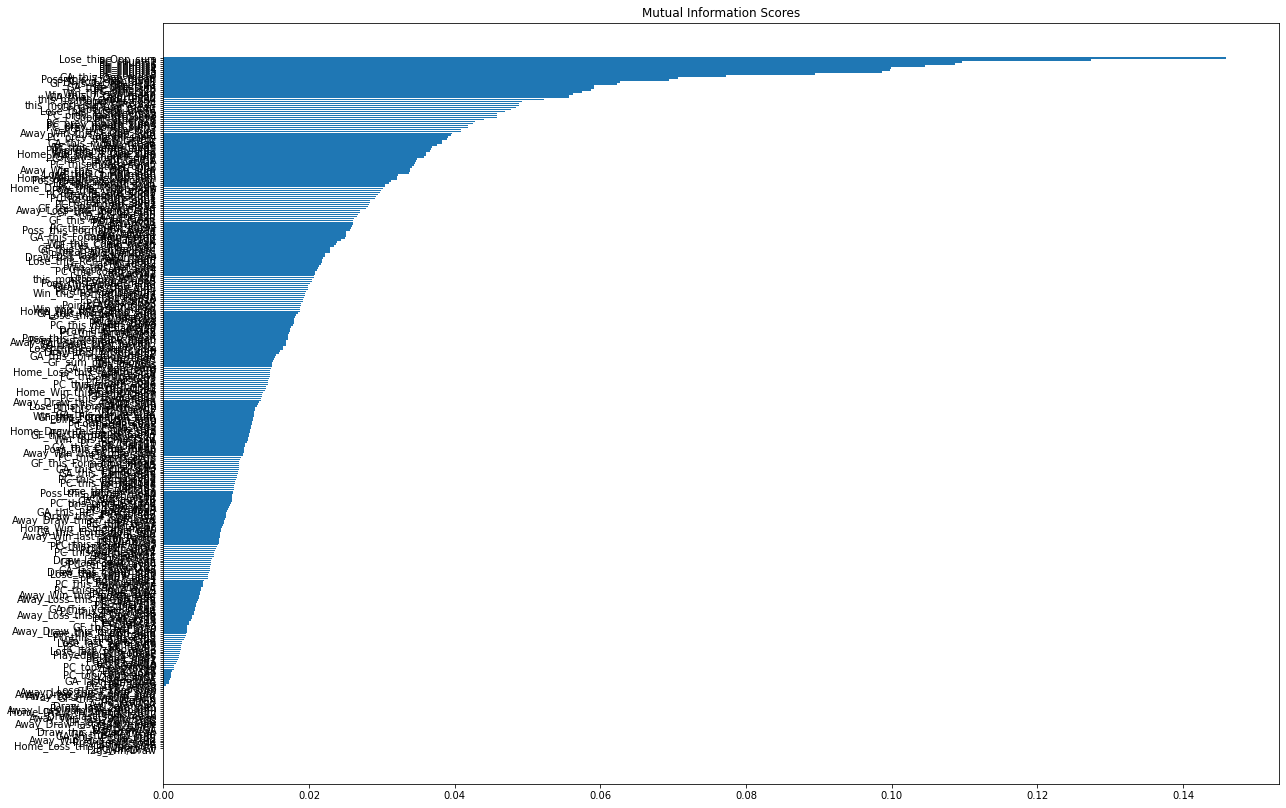

In [68]:
mi_scores_1 = make_mi_scores_Classif(X_train=a.drop(['Lose','Season',"Team", "Opponent", "Result"],axis=1).reset_index(drop=True), y_train=a['Lose'])
plot_mi_scores(scores=mi_scores_1)

In [71]:
topk = mi_scores_1[mi_scores_1>0.01].index.to_list()

In [72]:
len(topk)

214

In [73]:
predictions(data=a, predictors=topk, targets=['Lose'], model=rf)

Lose Accuracy Score :  0.784656796769852



predicted_Lose,0.0,1.0
actual,,
0,457,12
1,148,126


Lose Precision :  0.9130434782608695
Lose F1_score :  0.6116504854368932
Lose ROC :  0.7171338303269886




,actual,predicted_Lose,Team,Opponent,Result
3036,0,0.0,Arsenal,Norwich City,W
3037,0,0.0,Arsenal,Burnley,W
3038,0,0.0,Arsenal,Tottenham,W
3039,0,0.0,Arsenal,Brighton,D
3040,0,0.0,Arsenal,Crystal Palace,D
...,...,...,...,...,...
3774,1,0.0,Wolverhampton Wanderers,Brighton,L
3775,0,0.0,Wolverhampton Wanderers,Chelsea,D
3776,1,1.0,Wolverhampton Wanderers,Manchester City,L
3777,0,0.0,Wolverhampton Wanderers,Norwich City,D


In [74]:
predictions(data=a, predictors=p, targets=['Lose'], model=rf)

Lose Accuracy Score :  0.7725437415881561



predicted_Lose,0.0,1.0
actual,,
0,454,15
1,154,120


Lose Precision :  0.8888888888888888
Lose F1_score :  0.58679706601467
Lose ROC :  0.7029866309744291




,actual,predicted_Lose,Team,Opponent,Result
3036,0,0.0,Arsenal,Norwich City,W
3037,0,0.0,Arsenal,Burnley,W
3038,0,0.0,Arsenal,Tottenham,W
3039,0,0.0,Arsenal,Brighton,D
3040,0,0.0,Arsenal,Crystal Palace,D
...,...,...,...,...,...
3774,1,0.0,Wolverhampton Wanderers,Brighton,L
3775,0,0.0,Wolverhampton Wanderers,Chelsea,D
3776,1,1.0,Wolverhampton Wanderers,Manchester City,L
3777,0,0.0,Wolverhampton Wanderers,Norwich City,D


In [75]:
def backtest(data, model,target, predictors, start=1000, step=750,thresh=.6):
    data = data.loc[:,~data.columns.duplicated()]
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train[target])
        
        # Make predictions
        preds_probs = model.predict_proba(test[predictors])[:,1]
        preds_probs = pd.Series(preds_probs, index=test.index)
        preds = preds_probs.copy()
        preds[preds > thresh] = 1
        preds[preds<= thresh] = 0
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test[target],"Predictions": preds,"Probs":preds_probs}, axis=1)
        
        predictions.append(combined)
    out_df = pd.concat(predictions)
    print('Precision_score : ',precision_score(out_df.Target,out_df.Predictions))
    return out_df

In [76]:
backtest(data=a, model=rf, predictors=topk, start=1000, step=750,target='Lose')

Precision_score :  0.8795698924731182


,Target,Predictions,Probs
1000,1,1.0,0.660438
1001,0,0.0,0.460143
1002,0,0.0,0.197987
1003,1,1.0,0.683689
1004,1,1.0,0.600815
...,...,...,...
3774,1,0.0,0.274892
3775,0,0.0,0.323964
3776,1,1.0,0.680755
3777,0,0.0,0.440192


In [77]:
backtest(data=a, model=rf, predictors=p, start=1000, step=750,target='Lose')

Precision_score :  0.8943965517241379


,Target,Predictions,Probs
1000,1,1.0,0.623548
1001,0,0.0,0.463656
1002,0,0.0,0.172424
1003,1,1.0,0.655333
1004,1,1.0,0.629814
...,...,...,...
3774,1,0.0,0.292512
3775,0,0.0,0.435488
3776,1,1.0,0.667456
3777,0,0.0,0.453115


In [79]:
rf_ish = backtest(data=a, model=rf, predictors=p, start=1000, step=750,target='Lose',thresh = 0.6)

Precision_score :  0.8943965517241379


In [80]:
display(pd.crosstab(index=rf_ish.Target, columns=rf_ish.Predictions))

Predictions,0.0,1.0
Target,,
0,1707,49
1,608,415


In [78]:
#my metrics
from my_metrics import tpr,fpr

In [82]:
def best_thresh_curve(y_true,y_proba_score):
    tpr_list = []
    fpr_list = []

    # actual targets
    #param : y_true = [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
    # predicted probabilities of a sample being 1
    # param : y_pred = [0.1, 0.3, 0.2, 0.6, 0.8, 0.05, 0.9, 0.5, 0.3, 0.66, 0.3, 0.2, 0.85, 0.15, 0.99]

    # handmade thresholds
    thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.85, 0.9, 0.99, 1.0]

    # loop over all thresholds
    for thresh in thresholds: 
        # calculate predictions for a given threshold
        temp_pred = [1 if x >= thresh else 0 for x in y_proba_score]
        
        # calculate tpr
        temp_tpr = tpr(y_true, temp_pred) #TPR or recall is also known as sensitivity
        
        # calculate fpr
        temp_fpr = fpr(y_true, temp_pred) #sklearn.metrcs.precision_score
        # append tpr and fpr to lists
        tpr_list.append(temp_tpr)
        fpr_list.append(temp_fpr)
        
    plt.figure(figsize=(7, 7))
    plt.fill_between(fpr_list, tpr_list, alpha=0.4)
    plt.plot(fpr_list, tpr_list, lw=3)
    plt.xlim(0, 1.0)
    plt.ylim(0, 1.0)
    plt.xlabel('FPR', fontsize=15)
    plt.ylabel('TPR', fontsize=15)
    plt.show()
    

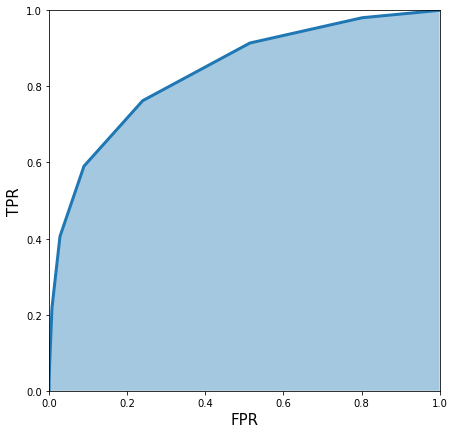

In [83]:
best_thresh_curve(y_true=rf_ish.Target,y_proba_score=rf_ish.Probs)